In [1]:
%%capture
# !pip3.12 install missingno
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import export_text
import seaborn as sns
import missingno as msno

# Análisis preliminar y separación en chunks


In [2]:
# df_data_100 = pd.read_csv('train_data_100_lines.csv', encoding='ISO-8859-1')
# df_label = pd.read_csv('train_labels_50_lines.csv', encoding='ISO-8859-1')

In [3]:
# df_data_100.head()


In [4]:
# import pandas as pd

# # Revisar si las transacciones de un mismo cliente están consecutivas
# df_data_100['is_consecutive'] = df_data_100['ID'] == df_data_100['ID'].shift()

# # Verificar si hay filas donde el ID del cliente no es consecutivo
# non_consecutive = df_data_100[df_data_100['is_consecutive'] == False]

# if non_consecutive.empty:
#     print("Todas las transacciones de los clientes están colocadas consecutivamente.")
# else:
#     print(f"Hay {len(non_consecutive)} transacciones que no están consecutivas.")
#     print(non_consecutive[['ID']].drop_duplicates())  # Muestra los IDs no consecutivos


In [5]:
# df_data = pd.read_csv('train_data.csv', encoding='ISO-8859-1')


In [6]:
# df_data.shape[0]

### División en csv's


In [7]:

# # Definir el tamaño objetivo de 500,000 filas por CSV
# chunk_size = 500000

# # Inicializar variables
# current_chunk = []
# current_chunk_size = 0
# file_index = 1
# last_customer_id = None

# # Función para guardar el chunk actual en un CSV
# def save_chunk(chunk, file_index):
#     df_chunk = pd.DataFrame(chunk)
#     df_chunk.to_csv(f'train_data_part_{file_index}.csv', index=False)
#     print(f'Archivo train_data_part_{file_index}.csv guardado con {len(df_chunk)} filas.')

# # Iterar sobre el DataFrame
# for i, row in df_data.iterrows():
#     customer_id = row['ID']

#     # Si hemos alcanzado el tamaño máximo del chunk y el nuevo customer_id es diferente al último en el chunk
#     if current_chunk_size >= chunk_size and customer_id != last_customer_id:
#         save_chunk(current_chunk, file_index)  # Guardar el CSV actual
#         file_index += 1
#         current_chunk = []  # Reiniciar el chunk
#         current_chunk_size = 0

#     # Añadir la fila actual al chunk
#     current_chunk.append(row)
#     current_chunk_size += 1
#     last_customer_id = customer_id

# # Guardar el último chunk si no está vacío
# if current_chunk:
#     save_chunk(current_chunk, file_index)


In [8]:
# df_data_part_1 = pd.read_csv('train_data_part_1.csv', encoding='ISO-8859-1')

In [9]:
# pd.set_option('display.max_rows', None)

In [10]:
# percentage = df_data_part_1.isnull().mean() * 100
# columns_with_nulls = percentage[percentage > 0]
# print(columns_with_nulls)


# Preprocesado  


## Cargado de csv's


In [11]:
for i in range(1, 8):
    file_name = f'../data/train_data_part_{i}.csv'
    globals()[f'df_data_part_{i}'] = pd.read_csv(file_name, encoding='ISO-8859-1')
    print(f'Archivo {file_name} cargado en df_data_part_{i}')

Archivo ../data/train_data_part_1.csv cargado en df_data_part_1
Archivo ../data/train_data_part_2.csv cargado en df_data_part_2
Archivo ../data/train_data_part_3.csv cargado en df_data_part_3
Archivo ../data/train_data_part_4.csv cargado en df_data_part_4
Archivo ../data/train_data_part_5.csv cargado en df_data_part_5
Archivo ../data/train_data_part_6.csv cargado en df_data_part_6
Archivo ../data/train_data_part_7.csv cargado en df_data_part_7


### Comprobar columnas con valores nulos

In [12]:
def null_percentage(df, percentage):
    null_ratio = {}
    for col in df.columns:
        ratio = df[col].isna().sum() / len(df) * 100
        if ratio > percentage:
            null_ratio[col] = ratio
           
    return null_ratio

Me quedo solo con las columnas con menos de 50% de valores nulos

In [13]:
columns_with_high_nulls = []
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    null_columns = set(null_percentage(data_frame, 50).keys())
    
    # Si es el primer DataFrame, inicializar el conjunto con sus columnas
    if i == 1:
        columns_with_high_nulls = null_columns
    else:
        # Mantener solo las columnas que están en todos los DataFrames
        columns_with_high_nulls = columns_with_high_nulls.intersection(null_columns)

columns_with_high_nulls = list(columns_with_high_nulls)

print(f"Columnas con más del 50% de valores nulos en todos los CSVs: {columns_with_high_nulls}")

Columnas con más del 50% de valores nulos en todos los CSVs: ['Infraction_SVKR', 'Infraction_NCB', 'Risk_5797', 'Infraction_MAN', 'Infraction_CLLY', 'Infraction_SBF', 'Base_8379', 'Infraction_WWLN', 'Infraction_ADWZ', 'Infraction_WEG', 'Infraction_WLMI', 'Infraction_APIU', 'Expenditure_KMW', 'Infraction_EBA', 'Infraction_ZTLC', 'Infraction_JVWF', 'Infraction_HPLO', 'Infraction_QGC', 'Infraction_ZVHJ', 'Base_64022', 'Base_8318', 'Infraction_IRKE', 'Risk_4561', 'Infraction_GEL', 'Base_3958', 'Infraction_FUSM', 'Infraction_ANHZ', 'Infraction_MZI', 'Infraction_HPS', 'Infraction_GWL']


Eliminamos las columnas con más de 50% de valores nulos en todos los csv's

In [14]:
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame.drop(columns=columns_with_high_nulls, inplace=True)
    

### Comprobar si hay filas que tengan todas las columnas a null


In [15]:
# Verificar si hay filas completamente nulas
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    null_rows = data_frame[data_frame.isnull().all(axis=1)]
    if not null_rows.empty:
        print(f'Filas completamente nulas en df_data_part_{i}:')
        print(null_rows)
    else:
        print(f'No hay filas completamente nulas en df_data_part_{i}.')

No hay filas completamente nulas en df_data_part_1.
No hay filas completamente nulas en df_data_part_2.
No hay filas completamente nulas en df_data_part_3.
No hay filas completamente nulas en df_data_part_4.
No hay filas completamente nulas en df_data_part_5.
No hay filas completamente nulas en df_data_part_6.
No hay filas completamente nulas en df_data_part_7.


### Comprobar filas duplicadas

In [17]:
# Verificar si hay filas duplicadas en cada DataFrame
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    duplicate_rows = data_frame[data_frame.duplicated()]
    if not duplicate_rows.empty:
        print(f'Filas duplicadas en df_data_part_{i}:')
        print(duplicate_rows)
    else:
        print(f'No hay filas duplicadas en df_data_part_{i}.')

No hay filas duplicadas en df_data_part_1.
No hay filas duplicadas en df_data_part_2.
No hay filas duplicadas en df_data_part_3.
No hay filas duplicadas en df_data_part_4.
No hay filas duplicadas en df_data_part_5.
No hay filas duplicadas en df_data_part_6.
No hay filas duplicadas en df_data_part_7.


### Comprobar varianza 0

In [18]:
# Verificar si hay columnas con baja varianza
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    low_variance_cols = []
    for col in data_frame.columns:
        if data_frame[col].nunique() == 1:
            low_variance_cols.append(col)
    if low_variance_cols:
        print(f'Columnas con baja varianza en df_data_part_{i}: {low_variance_cols}')
    else:
        print(f'No hay columnas con baja varianza en df_data_part_{i}.')

No hay columnas con baja varianza en df_data_part_1.
No hay columnas con baja varianza en df_data_part_2.
No hay columnas con baja varianza en df_data_part_3.
No hay columnas con baja varianza en df_data_part_4.
No hay columnas con baja varianza en df_data_part_5.
No hay columnas con baja varianza en df_data_part_6.
No hay columnas con baja varianza en df_data_part_7.


# Análisis de tipo de variable

In [19]:
# Agrupar columnas por tipo de dato
data_types = {}
# No hace falta comprobar todos los df ya que tienen las mismas columnas
data_frame = df_data_part_1
for col in data_frame.columns:
    data_type = str(data_frame[col].dtype)
    if data_type not in data_types:
        data_types[data_type] = []
    data_types[data_type].append(col)

for data_type, columns in data_types.items():
    print(f'{data_type}: {columns}')

object: ['ID', 'Expenditure_AHF', 'Infraction_YFSG', 'Infraction_DQLY', 'Infraction_CLH', 'Base_67254', 'Infraction_TEN']
float64: ['Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863', 'Risk_1930', 'Expenditure_JIG', 'Infraction_SNZ', 'Base_02683', 'Infraction_ZWWJ', 'Infraction_QJJF', 'Base_76065', 'Infraction_EJZ', 'Base_6872', 'Risk_0322', 'Infraction_FMXQ', 'Infraction_GGO', 'Infraction_TLPJ', 'Base_1165', 'Base_39598', 'Base_6187', 'Infraction_ZTNC', 'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Payment_22507', 'Base_9516', 'Expenditure_YTR', 'Base_36384', 'Expenditure_FIP', 'Infraction_PAS', 'Risk_0003', 'Expenditure_HMO', 'Base_24406', 'Expenditure_LMSR', 'Infraction_BSU', 'Base_14808', 'Risk_8065', 'Infraction_ZYW', 'Base_1039', 'Infraction_HSSU', 'Infraction_EHZP', 'Infraction_TBP', 'Base_0580', 'Expenditure_RGD', 'Infraction_PBC', 'Infraction_AQO', 'Base_0229', 'Base_69608', 'Base_91828', 'Base_6852', 'Expenditure_IDZ', 'Risk_1475', 'Expenditure_BWX', 'Base_8511', 'I

## Variables categóricas


In [20]:
# Hacemos print de las columnas de tipo object, solo primeras filas
data_frame = df_data_part_1
print(data_frame.select_dtypes(include='object').head())

                                                  ID Expenditure_AHF  \
0  3333337004103300505242400473433643475477705348...      2017-03-05   
1  3333337004103300505242400473433643475477705348...      2017-04-20   
2  3333337004103300505242400473433643475477705348...      2017-05-11   
3  3333337004103300505242400473433643475477705348...      2017-06-29   
4  3333337004103300505242400473433643475477705348...      2017-08-03   

  Infraction_YFSG Infraction_DQLY Infraction_CLH    Base_67254 Infraction_TEN  
0              CO               O      very_high  moderate_low  extremely_low  
1              CO               O      very_high  moderate_low  extremely_low  
2              CO               O      very_high  moderate_low  extremely_low  
3              CO               O      very_high  moderate_low  extremely_low  
4              CO               O      very_high  moderate_low  extremely_low  


#### Transformación ID to_numeric

In [21]:
# Pasamos ID a número en todos los dataframes para facilitar su procesado
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame['ID'] = pd.to_numeric(data_frame['ID'], errors='coerce')

#### Transformación Expenditure_AHF to_datetime

In [22]:
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame['Expenditure_AHF'] = pd.to_datetime(data_frame['Expenditure_AHF'], errors='coerce')
    data_frame['Expenditure_AHF_year'] = data_frame['Expenditure_AHF'].dt.year
    data_frame['Expenditure_AHF_month'] = data_frame['Expenditure_AHF'].dt.month
    data_frame['Expenditure_AHF_day'] = data_frame['Expenditure_AHF'].dt.day
    data_frame.drop(columns=['Expenditure_AHF'], inplace=True)


#### Transformación Infraction_YFSG encoding

In [23]:
# Ver los valores de la columna Infraction_YFSG en todos los DataFrames y hacer una intersección
unique_values = set()
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    unique_values_i = set(data_frame['Infraction_YFSG'].unique())
    if not unique_values:
        unique_values = unique_values_i
    else:
        unique_values = unique_values.intersection(unique_values_i)

print(unique_values)

{'XL', 'XZ', 'CL', 'CO', 'CR', 'XM'}


In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame['Infraction_YFSG_encoded'] = label_encoder.fit_transform(data_frame['Infraction_YFSG'])
    data_frame.drop(columns=['Infraction_YFSG'], inplace=True)


#### Transformación Infraction_DQLY

In [25]:
# Ver los valores de la columna Infraction_YFSG en todos los DataFrames y hacer una intersección
unique_values = set()
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    unique_values_i = set(data_frame['Infraction_DQLY'].unique())
    if not unique_values:
        unique_values = unique_values_i
    else:
        unique_values = unique_values.intersection(unique_values_i)

print(unique_values)

{'-1', 'O', 'U', nan, 'R'}


In [26]:
# Análisis de porcentaje de NaNs en cada DataFrame en la columna Infraction_DQLY
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    print(f'Porcentaje de NaNs en df_data_part_{i}: {data_frame["Infraction_DQLY"].isna().mean() * 100:.2f}%')

Porcentaje de NaNs en df_data_part_1: 3.96%
Porcentaje de NaNs en df_data_part_2: 3.88%
Porcentaje de NaNs en df_data_part_3: 3.98%
Porcentaje de NaNs en df_data_part_4: 4.02%
Porcentaje de NaNs en df_data_part_5: 3.94%
Porcentaje de NaNs en df_data_part_6: 3.84%
Porcentaje de NaNs en df_data_part_7: 3.93%


Antes de codificarlo necesitamos tratar los NaN

In [27]:
# Como el porcentaje de NaNs es muy bajo (aprox. 4%), rellenamos los NaNs con el valor más común
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    most_common_value = data_frame['Infraction_DQLY'].mode()[0]
    data_frame['Infraction_DQLY'].fillna(most_common_value, inplace=True)



C:\Users\eleni\AppData\Local\Temp\ipykernel_24628\2308713897.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame['Infraction_DQLY'].fillna(most_common_value, inplace=True)


##### Hacemos la codificación de la columna

In [28]:
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    data_frame['Infraction_DQLY_encoded'] = label_encoder.fit_transform(data_frame['Infraction_DQLY'])
    data_frame.drop(columns=['Infraction_DQLY'], inplace=True)


### Las siguientes columnas comparten etiquetas

In [29]:
ordinal_columns = ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']

for col in ordinal_columns:
    print(f'{col}: {df_data_part_1[col].unique()}')

Infraction_CLH: ['very_high' 'moderate_low' 'moderate' 'high' nan 'moderate_high'
 'very_low' 'low']
Base_67254: ['moderate_low' 'low' 'moderate' 'high' 'very_high' 'extremely_high'
 'moderate_high' nan]
Infraction_TEN: ['extremely_low' 'very_high' 'moderate_high' 'moderate_low' 'low' nan
 'moderate' 'high']


In [30]:
frequency_map = {
    'extremely_low': 0,
    'very_low': 1,
    'moderate_low': 2,
    'low': 3,
    'moderate': 4,
    'high':5,
    'moderate_high': 6,
    'very_high': 7,
    'extremely_high': 8
}


for i in range(1, 8):
    for col in ordinal_columns:
        data_frame = globals()[f'df_data_part_{i}']
        data_frame[f'{col}_encoded'] = data_frame[col].map(frequency_map)
        data_frame.drop(columns=[col], inplace=True)

In [31]:
ordinal_columns = ['Infraction_CLH_encoded', 'Base_67254_encoded', 'Infraction_TEN_encoded']

for col in ordinal_columns:
    print(f'{col}: {df_data_part_1[col].unique()}')

Infraction_CLH_encoded: [ 7.  2.  4.  5. nan  6.  1.  3.]
Base_67254_encoded: [ 2.  3.  4.  5.  7.  8.  6. nan]
Infraction_TEN_encoded: [ 0.  7.  6.  2.  3. nan  4.  5.]


In [32]:
# Voy a ver cuántos valores NaN hay en cada columna de las ordinal_columns en la intersection de los DataFrames como porcentaje
for col in ordinal_columns:
    nan_count = 0
    total = 0
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        total += data_frame[col].shape[0]
        nan_count += data_frame[col].isna().sum()
    print(f'{col}: {nan_count/total*100:.2f}%')

Infraction_CLH_encoded: 3.92%
Base_67254_encoded: 0.04%
Infraction_TEN_encoded: 3.21%


Es un porcentaje muy bajo así que podemos rellenarlos sin problema. En este caso usaremos la moda

In [33]:
# Quiero saber el valor que más se repite en cada columna ordinal
for col in ordinal_columns:
    most_common_values = []
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        most_common_value = data_frame[col].mode()[0]
        most_common_values.append(most_common_value)
    print(f'{col}: {most_common_values}')
    

Infraction_CLH_encoded: [np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0)]
Base_67254_encoded: [np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0)]
Infraction_TEN_encoded: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


In [34]:
# Rellenar los valores NaN con el valor más común en cada columna ordinal.
for col in ordinal_columns:
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        most_common_value = data_frame[col].mode()[0]
        data_frame[col] = data_frame[col].fillna(most_common_value)


## Comprobación columnas duplicadas

In [35]:
# Ya hemos visto que las categóricas no están dulpicadas entre sí así que solo analizamos si las columnas numéricas están duplicadas
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    duplicate_columns = data_frame.columns[data_frame.columns.duplicated()]
    if not duplicate_columns.empty:
        print(f'Columnas duplicadas en df_data_part_{i}: {duplicate_columns}')
    else:
        print(f'No hay columnas duplicadas en df_data_part_{i}.')


No hay columnas duplicadas en df_data_part_1.
No hay columnas duplicadas en df_data_part_2.
No hay columnas duplicadas en df_data_part_3.
No hay columnas duplicadas en df_data_part_4.
No hay columnas duplicadas en df_data_part_5.
No hay columnas duplicadas en df_data_part_6.
No hay columnas duplicadas en df_data_part_7.


## Comprobación NaNs

Vamos a analizar las filas para eliminar aquellas que tengan NaN en más del 30% de las columnas si estas componen una pequeña poción del dataframe y rellenar estos valores no tendría sentido ya que la fila perdería valor para el posterior estudio ya que sería completamente artificial

In [38]:
# Quiero saber cuántas filas tienen más del 30% de las columnas nulas en porcentaje sobre el total de todos los DataFrames
rows_to_drop = []
total_rows = 0
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    total_rows += data_frame.shape[0]
    null_percentage = data_frame.isnull().mean(axis=1) * 100
    rows_to_drop.extend(null_percentage[null_percentage > 30].index)
rows_to_drop = set(rows_to_drop)
print(f'Número de filas a eliminar: {len(rows_to_drop)/total_rows*100:.2f}%')


Número de filas a eliminar: 0.26%


In [39]:
# Eliminos las filas con más del 30% de valores nulos
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    # Como no me deja usar los valores de rows_to_drop como índices, lo hago de la siguiente manera
    data_frame.drop(data_frame.index.intersection(rows_to_drop), inplace=True)


Ahora vamos a hacer un análisis de las columnas que nos quedan

In [40]:
# Voy a ver cuántos valores NaN hay en cada columna en la intersection de los DataFrames.
columns_percentage = {}
for col in df_data_part_1.columns:
    nan_count = 0
    total_rows = 0
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        total_rows += data_frame.shape[0]
        nan_count += data_frame[col].isna().sum()
    if nan_count > 0:
        columns_percentage[col] = nan_count/total_rows * 100    
        print(f'{col}: {nan_count/total_rows * 100:.5f}%')

Payment_6804: 0.57285%
Base_80863: 0.00515%
Expenditure_JIG: 18.28497%
Infraction_SNZ: 0.00515%
Base_02683: 0.00515%
Infraction_ZWWJ: 29.85362%
Infraction_QJJF: 4.71919%
Infraction_EJZ: 0.00515%
Infraction_FMXQ: 21.68924%
Infraction_TLPJ: 12.72720%
Base_1165: 0.00009%
Base_6187: 0.37812%
Infraction_AYWV: 0.27658%
Payment_22507: 5.22159%
Infraction_PAS: 0.00515%
Expenditure_HMO: 18.28497%
Infraction_BSU: 3.13283%
Base_14808: 0.75777%
Infraction_HSSU: 1.70469%
Infraction_TBP: 10.71778%
Base_0580: 0.05267%
Infraction_PBC: 13.51881%
Base_0229: 0.00515%
Base_91828: 0.00515%
Base_6852: 0.00515%
Infraction_JYZB: 3.27808%
Base_22178: 0.00515%
Infraction_ZTYG: 1.46566%
Infraction_EYU: 0.17689%
Infraction_QKZN: 0.28817%
Risk_7095: 0.00003%
Infraction_JBR: 45.50540%
Base_66195: 0.05267%
Base_36516: 0.00515%
Infraction_RXQH: 4.71919%
Infraction_HFU: 1.12025%
Infraction_VTR: 0.28817%
Base_7331: 0.00515%
Infraction_XWX: 0.22756%
Risk_4553: 0.00074%
Infraction_VHU: 3.27808%
Risk_4247: 0.00003%
Infrac

Vamos a rellenar aquellas que tengan menos del 6% de NaNs y a eliminar los que tengan más de ese porcentaje , rellenar estos últimos no tendría sentido

In [41]:
# Eliminamos las columnas con más de 6% de valores nulos en la intersección de los DataFrames
for col in columns_percentage.keys():
    if columns_percentage[col] > 6:
        for i in range(1, 8):
            data_frame = globals()[f'df_data_part_{i}']
            data_frame.drop(columns=[col], inplace=True)    

In [42]:
# Vamos a rellenar los NaNs de las columnas restantes de la siguiente manera:
# Si la columna es categórica, rellena con la moda (no hace falta tenerlo en cuenta ahora ya que lo hemos hecho manualmnete anteriormente)
# Si la columna es numérica:
#           - con la media si la desviación estándar es menor a 1
#           - con la mediana si la desviación estándar es mayor a 1
#           - con la moda si la desviación estándar es 0

for col in df_data_part_1.columns:
    for i in range(1, 8):
        data_frame = globals()[f'df_data_part_{i}']
        if data_frame[col].isna().sum() != 0:
            mean = data_frame[col].mean()
            median = data_frame[col].median()
            mode = data_frame[col].mode()[0]
            std = data_frame[col].std()
            if std == 0:
                data_frame[col] = data_frame[col].fillna(mode)
            elif std < 1:
                data_frame[col] = data_frame[col].fillna(mean)
            else:
                data_frame[col] = data_frame[col].fillna(median)


## Tratar valores infinitos

In [43]:
# Imprimir los valores infinitos para tratarlos
from numpy import inf
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    infinite_values = data_frame[data_frame == np.inf].sum().sum()
    print(f'Valores infinitos en df_data_part_{i}: {infinite_values}')

Valores infinitos en df_data_part_1: 0.0
Valores infinitos en df_data_part_2: 0.0
Valores infinitos en df_data_part_3: 0.0
Valores infinitos en df_data_part_4: 0.0
Valores infinitos en df_data_part_5: 0.0
Valores infinitos en df_data_part_6: 0.0
Valores infinitos en df_data_part_7: 0.0


# Selección de características


In [45]:
df_labels_50 = pd.read_csv('../data/train_labels_50_lines.csv', encoding='ISO-8859-1')
df_labels_50.head()

,ID,label
0,3333337004103300505242400473433643475477705348...,0
1,3333412724050477534287115505554450368233003786...,0
2,3333755354307801420025735367852078550468735254...,0
3,3333545238615133608512002405572210535308150267...,0
4,3333333216773173414240337455254307444633113087...,1


In [46]:
df_labels = pd.read_csv('../data/train_labels.csv', encoding='ISO-8859-1')

In [47]:
df_labels['ID'] = pd.to_numeric(df_labels['ID'], errors='coerce')

In [48]:
 # NO EJECUTAR MÁS DE UNA VEZ (pasan cosas raras con label)
for i in range(1, 8):
    data_frame = globals()[f'df_data_part_{i}']
    globals()[f'df_merged_part_{i}'] = pd.merge(data_frame, df_labels, on='ID', how='left')


In [48]:
for i in range(1, 8):
    data_frame = globals()[f'df_merged_part_{i}']
    if 'label' not in data_frame.columns:
        print(f'La partición {i} no tiene la columna label.')
    else:
        print(f'La partición {i} tiene la columna label.')

La partición 1 tiene la columna label.
La partición 2 tiene la columna label.
La partición 3 tiene la columna label.
La partición 4 tiene la columna label.
La partición 5 tiene la columna label.
La partición 6 tiene la columna label.
La partición 7 tiene la columna label.


## Mejora de Hiperparámetros


#### Escalado de datos

In [49]:
from sklearn.preprocessing import StandardScaler

for i in range(1, 8):
    data_frame = globals()[f'df_merged_part_{i}']
    
    X = data_frame.drop(columns=['label']).copy()  
    y = data_frame['label']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    globals()[f'df_scaled_part_{i}'] = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)



Como es imposible procesar tantos datos con cross validation y el resto de métodos, intento al máximo reducir previamente el número de columnas

In [50]:
# Voy a hacer una selección de características a eliminar con el método de la varianza (threshold=0.01)
from sklearn.feature_selection import VarianceThreshold
columnas_baja_varianza_final = None

for i in range(1, 8):
    data_frame = globals()[f'df_merged_part_{i}']

    X = data_frame.drop(columns=['label']).copy()

    selector = VarianceThreshold(threshold=0.01)
    selector.fit(X)
    columnas_baja_varianza = X.columns[~selector.get_support()].tolist()
    if i == 1:
        columnas_baja_varianza_final = set(columnas_baja_varianza)
    else:
        columnas_baja_varianza_final.intersection_update(columnas_baja_varianza)

print(f'Columnas a eliminar por baja varianza en todas las particiones: {columnas_baja_varianza_final}')

Columnas a eliminar por baja varianza en todas las particiones: {'Base_5441', 'Expenditure_GCAO', 'Infraction_ZRH', 'Risk_8742', 'Risk_6197', 'Risk_3506', 'Infraction_PTY', 'Risk_9247', 'Risk_4160', 'Risk_5270', 'Infraction_KSBR', 'Base_23737', 'Base_7331', 'Risk_6178'}


In [51]:
for i in range(1,8):
    data_frame = globals()[f'df_scaled_part_{i}']
    data_frame.drop(columns=columnas_baja_varianza_final, inplace=True)

¡Cuidado con los cambios de dataframe!

#### Código SelectKbest y random forest -> no resulta útil

In [56]:
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# import numpy as np


# max_k = X.shape[1]  
# tolerancia_mejora = 0.0000000001  # Mínima mejora para continuar
# mejor_score = 0
# k_optimo = 1

# # k_general = np.array([])


# data_frame = df_scaled_part_1

# X = data_frame.drop(columns=['label']).copy()
# y = data_frame['label']

# for k in range(1, max_k + 1):
#     # Selección de características con ANOVA para cada k
#     selector = SelectKBest(score_func=f_classif, k=k)
#     X_new = selector.fit_transform(X, y)
    
#     # Entrenar el modelo en las c aracterísticas seleccionadas y evalúa rendimiento
#     clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, verbose=1)
#     scores = cross_val_score(clf, X_new, y, cv=5, scoring='f1') 
#     score_promedio = np.mean(scores)


#     mejor_score = score_promedio
#     k_optimo = k

# # k_general = np.append(k_general, k_optimo)
# print(f"El valor óptimo de k para la partición {i} es {k_optimo}, con un score promedio de {mejor_score:.4f}")


# # print(f"El valor óptimo de k en conjunto es {k_general.mean()}")


Este código produce la siguiente salida: "El valor óptimo de k es 8". Hay que tener en cuenta que la parada del programa se produce cuando la mejora no es mayor en 0.0000000001 puntos. Tal vez deberíamos permitir un margen menos ajustado.
<br> Sin tolerancia de mejora no funciona

#### Código OPTUNA

- Ya he probado entre 1 y 30 y me ha dado mejor k = 30
- Probando entre 30 y 60, me da que el valor óptimo es k = 53

In [57]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import numpy as np
from optuna.pruners import MedianPruner


def objective(trial, X, y):
    # Sugerir valor de `k` entre 30 y 60 (vamos a hacerlo por tramos para reducir el espacio de búsqueda)
    k = trial.suggest_int('k', 30, 60)

    # Selección de características con SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    
    # Modelo base para evaluar características
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
    
    # Evaluación usando validación cruzada
    scores = cross_val_score(clf, X_new, y, cv=3, scoring='f1')
    return np.mean(scores)


data_frame = df_scaled_part_1
X = data_frame.drop(columns=['label']).copy()
y = data_frame['label']

# Optimización con Optuna
study = optuna.create_study(direction="maximize", pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3))
study.optimize(lambda trial: objective(trial, X, y), n_trials=10)  

k_optimo = study.best_params['k']

print(f"El valor óptimo de `k` para df_scaled_part_{i} es {k_optimo}, con un f1-score de {study.best_value:.4f}")


La salida con k de 1 a 30 es : <br>"[I 2024-11-01 18:04:38,998] A new study created in memory with name: no-name-c58a74c8-d3a6-49e5-b9fd-149ab5255644
<br>[I 2024-11-01 18:05:47,310] Trial 0 finished with value: 0.7177146397341488 and parameters: {'k': 30}. Best is trial 0 with value: 0.7177146397341488.
<br>[I 2024-11-01 18:06:43,957] Trial 1 finished with value: 0.7020254628628231 and parameters: {'k': 22}. Best is trial 0 with value: 0.7177146397341488.
<br>[I 2024-11-01 18:07:45,874] Trial 2 finished with value: 0.6973999889571102 and parameters: {'k': 14}. Best is trial 0 with value: 0.7177146397341488.
<br>[I 2024-11-01 18:09:04,985] Trial 3 finished with value: 0.7072520041335205 and parameters: {'k': 25}. Best is trial 0 with value: 0.7177146397341488.
<br> ..."
<br>Así que viendo esta distribución, tiene sentido deducir que k >= 30

## Selección de características

### Obtención de características

#### Filtro

No vamos a usar chi2 porque no acepta valores negativos y nuestro dataframe contiene instancias negativas en alguna de sus columnas

##### ANOVA

In [54]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif 

columns_data = df_scaled_part_1.columns
selected_features_ANOVA = set()

for i in range(1, 8):
    data_frame = globals()[f'df_scaled_part_{i}']
        
    X = data_frame.drop(columns=['label']).copy()
    y = data_frame['label']
    
    selector = SelectKBest(score_func=f_classif, k=53)
    X_new = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    if i == 1:
        selected_features_ANOVA = set(columns_data[selected_indices])
    else:
        selected_features_ANOVA.intersection(set(data_frame.columns[selected_indices]))

print(f'Características seleccionadas para todas dataframes: {selected_features_ANOVA}')



Características seleccionadas para todas dataframes: {'Base_02683', 'Base_3041', 'Payment_3207', 'Base_36384', 'Infraction_ZYW', 'Infraction_BGGU', 'Infraction_HSSU', 'Base_6187', 'Base_80863', 'Infraction_EJZ', 'Base_9103', 'Base_91828', 'Base_8730', 'Base_85131', 'Base_6852', 'Infraction_CGP', 'Infraction_CZXL', 'Base_0229', 'Infraction_HUK', 'Base_69608', 'Expenditure_UWVG', 'Risk_0322', 'Base_39598', 'Infraction_WIS', 'Payment_22507', 'Expenditure_LAHK', 'Base_7744', 'Infraction_QKZN', 'Infraction_GGO', 'Infraction_AYWV', 'Base_67585', 'Infraction_GSS', 'Risk_0003', 'Infraction_ZTYG', 'Base_66195', 'Infraction_HFU', 'Base_67254_encoded', 'Risk_8902', 'Base_22178', 'Infraction_RXQH', 'Risk_2102', 'Risk_1930', 'Risk_9995', 'Infraction_CZE', 'Payment_6804', 'Infraction_NMCB', 'Infraction_BSU', 'Infraction_VHHP', 'Infraction_QJJF', 'Infraction_SNZ', 'Base_76065', 'Base_2810', 'Infraction_ZTNC'}


##### Ganancia de información

In [90]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

selected_features_MI = set()

for i in range(1, 8):
    data_frame = globals()[f'df_scaled_part_{i}']
    X = data_frame.drop(columns=['label']).copy()
    y = data_frame['label']

    mi = mutual_info_classif(X, y, random_state=42)
    mi = pd.Series(mi, index=X.columns)
    mi = mi.sort_values(ascending=False)
    # Quiero quedarme con la intersección de las 53 mejores características
    if i == 1:
        selected_features_MI = set(mi.head(53).index)
    else:
        selected_features_MI.intersection_update(set(mi.head(53).index))
    print(f'Características seleccionadas para df_scaled_part_{i}: {selected_features_MI}')

print(f'Características seleccionadas para todas dataframes: {selected_features_MI}')   

Características seleccionadas para df_scaled_part_1: {'Base_02683', 'Base_4569', 'Infraction_CLH_encoded', 'Base_3041', 'ID', 'Infraction_SNZ', 'Base_36384', 'Infraction_ZYW', 'Expenditure_MTRQ', 'Base_80863', 'Infraction_EJZ', 'Base_6187', 'Base_9516', 'Base_9103', 'Base_91828', 'Base_8730', 'Expenditure_UIWS', 'Base_85131', 'Base_6852', 'Infraction_EHZP', 'Base_0229', 'Base_69608', 'Base_39598', 'Infraction_WIS', 'Payment_22507', 'Expenditure_LAHK', 'Base_7744', 'Infraction_QKZN', 'Expenditure_LMSR', 'Infraction_AYWV', 'Base_67585', 'Infraction_GGO', 'Infraction_ZTYG', 'Base_66195', 'Base_67254_encoded', 'Risk_8902', 'Base_22178', 'Infraction_RXQH', 'Expenditure_AHF_year', 'Risk_1930', 'Base_1039', 'Infraction_DQLY_encoded', 'Risk_9995', 'Infraction_CZE', 'Payment_6804', 'Infraction_NMCB', 'Infraction_BSU', 'Expenditure_ONEG', 'Infraction_QJJF', 'Base_1165', 'Base_76065', 'Base_2810', 'Infraction_ZTNC'}
Características seleccionadas para df_scaled_part_2: {'Base_02683', 'Base_4569', 

#### Wrapper

##### RandomForest

In [55]:
# seleccionar las características óptimas con wrapper method
from sklearn.ensemble import RandomForestClassifier

# we changed the max_samples to 0.5 because the dataset is too big and it was taking too long to run
model = RandomForestClassifier(n_estimators=20, max_features='sqrt', max_samples=0.5, random_state=42, n_jobs=-1)
selected_features_WRAP_RF = set()

for i in range(1, 8):
    data_frame = globals()[f'df_scaled_part_{i}']
    X = data_frame.drop(columns=['label']).copy()
    y = data_frame['label']
    
    model.fit(X, y)
    
    # we only want 53 most importatnt features
    importances = model.feature_importances_
    indices = np.argsort(importances)[-53:] 
    if i == 1:
        selected_features_WRAP_RF = set(data_frame.columns[indices])
    else:
        selected_features_WRAP_RF.intersection(set(data_frame.columns[indices]))

print(f'Características seleccionadas para todas dataframes: {selected_features_WRAP_RF}')

Características seleccionadas para todas dataframes: {'Base_02683', 'Base_4569', 'Base_3041', 'ID', 'Payment_3207', 'Base_36384', 'Infraction_BGGU', 'Infraction_ZYW', 'Infraction_RKTA', 'Infraction_HSSU', 'Base_6187', 'Infraction_EJZ', 'Base_80863', 'Base_9516', 'Base_24406', 'Base_9103', 'Expenditure_UIWS', 'Base_85131', 'Base_6852', 'Infraction_CZXL', 'Infraction_EHZP', 'Expenditure_UWVG', 'Base_39598', 'Risk_0322', 'Payment_22507', 'Expenditure_LAHK', 'Infraction_QKZN', 'Expenditure_LMSR', 'Infraction_ZMKI', 'Infraction_XEPQ', 'Infraction_GGO', 'Infraction_AYWV', 'Base_7744', 'Infraction_ZTYG', 'Infraction_HFU', 'Base_66195', 'Base_67254_encoded', 'Risk_8902', 'Base_22178', 'Risk_1930', 'Base_1165', 'Risk_9995', 'Infraction_CZE', 'Payment_6804', 'Infraction_BSU', 'Expenditure_ONEG', 'Risk_1475', 'Infraction_QJJF', 'Infraction_SNZ', 'Base_2810', 'Base_76065', 'Base_6872', 'Infraction_KEJT'}


##### SelectFromModel RidgeCV

In [95]:
# Seleccionar las características óptimas con wrapper method de coeficientes de importancia
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

X = df_scaled_part_1.drop(columns=['label']).copy()
y = df_scaled_part_1['label']
ridge = RidgeCV()
ridge.fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = X.columns

num_features = 53  

# Calcular el nuevo umbral basándote en la importancia
threshold = np.sort(importance)[-num_features]  # Tomar el valor correspondiente al n-ésimo más alto

sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)

# Obtener las características seleccionadas
selected_features_WRAP_CI = feature_names[sfm.get_support()]

# Obtener la importancia de las características seleccionadas
selected_importance = importance[sfm.get_support()]

# Ordenar las características seleccionadas de mayor a menor importancia
sorted_indices = np.argsort(selected_importance)[::-1]  
sorted_features = selected_features_WRAP_CI[sorted_indices]
sorted_importance = selected_importance[sorted_indices]

print(f'Features selected by SelectFromModel :{selected_features_WRAP_CI}')


Features selected by SelectFromModel :Index(['Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863',
       'Risk_1930', 'Infraction_SNZ', 'Base_02683', 'Infraction_QJJF',
       'Base_76065', 'Risk_0322', 'Infraction_GGO', 'Base_39598', 'Base_6187',
       'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Base_36384',
       'Base_24406', 'Infraction_BSU', 'Infraction_ZYW', 'Base_1039',
       'Base_0580', 'Expenditure_RGD', 'Base_69608', 'Base_6852', 'Base_22178',
       'Infraction_ZTYG', 'Expenditure_UWVG', 'Base_3041', 'Payment_3207',
       'Infraction_QKZN', 'Infraction_CZE', 'Base_66195', 'Risk_4553',
       'Base_67585', 'Infraction_HFSI', 'Infraction_ETH', 'Base_2810',
       'Risk_8902', 'Infraction_BGGU', 'Infraction_NMCB', 'Infraction_XEPQ',
       'Infraction_ZMKI', 'Infraction_RKTA', 'Infraction_SIA',
       'Infraction_QEY', 'Infraction_VHHP', 'Infraction_LIES',
       'Infraction_QWWW', 'Infraction_YQXM', 'Infraction_QGR',
       'Infraction_LSX', 'Expenditure_AHF_ye

#### Embebido

In [57]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Lista para almacenar características seleccionadas en cada DataFrame
selected_features_list = []

for i in range(1, 8):
    data_frame = globals()[f'df_scaled_part_{i}']
    
    X = data_frame.drop(columns=['label']).copy()
    y = data_frame['label']
    
    # Realizar regresión Lasso y seleccionar exactamente 53 características
    model = Lasso(alpha=0.1, random_state=42)
    sfm = SelectFromModel(model, max_features=53, threshold=-np.inf)  # threshold=-np.inf asegura seleccionar hasta 53 características
    sfm.fit(X, y)
    
    # Obtener características seleccionadas para el DataFrame actual
    selected_features = X.columns[sfm.get_support()]
    selected_features_list.append(set(selected_features))
    
    print(f'Características seleccionadas para df_scaled_part_{i}: {selected_features}')

# Intersección de características seleccionadas en todos los DataFrames
selected_features_EMB = set.intersection(*selected_features_list)

print(f'Características seleccionadas en común: {selected_features_EMB}')


Características seleccionadas para df_scaled_part_1: Index(['ID', 'Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863',
       'Risk_1930', 'Infraction_SNZ', 'Base_02683', 'Infraction_QJJF',
       'Base_76065', 'Infraction_EJZ', 'Base_6872', 'Risk_0322',
       'Infraction_GGO', 'Base_1165', 'Base_39598', 'Base_6187',
       'Infraction_ZTNC', 'Base_85131', 'Risk_9995', 'Infraction_AYWV',
       'Payment_22507', 'Base_9516', 'Expenditure_YTR', 'Base_36384',
       'Expenditure_FIP', 'Infraction_PAS', 'Risk_0003', 'Base_24406',
       'Expenditure_LMSR', 'Infraction_BSU', 'Base_14808', 'Risk_8065',
       'Infraction_ZYW', 'Base_1039', 'Infraction_HSSU', 'Infraction_EHZP',
       'Base_0580', 'Expenditure_RGD', 'Infraction_AQO', 'Base_0229',
       'Base_69608', 'Base_91828', 'Base_6852', 'Expenditure_IDZ', 'Risk_1475',
       'Expenditure_BWX', 'Base_8511', 'Infraction_JYZB', 'Base_22178',
       'Infraction_ZTYG', 'Infraction_ZVW', 'Infraction_EYU'],
      dtype='object')
Cara

#### Guardado de listas

In [91]:
# Quiero guardar todas las selected features persistentemente
import pickle
with open('selected_features_ANOVA.pkl', 'wb') as f:
    pickle.dump(selected_features_ANOVA, f)

with open('selected_features_MI.pkl', 'wb') as f:
    pickle.dump(selected_features_MI, f)

with open('selected_features_WRAP_RF.pkl', 'wb') as f:
    pickle.dump(selected_features_WRAP_RF, f)

with open('selected_features_CI.pkl', 'wb') as f:
    pickle.dump(selected_features_WRAP_CI, f)

with open('selected_features_EMB.pkl', 'wb') as f:
    pickle.dump(selected_features_EMB, f)

# Cargar las selected features
# with open('selected_features_ANOVA.pkl', 'rb') as f:
#     selected_features_ANOVA = pickle.load(f)


### Definición de análisis de resultados

In [135]:
from sklearn import metrics
from collections import Counter


def model_features_pipeline(X_train, X_test, y_train, y_test, model):
    results = {
               'filter': {},
               'wrapper': {},
               'embedded': {}
               }
    
    # ------ FILTER TECHNIQUES ------

    print('------ Filter method : ------')
    techniques = ['ANOVA' , 'MI']
    
    for technique in techniques:
        if technique == 'ANOVA':
            selected_features = list(selected_features_ANOVA)
        else:   
            selected_features = list(selected_features_MI)
    
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
    
        model.fit(X_train_selected, y_train)
        predictions = model.predict(X_test_selected)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        print(f'Technique: {technique}')

        results['filter'][technique] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                            'fscore': fscore, 'n_occurences': support,
                            'predictions_count': Counter(predictions),
                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                            'auc': auc}
        

    
    # ------------ WRAPPER TECHNIQUES ------------
    print('------ Wrapper method :  ------')
    techniques = ['RF', 'CI']
    for technique in techniques:
        if technique == 'RF':
            selected_features = list(selected_features_WRAP_RF)
        else:
            selected_features = list(selected_features_WRAP_CI)
        
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        model.fit(X_train_selected, y_train)
        predictions = model.predict(X_test_selected)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        print(f'Technique: {technique}')

        results['wrapper'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}

    
    

    # ------------ EMBEDDED TECHNIQUE ------------
    print('------ Embedded method ------')

    selected_features = list(selected_features_EMB)
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    model.fit(X_train_selected, y_train)
    predictions = model.predict(X_test_selected)
    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)


    results['embedded'] = {'accuracy': accuracy, 
                                        'precision': precision, 
                                        'recall': recall,
                                        'fscore': fscore, 
                                        'n_occurences': support,
                                        'predictions_count': Counter(predictions),
                                        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                        'auc': auc}


    return results

In [59]:
from sklearn import metrics
from collections import Counter

def model_no_feature_selection(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)


    results = {'accuracy': accuracy, 
                            'precision': precision, 
                            'recall': recall,
                            'fscore': fscore, 
                            'n_occurences': support,
                            'predictions_count': Counter(predictions),
                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                            'auc': auc}
    return results


In [106]:
def evaluate_method(results, method, metrics = ['precision', 'recall', 'fscore']):
    fig, ax = plt.subplots(1, 7, sharey=True, figsize=(16, 6))
    
    for i, metric in enumerate(metrics):
        ax[i*2].axhline(results['no_feature_selection'][metric][0], label='No Selection')
        ax[i*2+1].axhline(results['no_feature_selection'][metric][1], label='No Selection')
        
        ax[0].legend(loc='upper center', bbox_to_anchor=(9, 1.01),
                     ncol=1, fancybox=True, shadow=True)

        if method == 'embedded':
            ax[i*2].bar(0, results['embedded'][metric][0], label=method)
            ax[i*2+1].bar(0, results['embedded'][metric][1], label=method)

        else:
            for j, (technique, result) in enumerate(results[method].items()):
                ax[i*2].bar(j+1, result[metric][0], label=technique)
                ax[i*2+1].bar(j+1, result[metric][1], label=technique)
        
        
        ax[i*2].set_title(f'Class 0: \n{metric}')
        ax[i*2+1].set_title(f'Class 1: \n{metric}')
    
    # AUC vis
    ax[6].set_title(f'Area under curve')
    ax[6].axhline(results['no_feature_selection']['auc'], label='No Selection')
    if method == 'embedded':
        ax[6].bar(0, results['embedded']['auc'], label=method)
    else: 
        for j, (technique, result) in enumerate(results[method].items()):
            ax[6].bar(j+1, result['auc'], label=technique)


In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

In [63]:
from sklearn.model_selection import train_test_split
data_frame = df_scaled_part_1
X = data_frame.drop(columns=['label']).copy()
y = data_frame['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

### Evaluación de resultados con 53 características

##### Decision Tree

In [103]:
model =  DecisionTreeClassifier()
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method : Select from Model, Random Forest ------
Technique: RF
Technique: CI
------ Embedded method ------


In [104]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

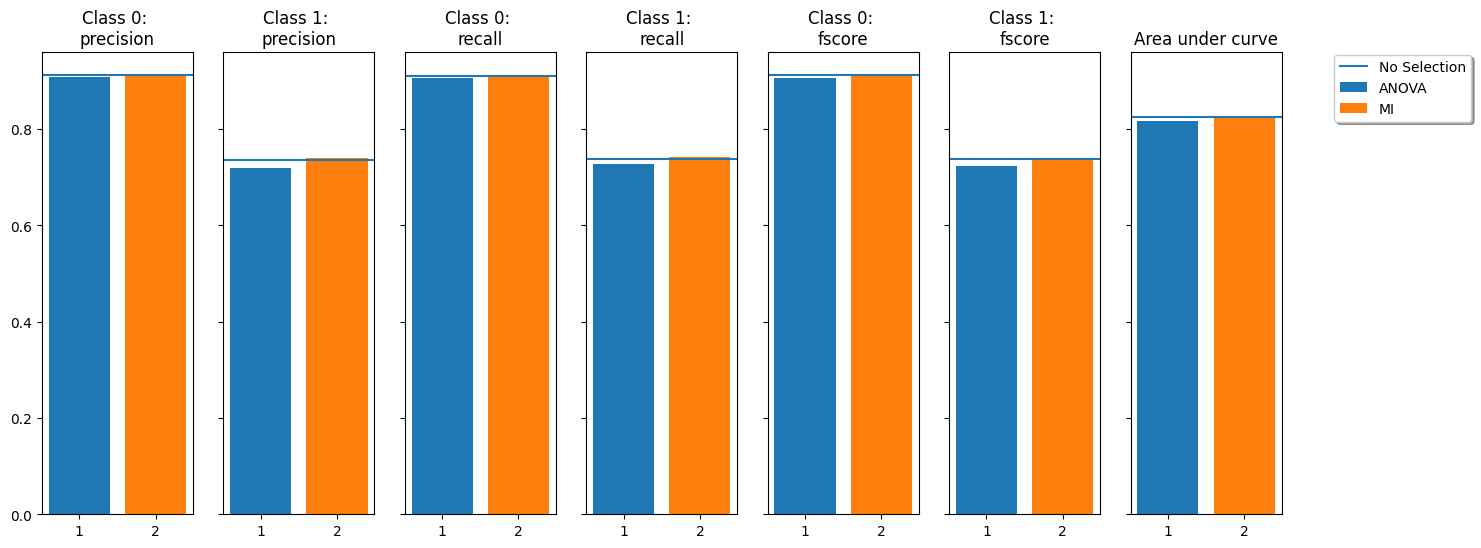

In [107]:
evaluate_method(results, 'filter')

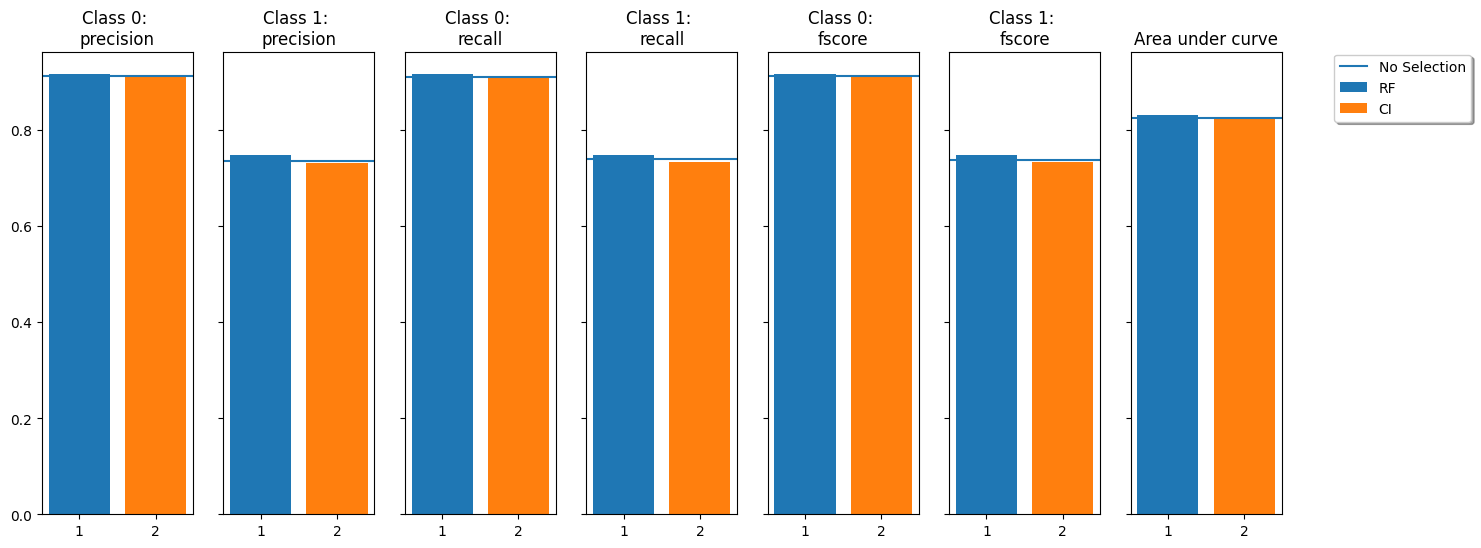

In [108]:
evaluate_method(results, 'wrapper')

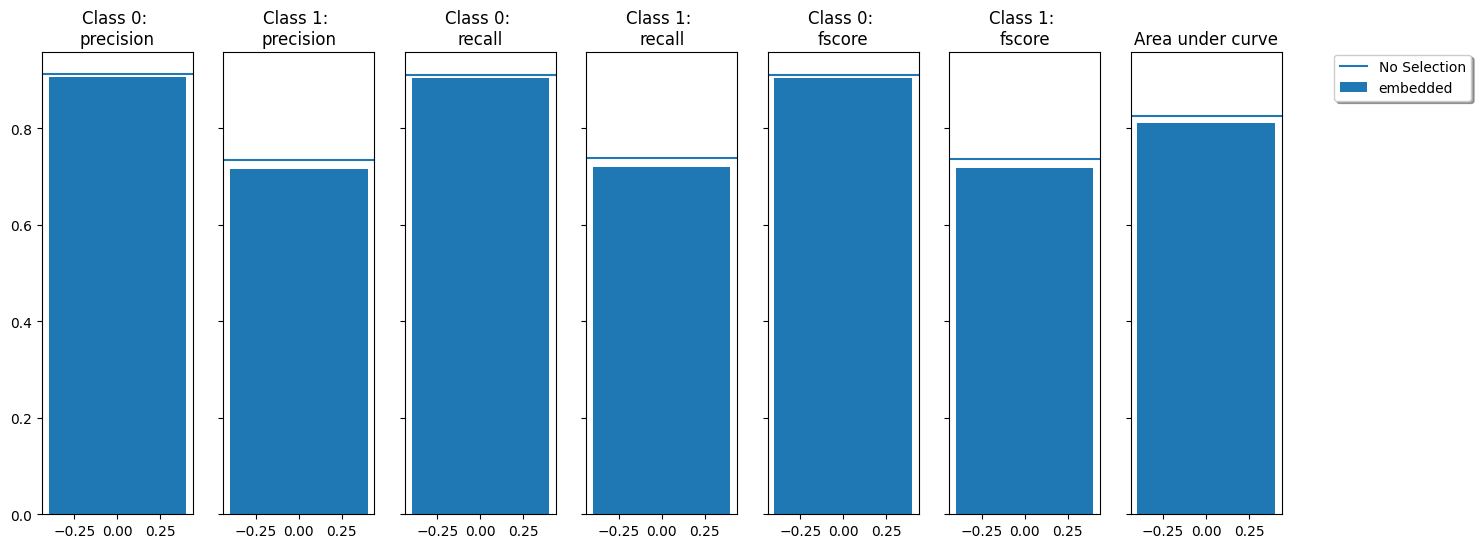

In [109]:
evaluate_method(results, 'embedded')

##### Random forest

In [110]:
model = RandomForestClassifier()
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method : Select from Model, Random Forest ------
Technique: RF
Technique: CI
------ Embedded method ------


In [111]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

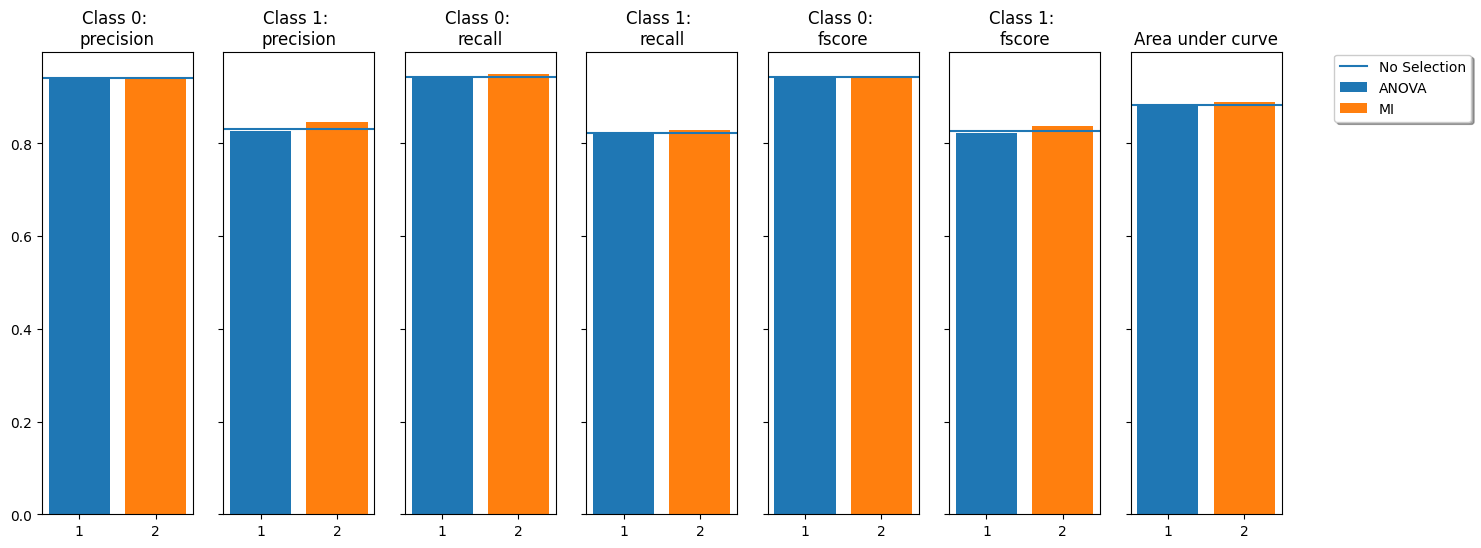

In [112]:
evaluate_method(results, 'filter')

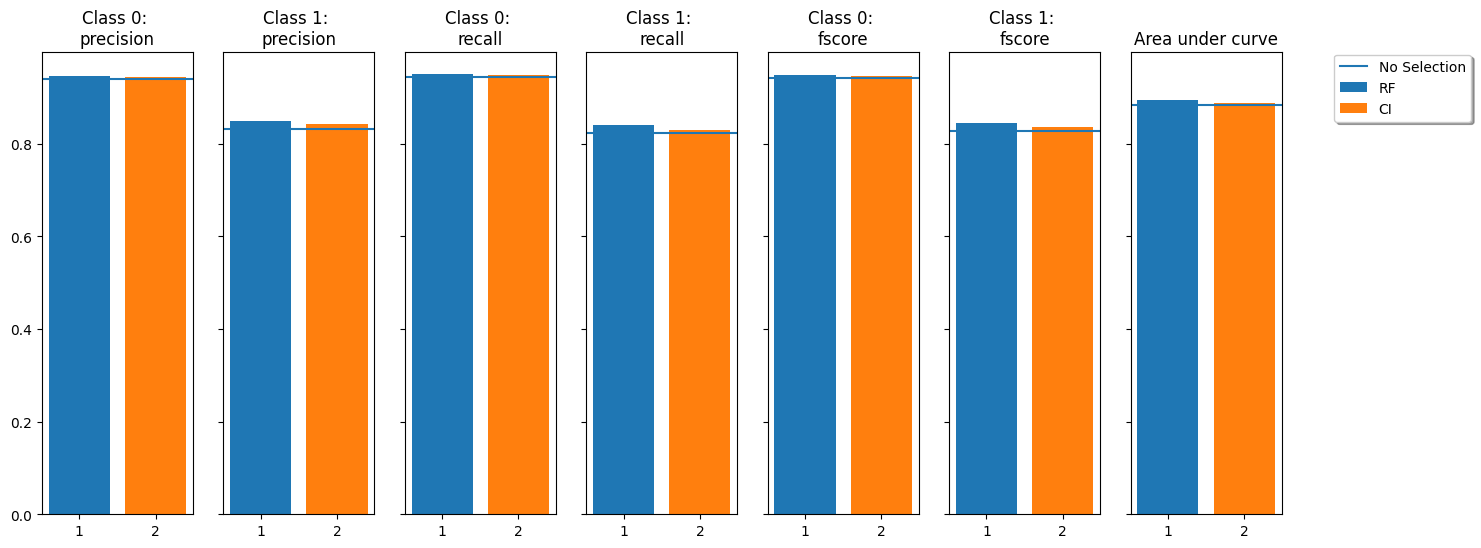

In [113]:
evaluate_method(results, 'wrapper')

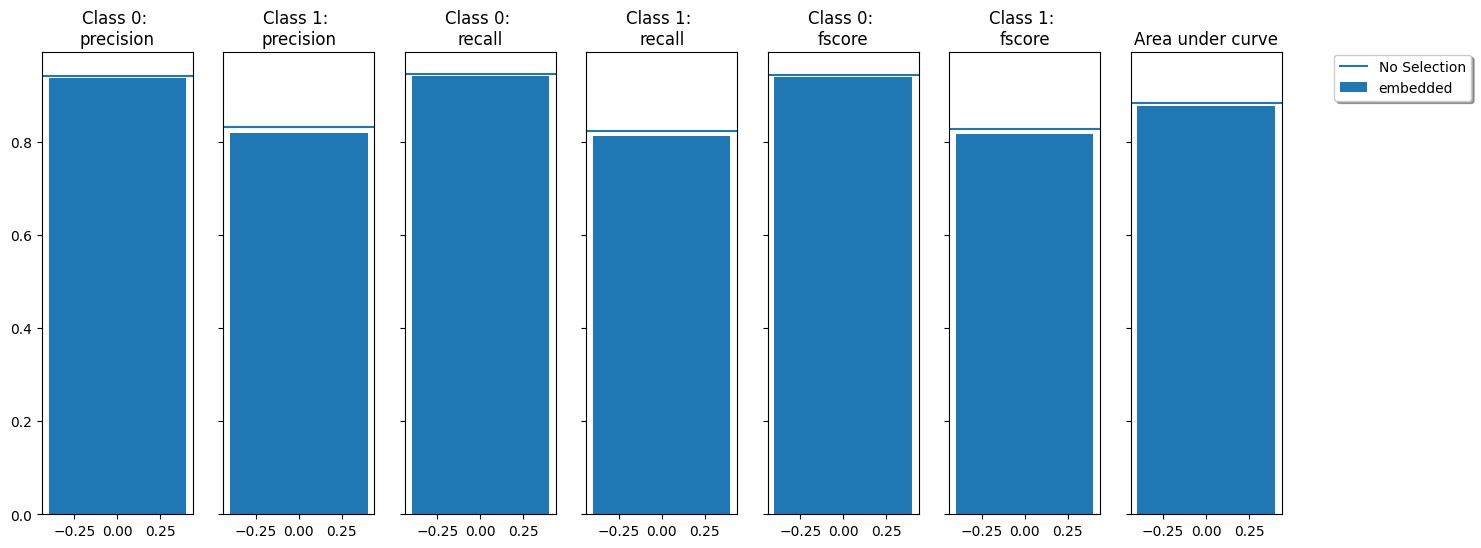

In [114]:
evaluate_method(results, 'embedded')

##### Logistic Regression

In [115]:
model = LogisticRegression()
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method : Select from Model, Random Forest ------
Technique: RF
Technique: CI
------ Embedded method ------


In [116]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

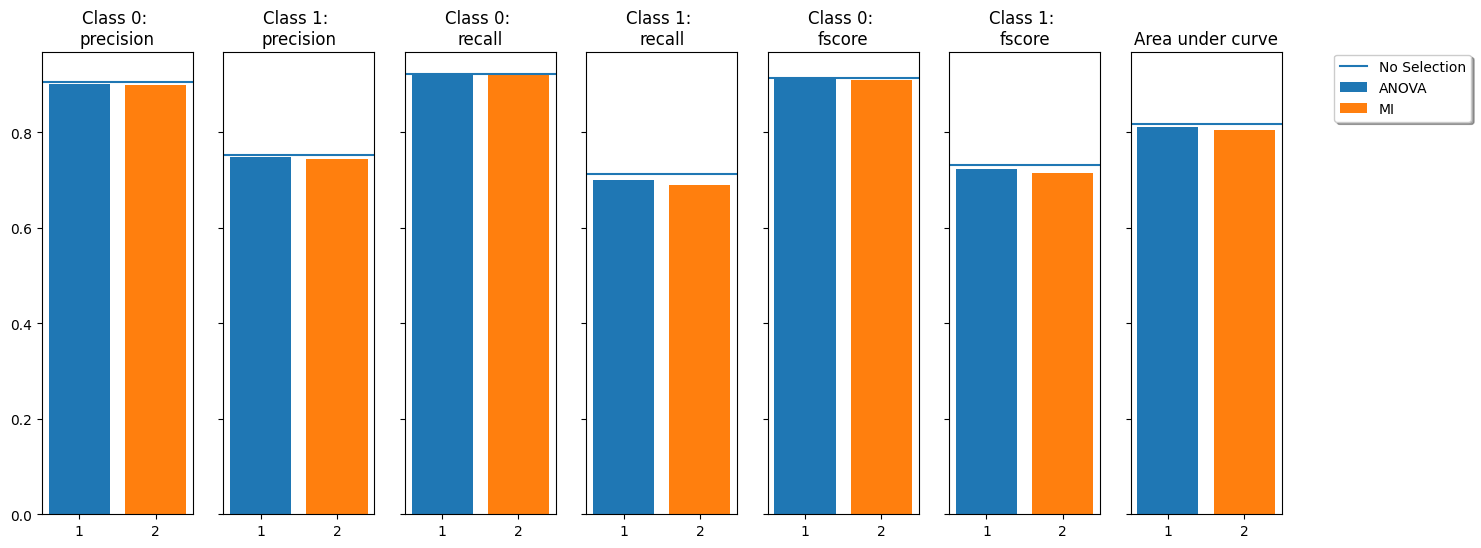

In [117]:
evaluate_method(results, 'filter')

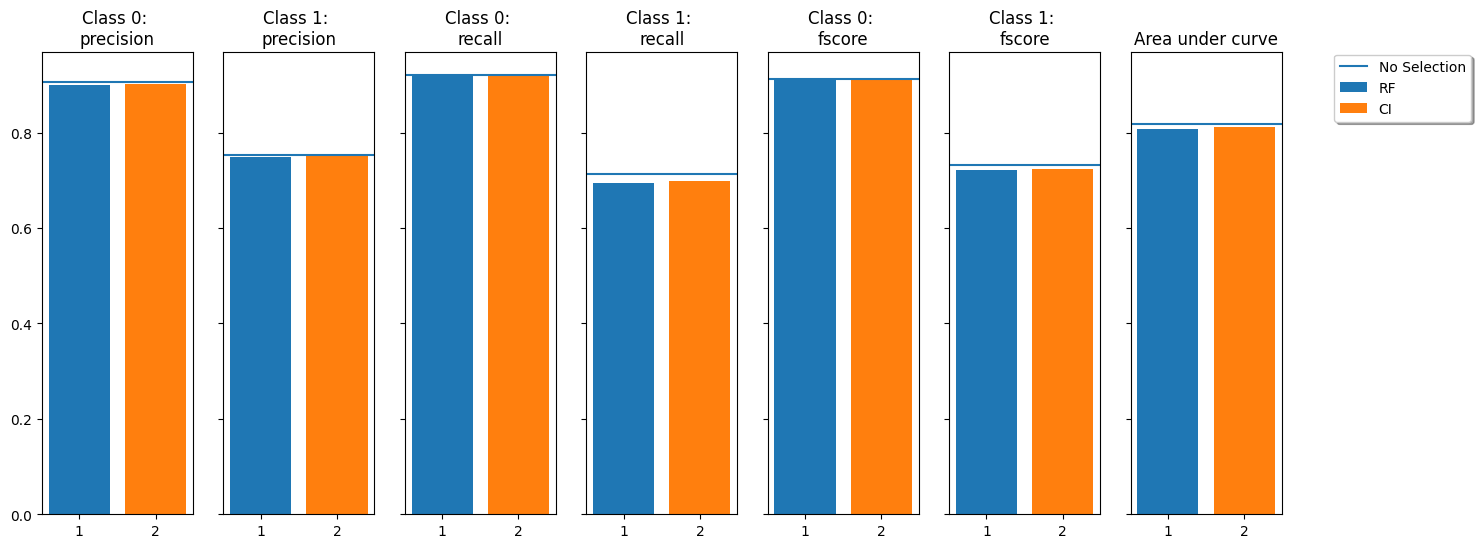

In [118]:
evaluate_method(results, 'wrapper')

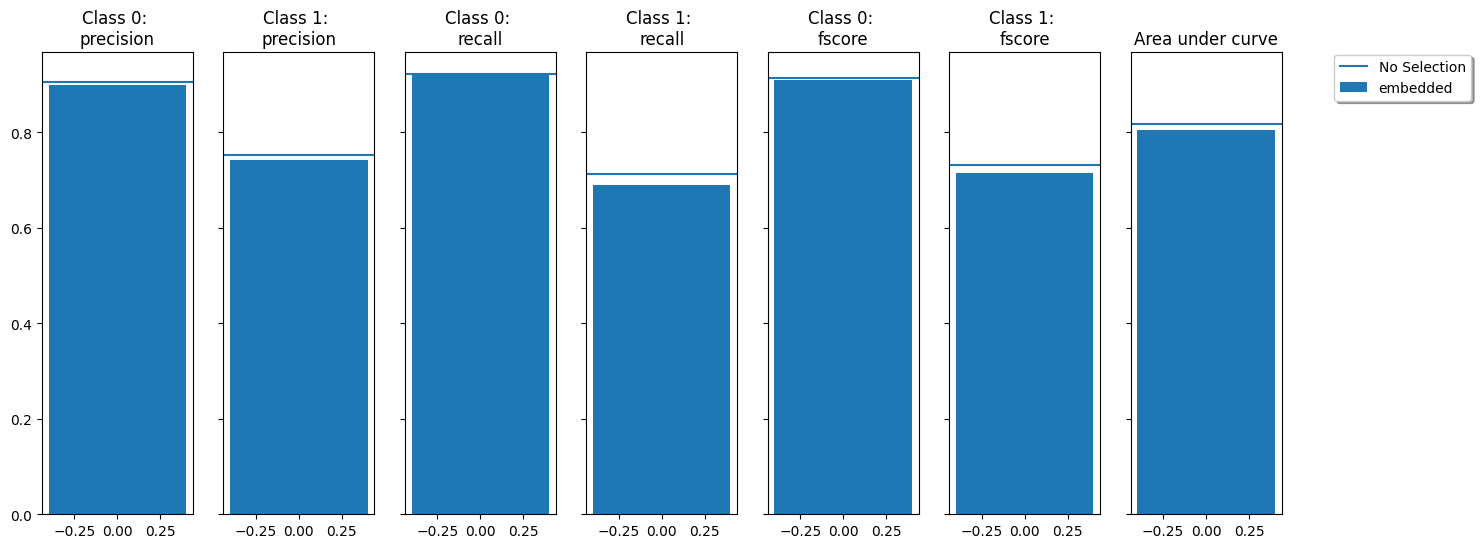

In [119]:
evaluate_method(results, 'embedded')

##### SGD Classifier

In [120]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss="hinge", penalty="l1", max_iter=1000)
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method : Select from Model, Random Forest ------
Technique: RF
Technique: CI
------ Embedded method ------


In [121]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

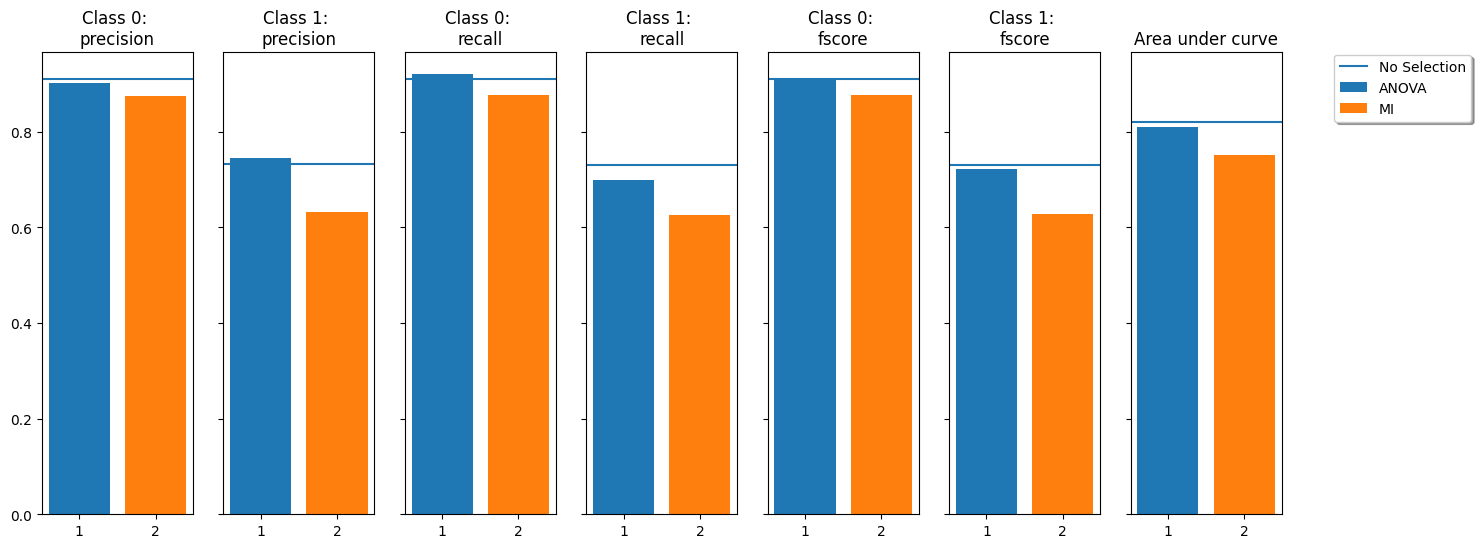

In [122]:
evaluate_method(results, 'filter')

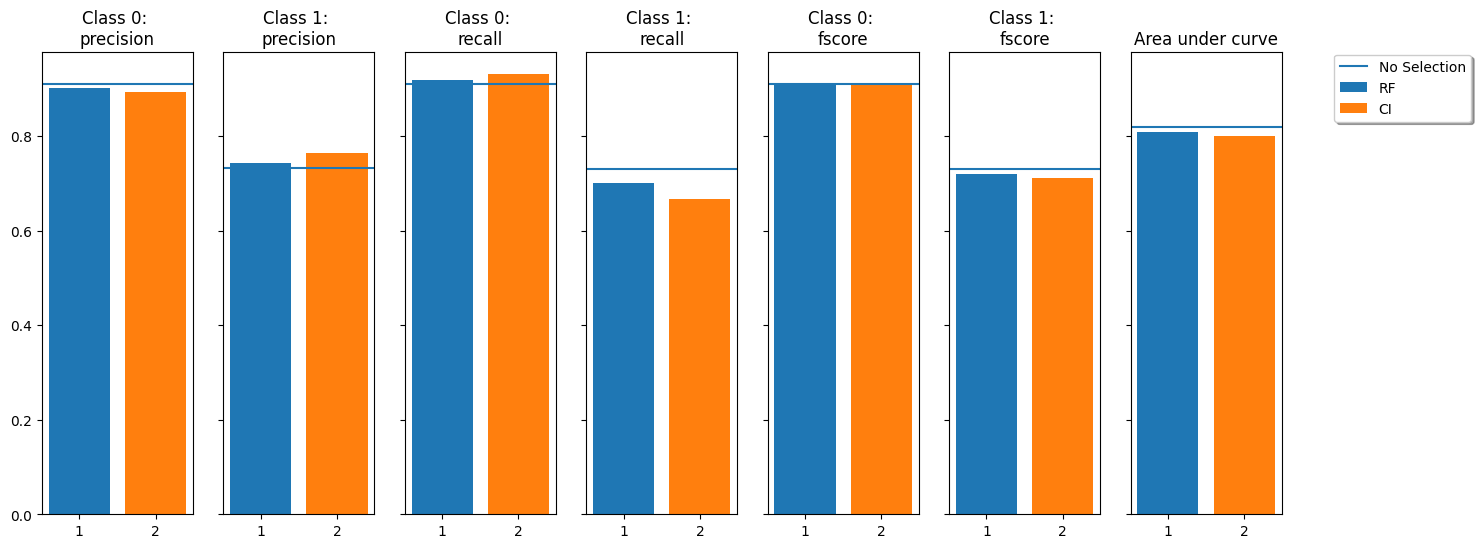

In [123]:
evaluate_method(results, 'wrapper')

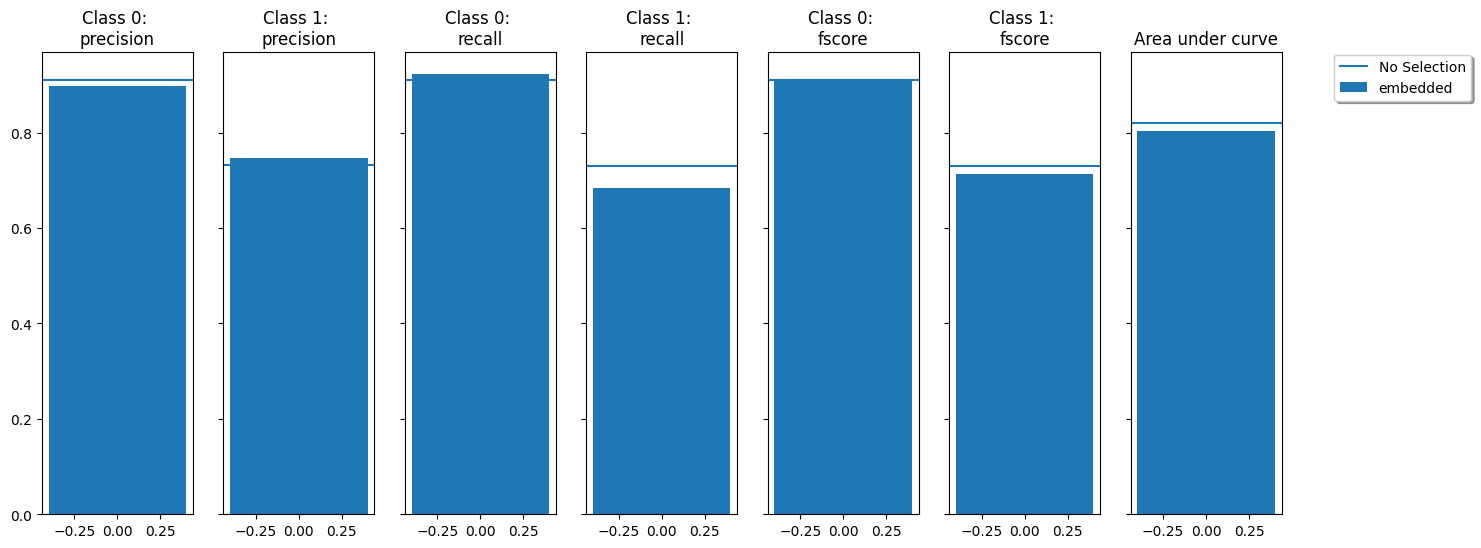

In [124]:
evaluate_method(results, 'embedded')

##### KNN

In [125]:
model = KNeighborsClassifier()
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method : Select from Model, Random Forest ------
Technique: RF
Technique: CI
------ Embedded method ------


In [126]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

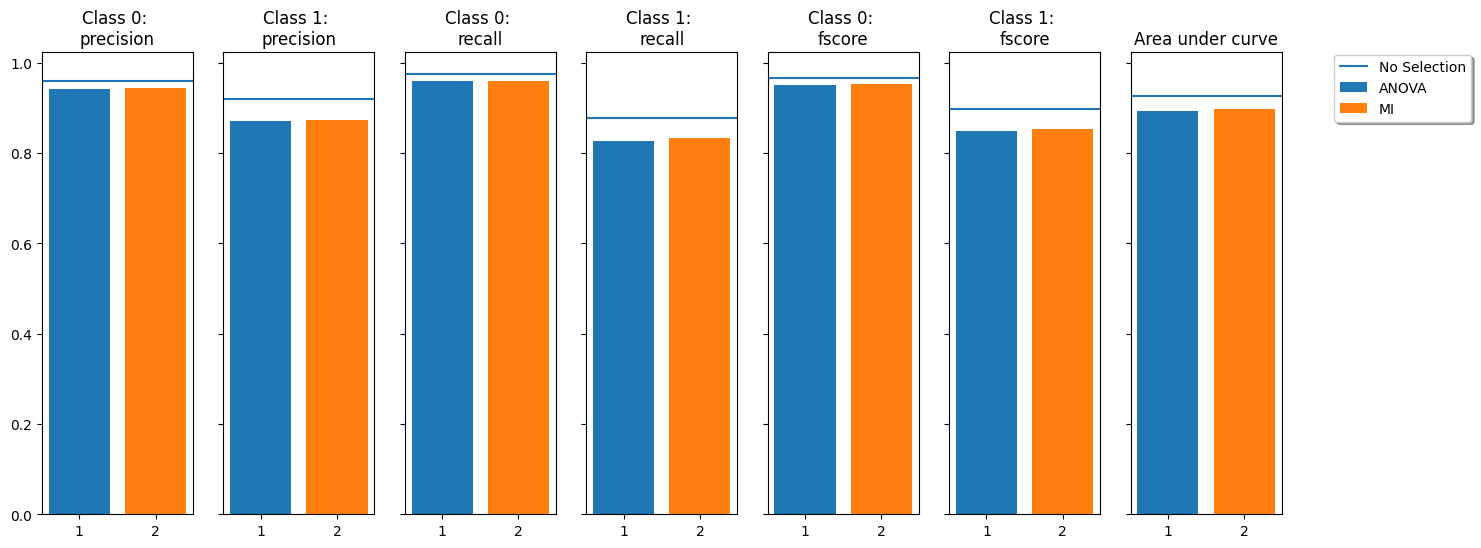

In [127]:
evaluate_method(results, 'filter')

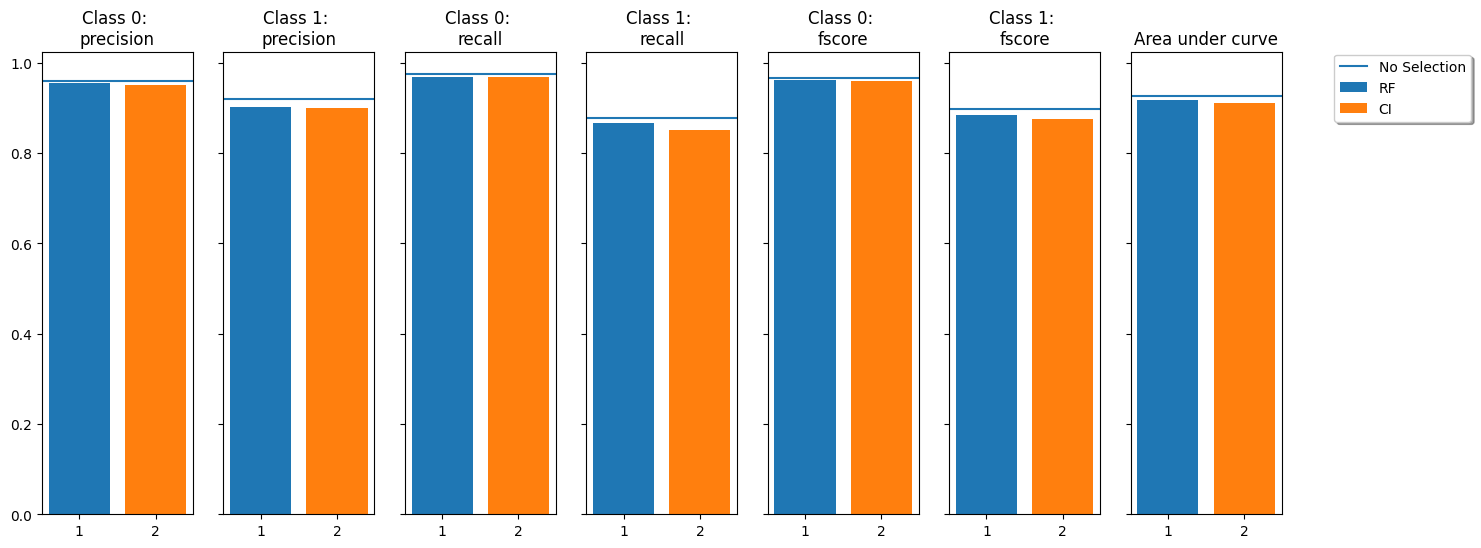

In [128]:
evaluate_method(results, 'wrapper')

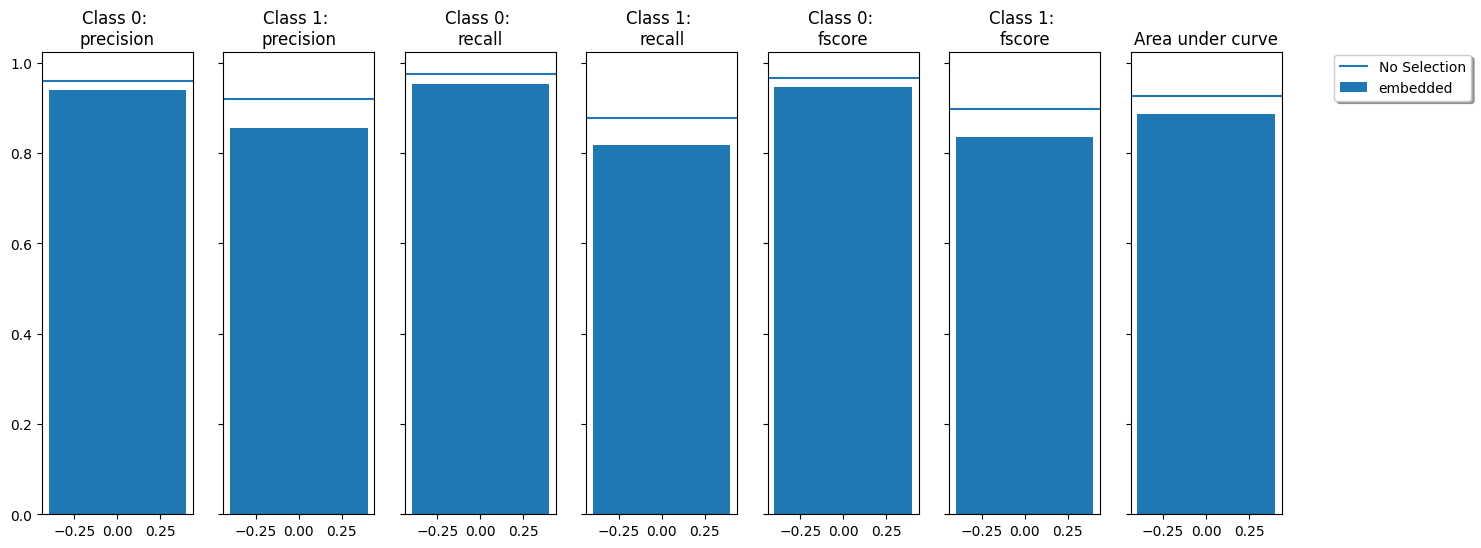

In [129]:
evaluate_method(results, 'embedded')

##### AdaBoost

In [130]:
model = AdaBoostClassifier(algorithm="SAMME")
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method : Select from Model, Random Forest ------
Technique: RF
Technique: CI
------ Embedded method ------


In [131]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

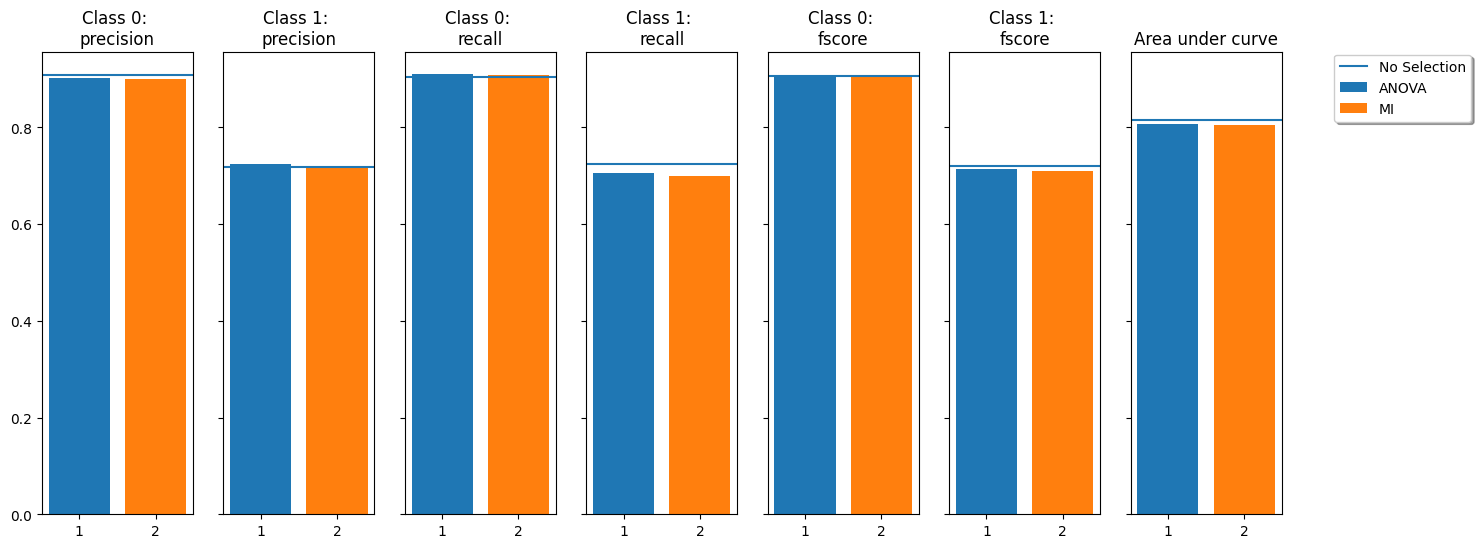

In [132]:
evaluate_method(results, 'filter')

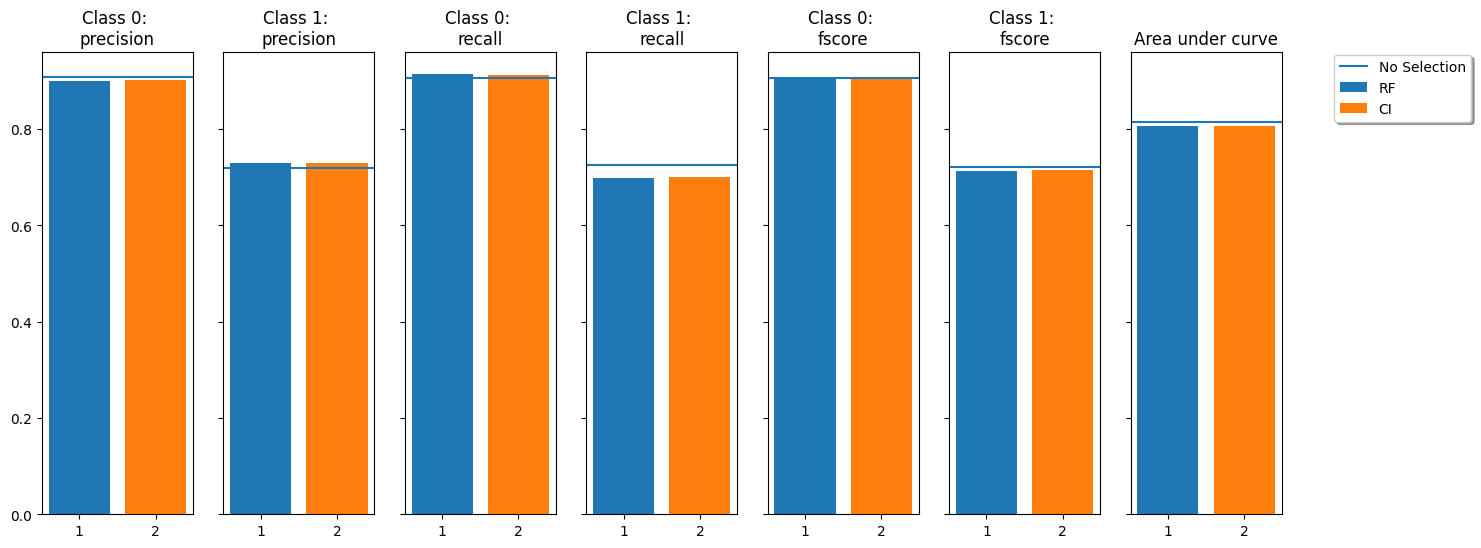

In [133]:
evaluate_method(results, 'wrapper')

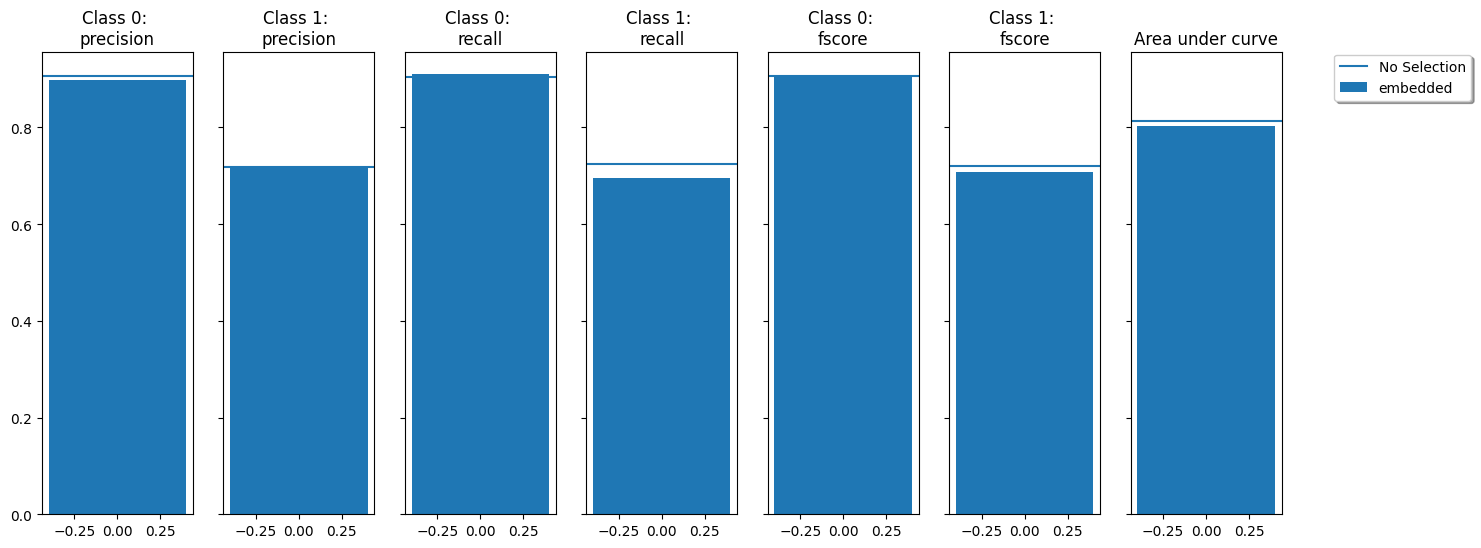

In [134]:
evaluate_method(results, 'embedded')

##### Simple neural network

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500)
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method :  ------
Technique: RF
Technique: CI
------ Embedded method ------


In [ ]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

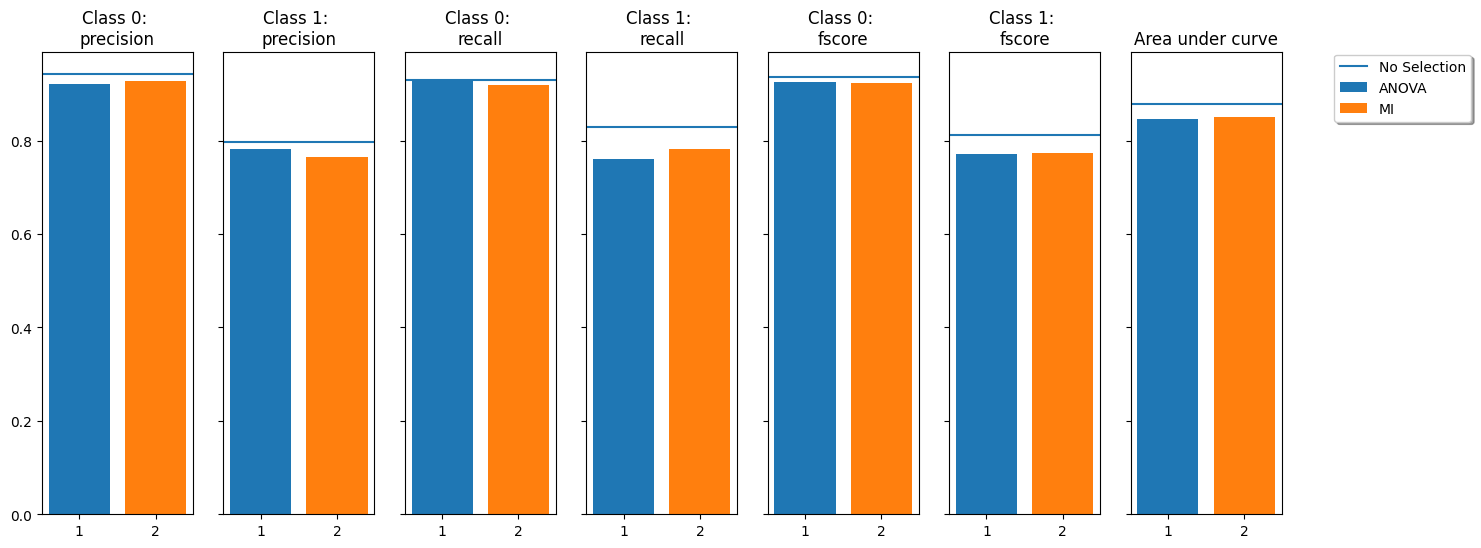

In [ ]:
evaluate_method(results, 'filter')

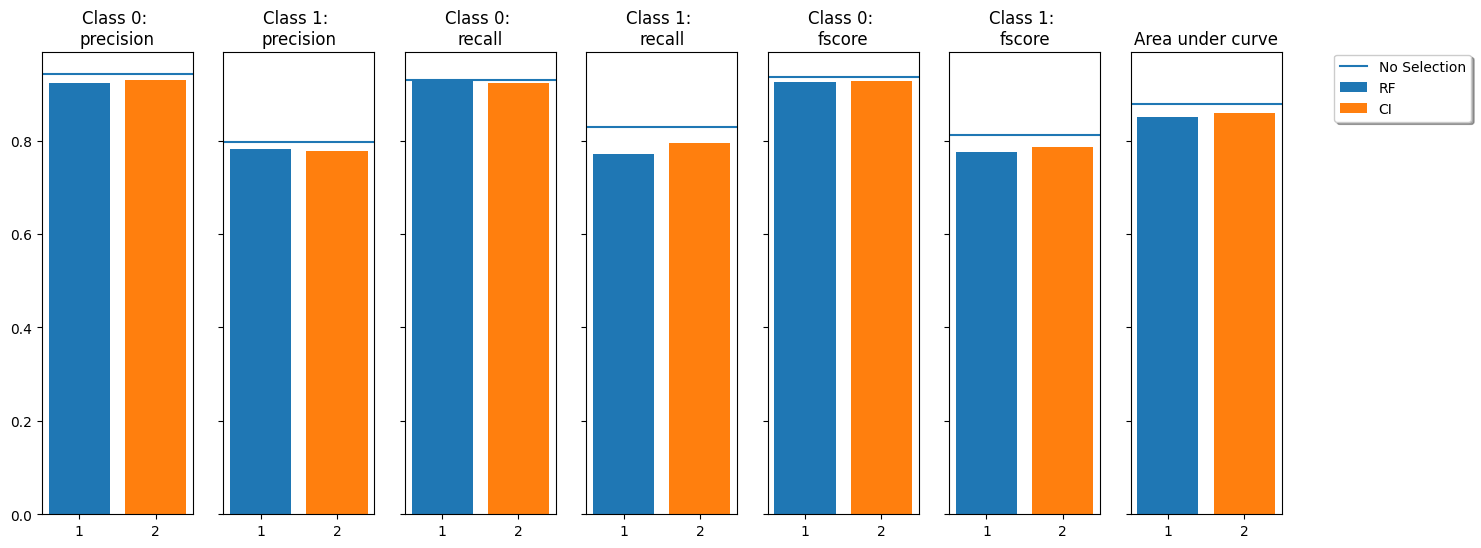

In [ ]:
evaluate_method(results, 'wrapper')

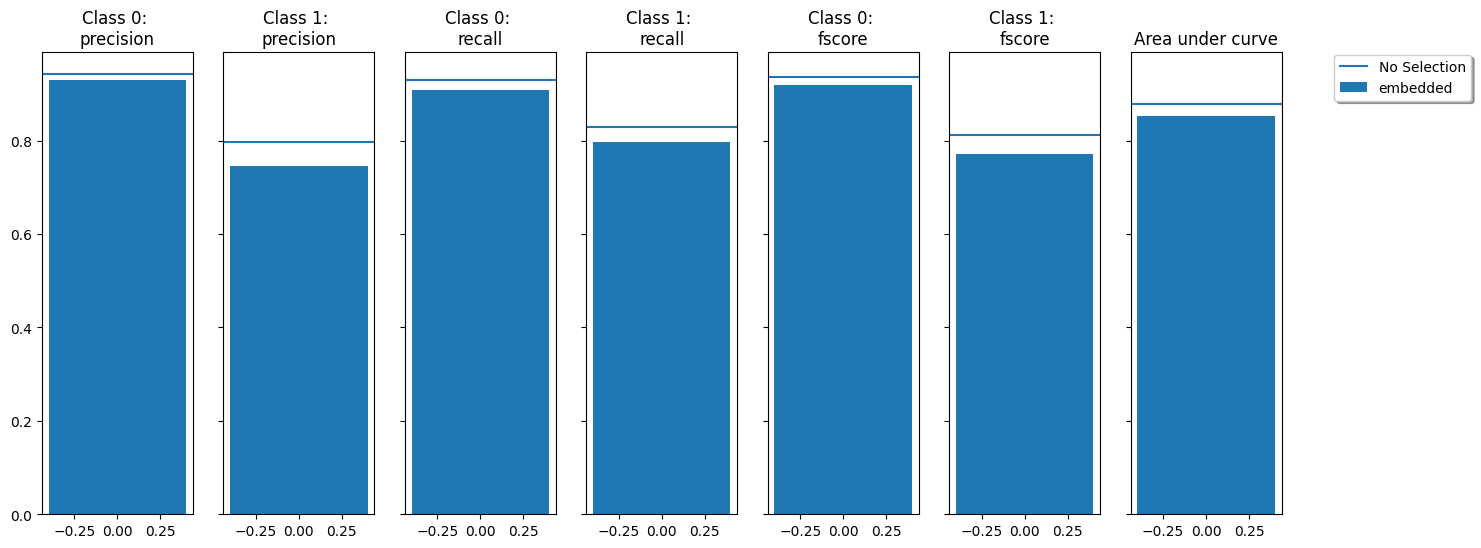

In [ ]:
evaluate_method(results, 'embedded')

### Evaluación de resultados con 100 características

##### Decision Tree

In [ ]:
model =  DecisionTreeClassifier()
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method :  ------
Technique: RF
Technique: CI
------ Embedded method ------


In [ ]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

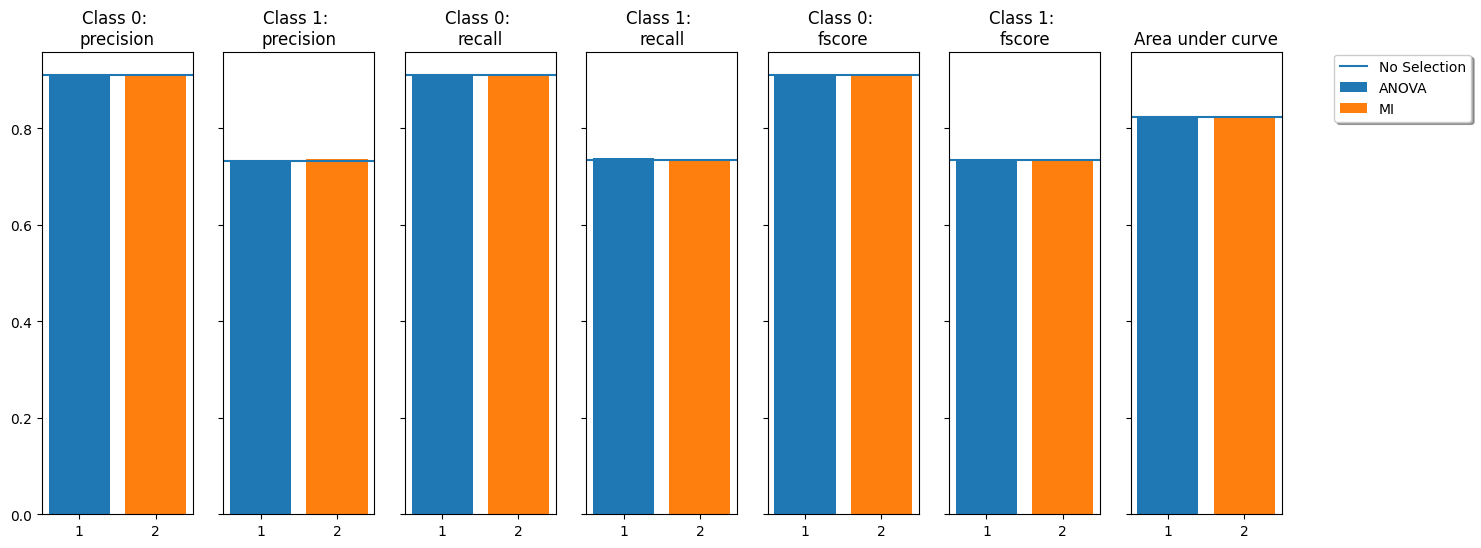

In [ ]:
evaluate_method(results, 'filter')

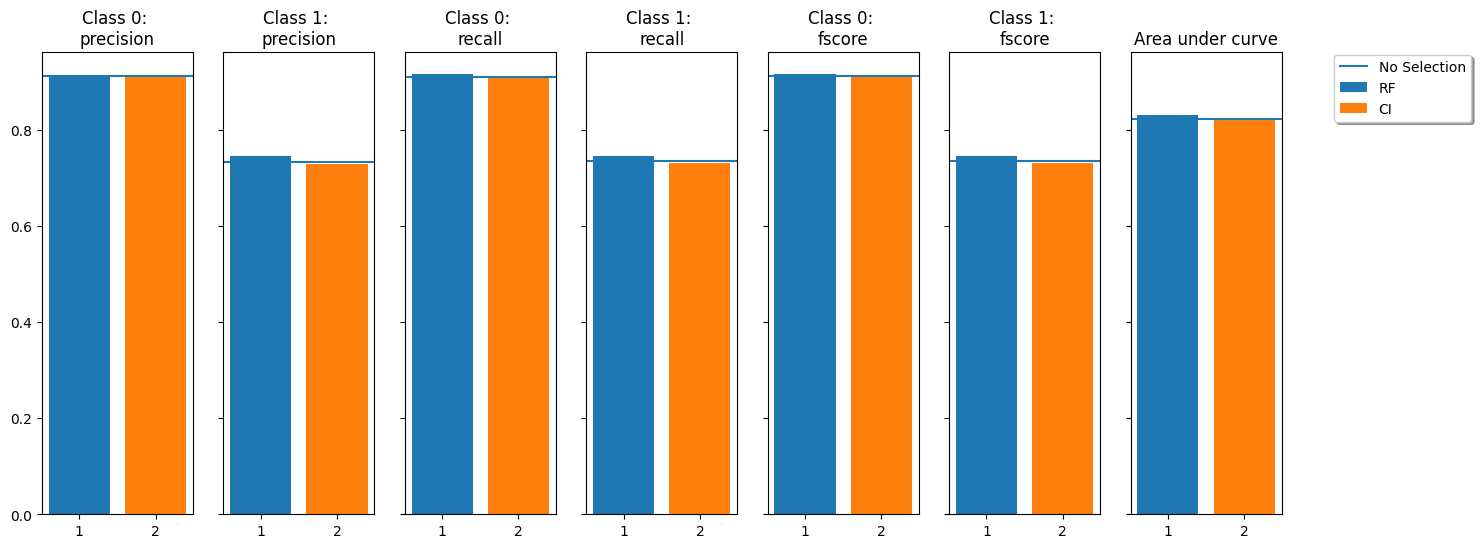

In [ ]:
evaluate_method(results, 'wrapper')

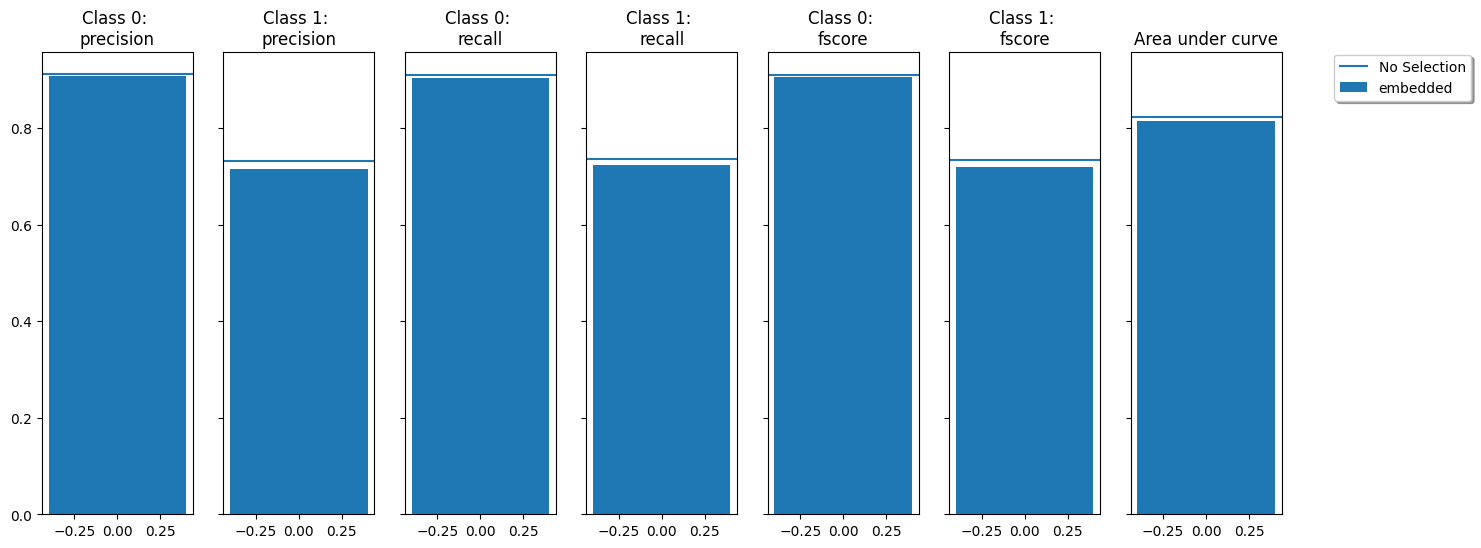

In [ ]:
evaluate_method(results, 'embedded')

##### Random forest

In [ ]:
model = RandomForestClassifier()
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method :  ------
Technique: RF
Technique: CI
------ Embedded method ------


In [ ]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

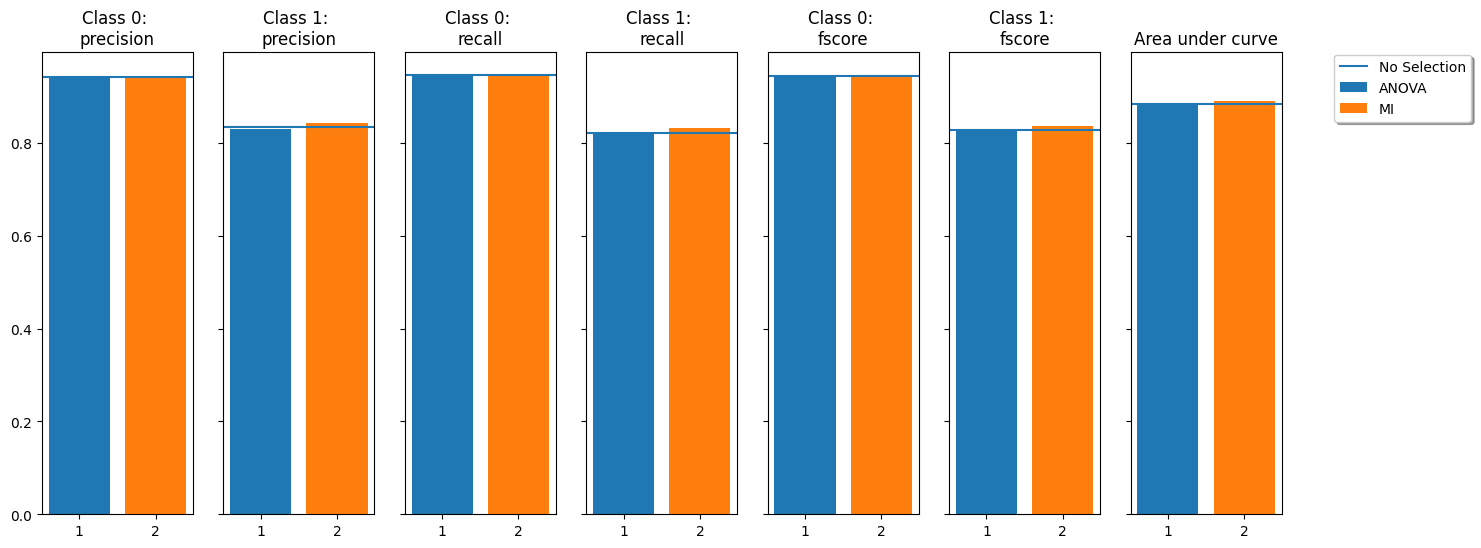

In [ ]:
evaluate_method(results, 'filter')

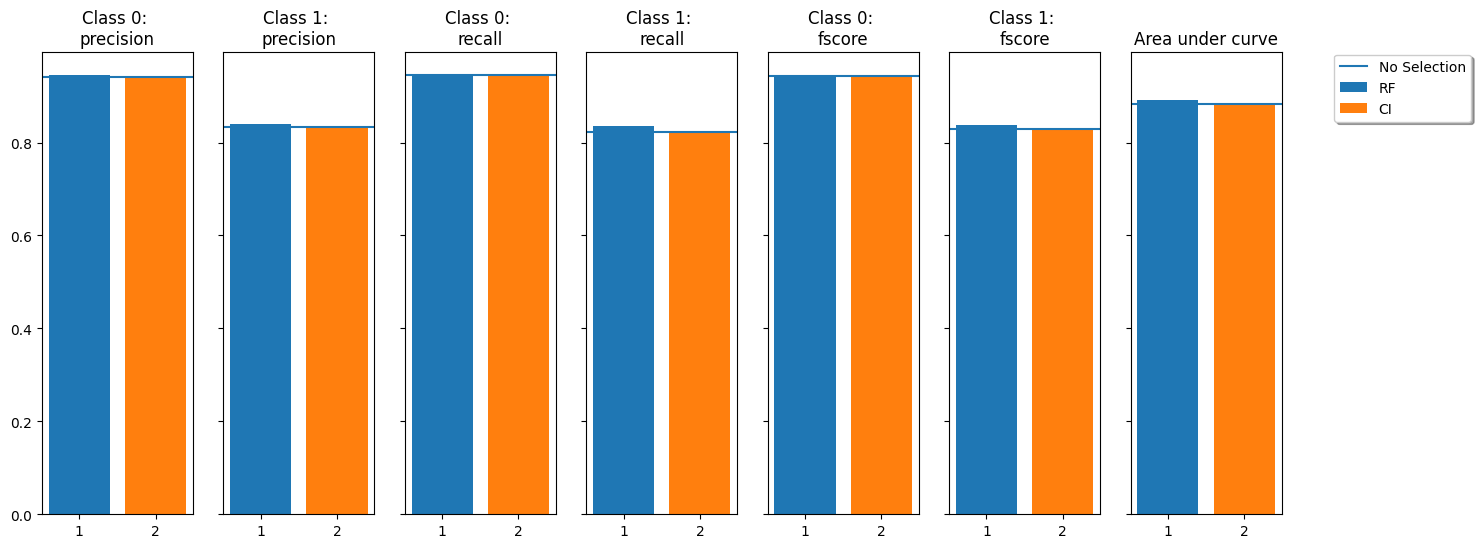

In [ ]:
evaluate_method(results, 'wrapper')

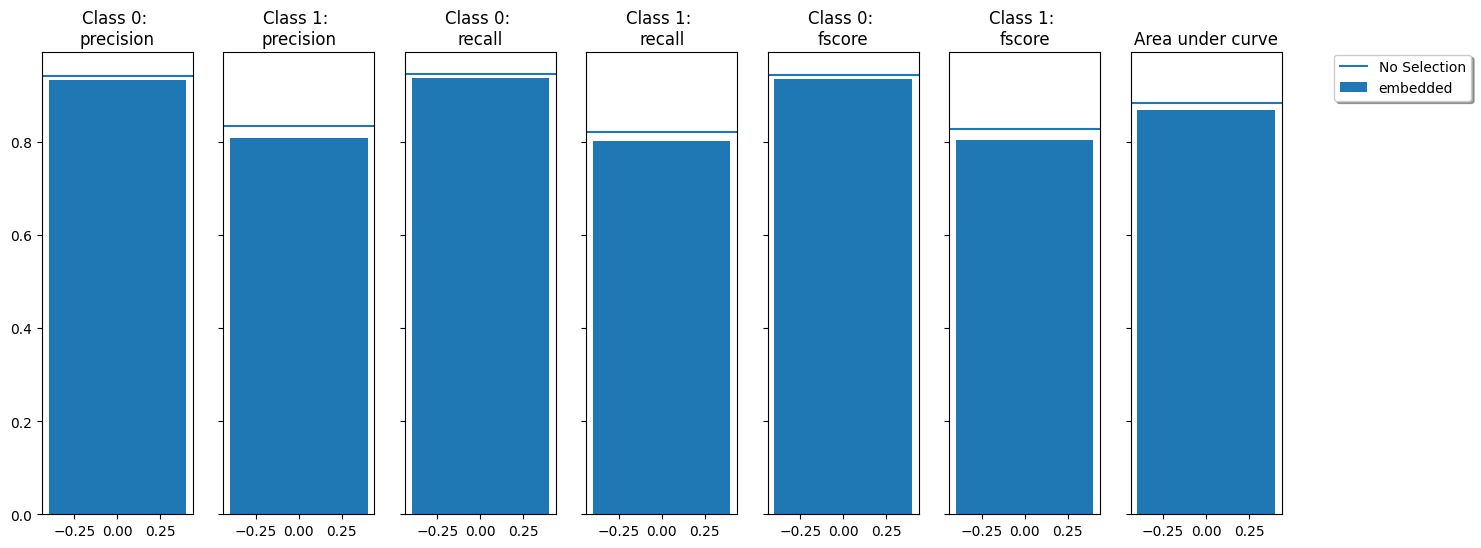

In [ ]:
evaluate_method(results, 'embedded')

##### Logistic Regression

In [ ]:
model = LogisticRegression()
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method :  ------
Technique: RF
Technique: CI
------ Embedded method ------


In [ ]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

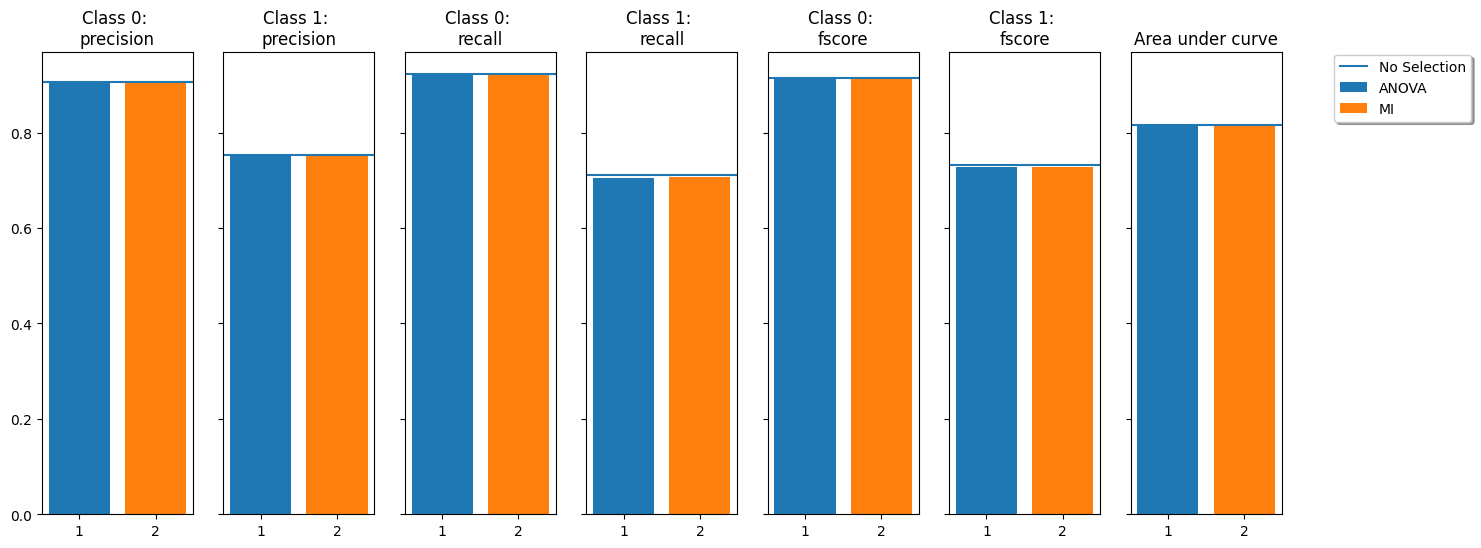

In [ ]:
evaluate_method(results, 'filter')

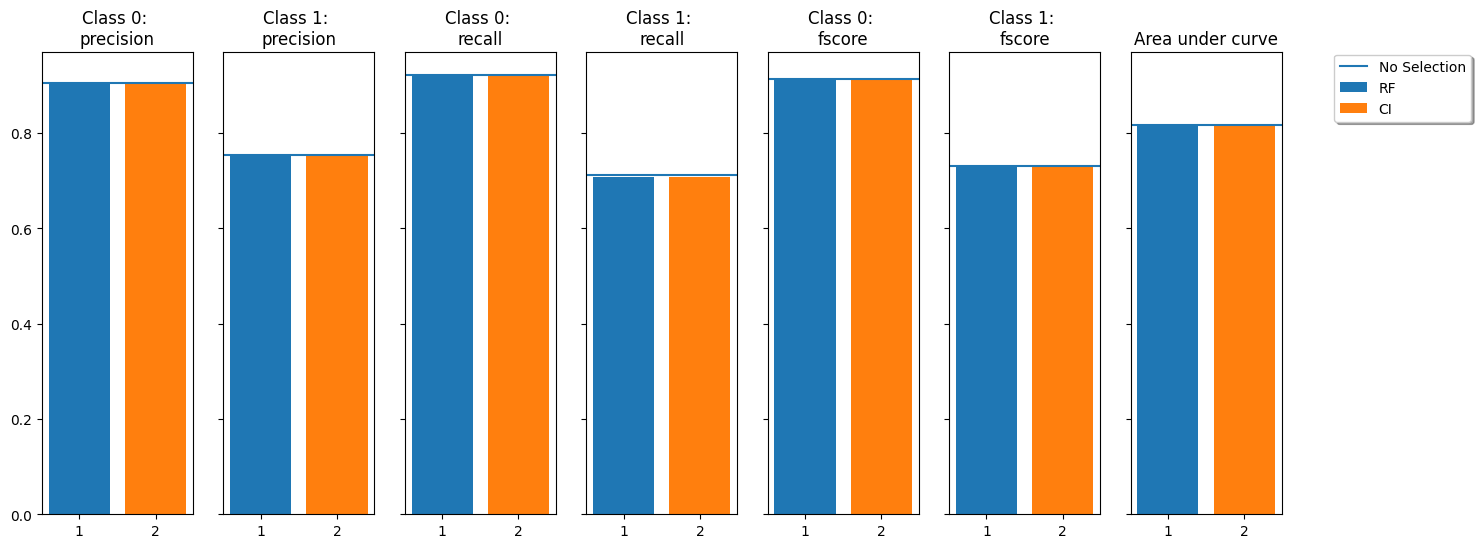

In [ ]:
evaluate_method(results, 'wrapper')

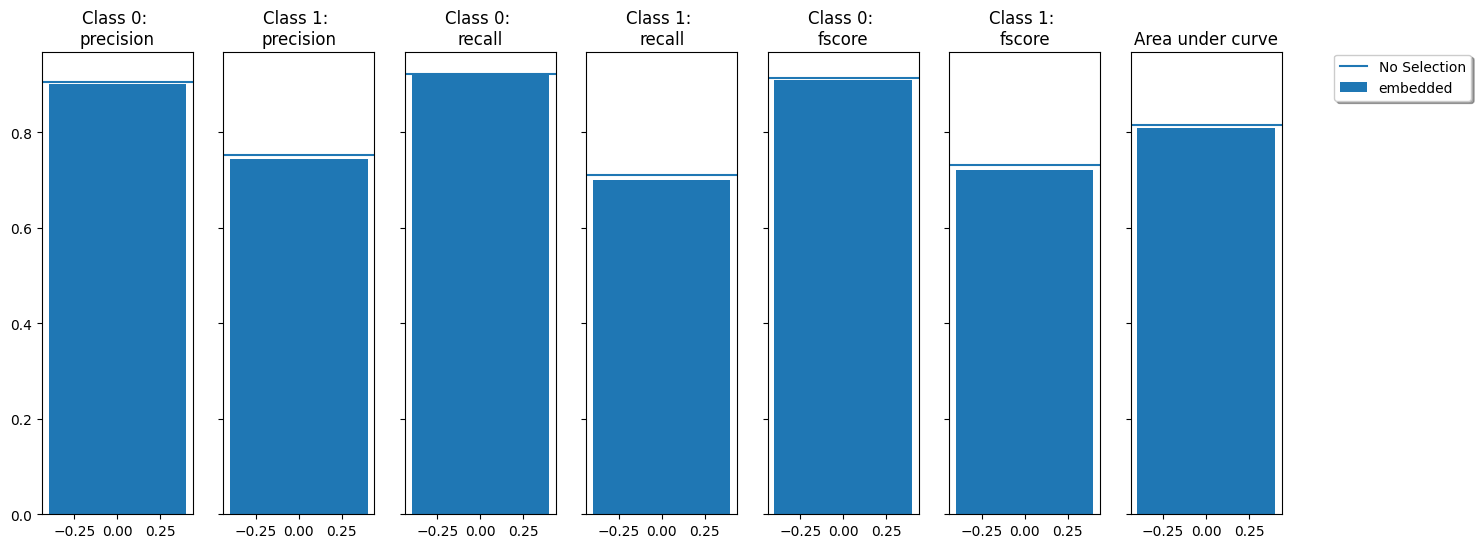

In [ ]:
evaluate_method(results, 'embedded')

##### SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss="hinge", penalty="l1", max_iter=1000)
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method :  ------
Technique: RF
Technique: CI
------ Embedded method ------


In [ ]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

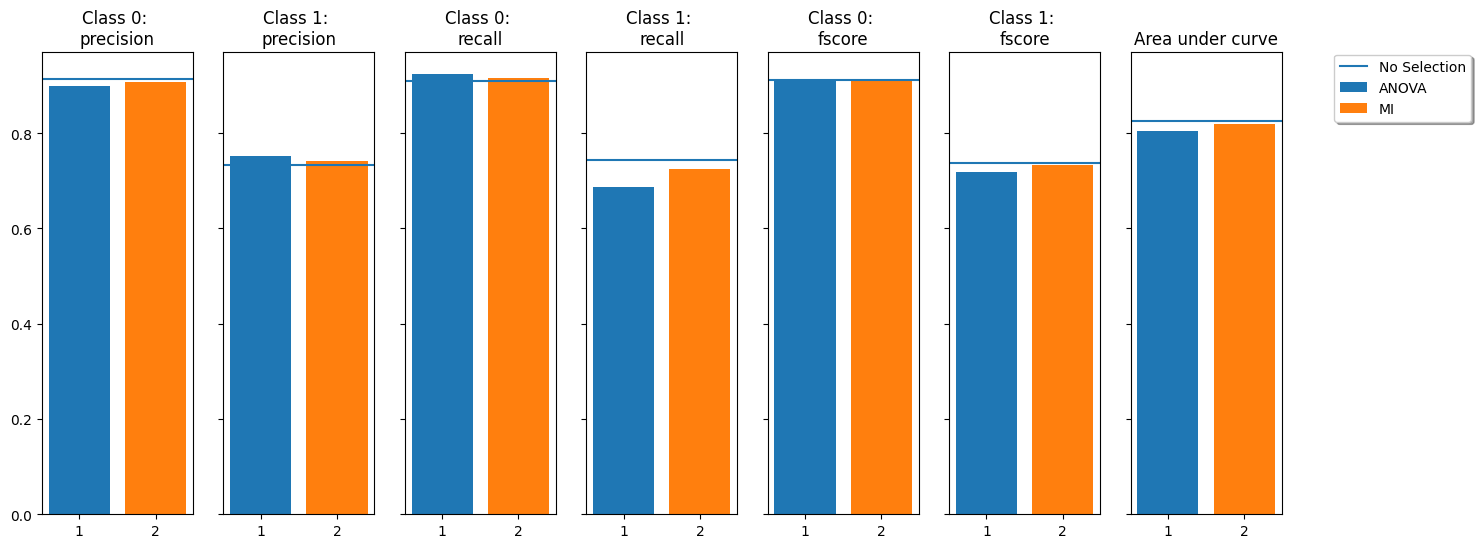

In [ ]:
evaluate_method(results, 'filter')

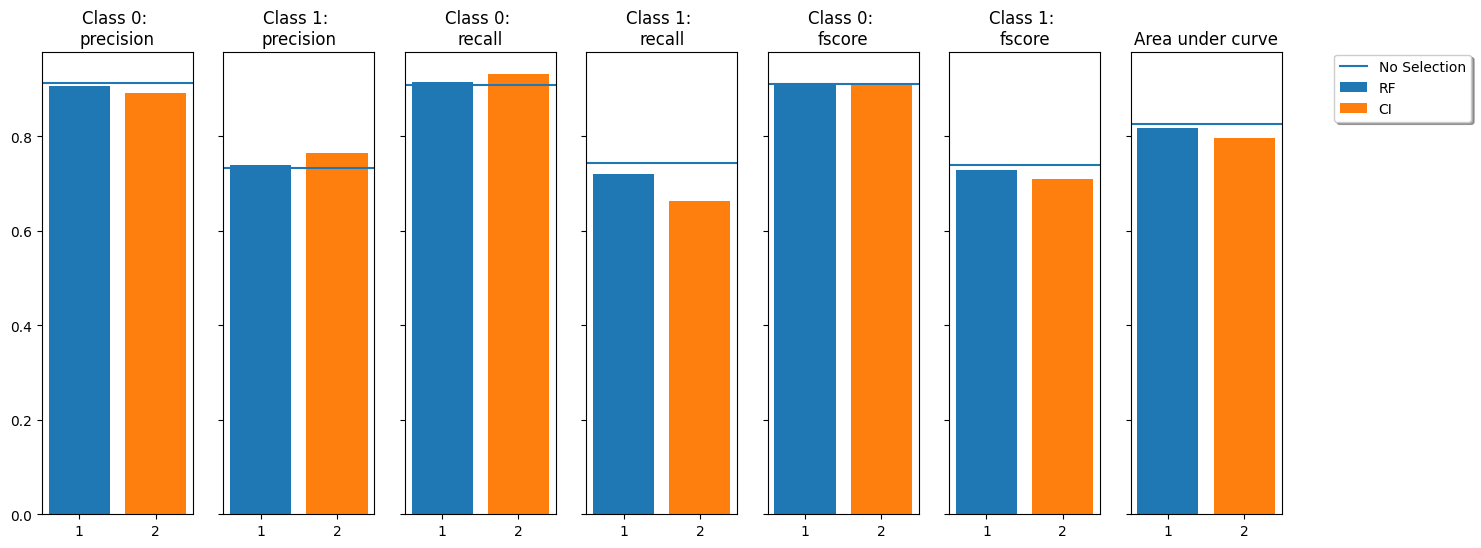

In [ ]:
evaluate_method(results, 'wrapper')

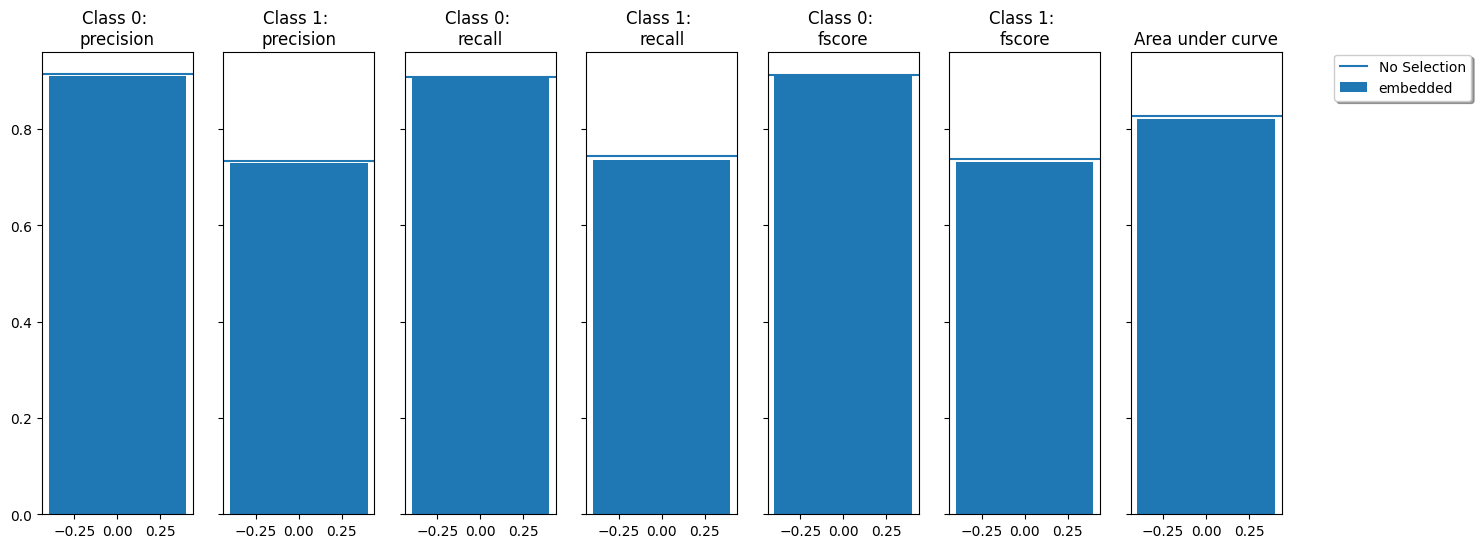

In [ ]:
evaluate_method(results, 'embedded')

##### KNN

In [ ]:
model = KNeighborsClassifier()
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method :  ------
Technique: RF
Technique: CI
------ Embedded method ------


In [ ]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

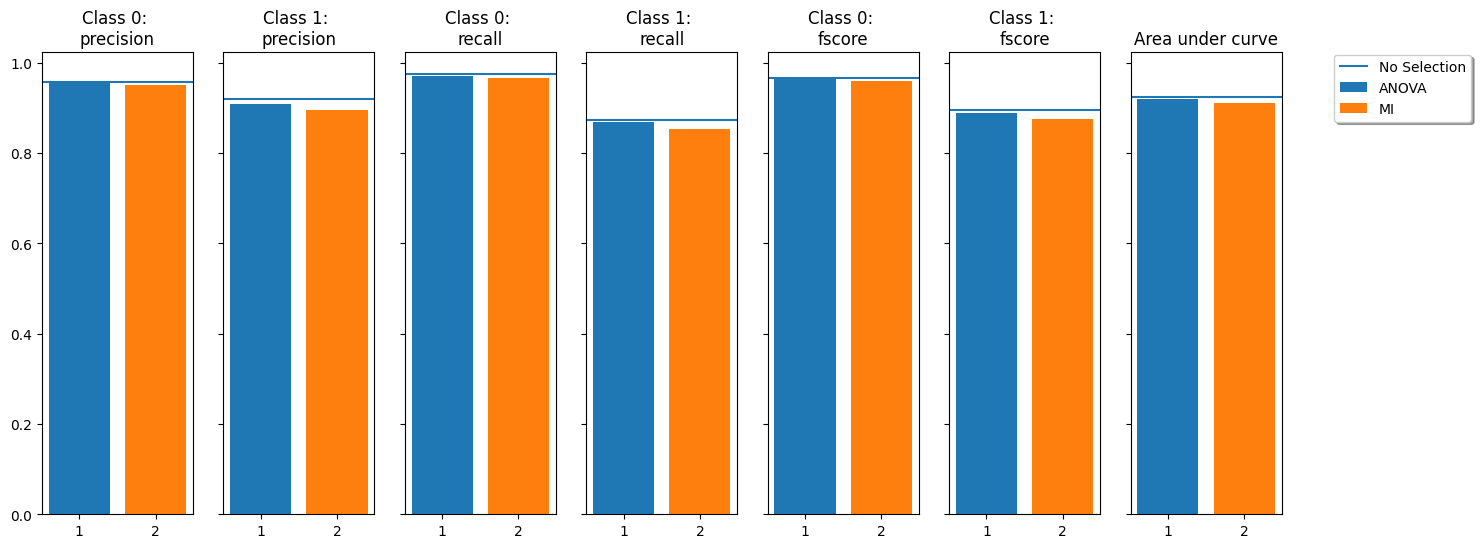

In [ ]:
evaluate_method(results, 'filter')

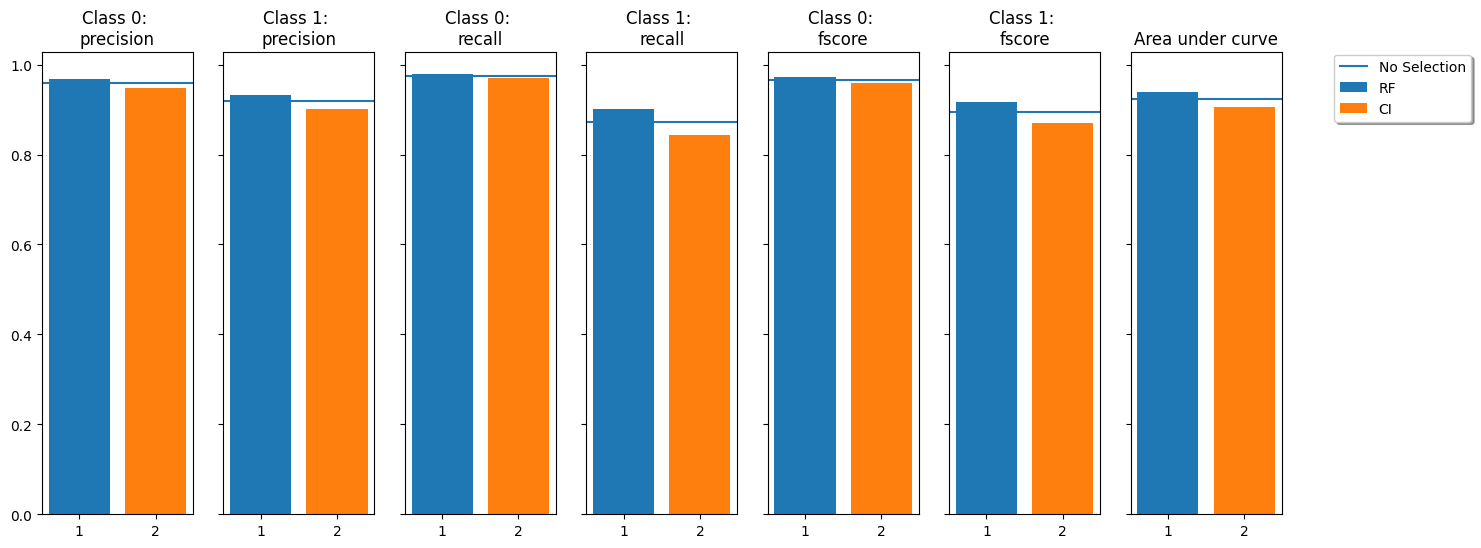

In [ ]:
evaluate_method(results, 'wrapper')

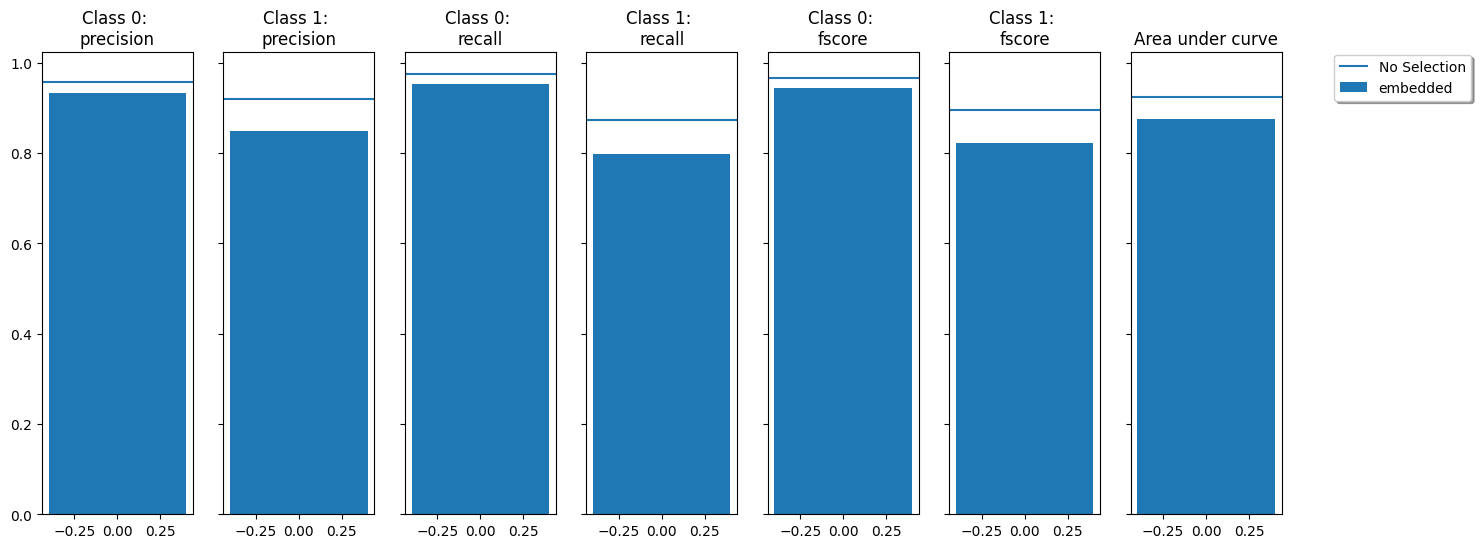

In [ ]:
evaluate_method(results, 'embedded')

##### AdaBoost

In [ ]:
model = AdaBoostClassifier(algorithm="SAMME")
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method :  ------
Technique: RF
Technique: CI
------ Embedded method ------


In [ ]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

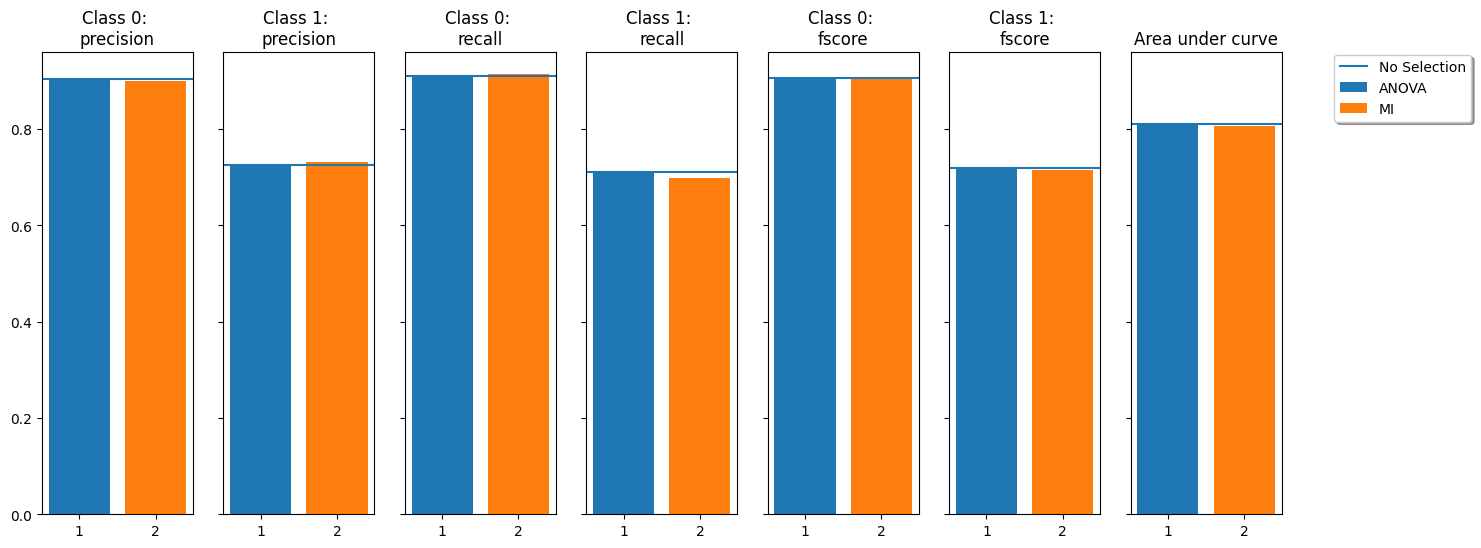

In [ ]:
evaluate_method(results, 'filter')

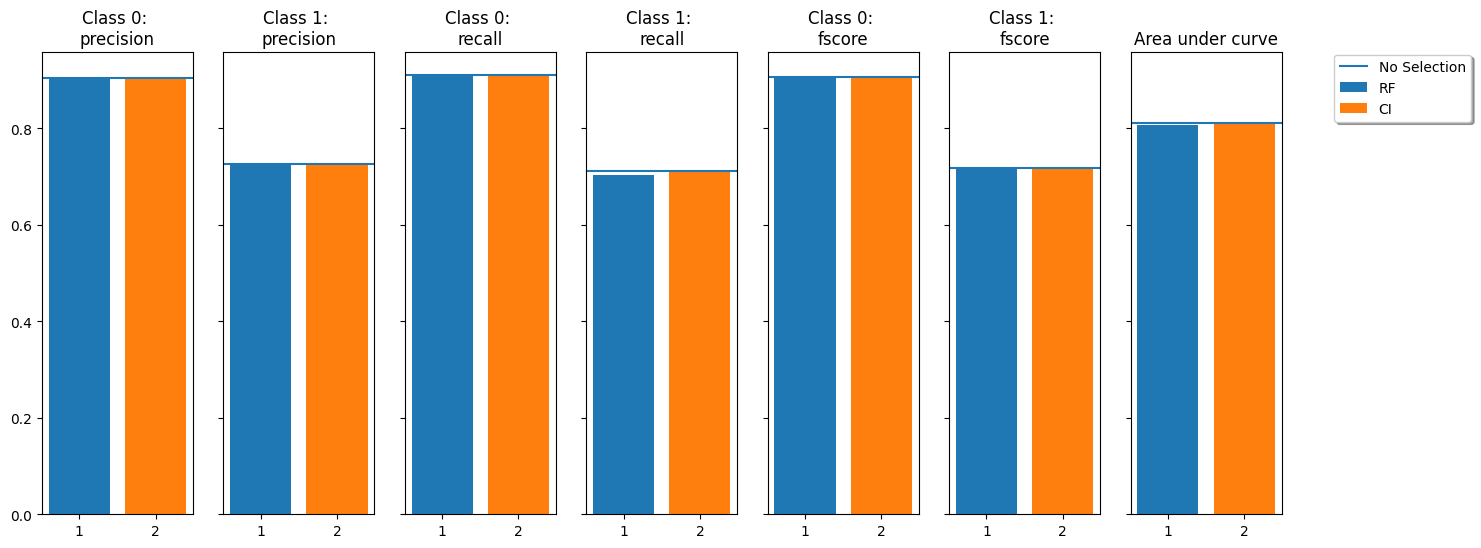

In [ ]:
evaluate_method(results, 'wrapper')

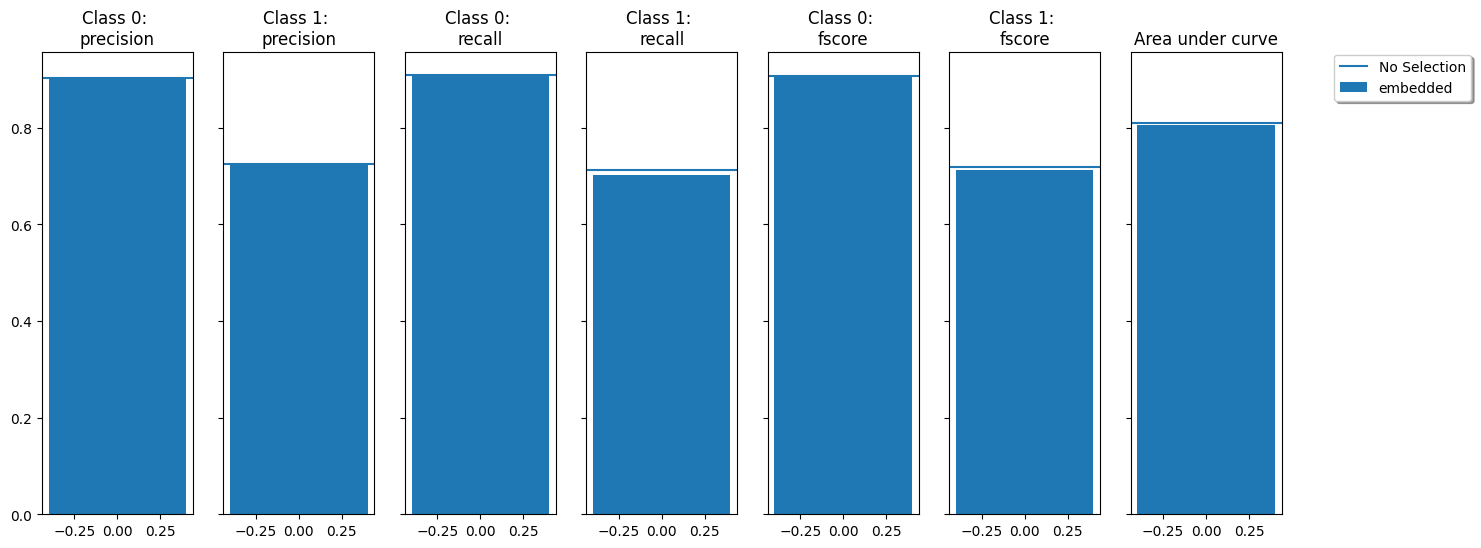

In [ ]:
evaluate_method(results, 'embedded')

##### Simple neural network

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500)
results = model_features_pipeline(X_train, X_test, y_train, y_test, model)

------ Filter method : ------
Technique: ANOVA
Technique: MI
------ Wrapper method :  ------
Technique: RF
Technique: CI
------ Embedded method ------


In [ ]:
results_no_feature_selection = model_no_feature_selection(X_train, X_test, y_train, y_test, model)
results['no_feature_selection'] = results_no_feature_selection

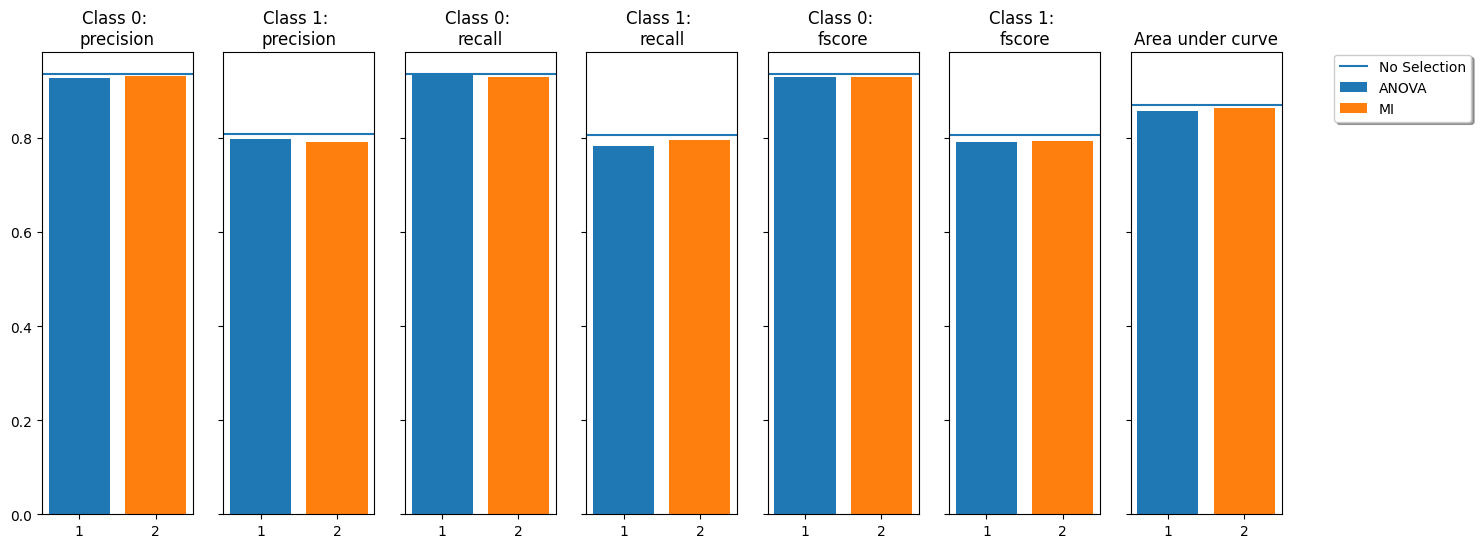

In [ ]:
evaluate_method(results, 'filter')

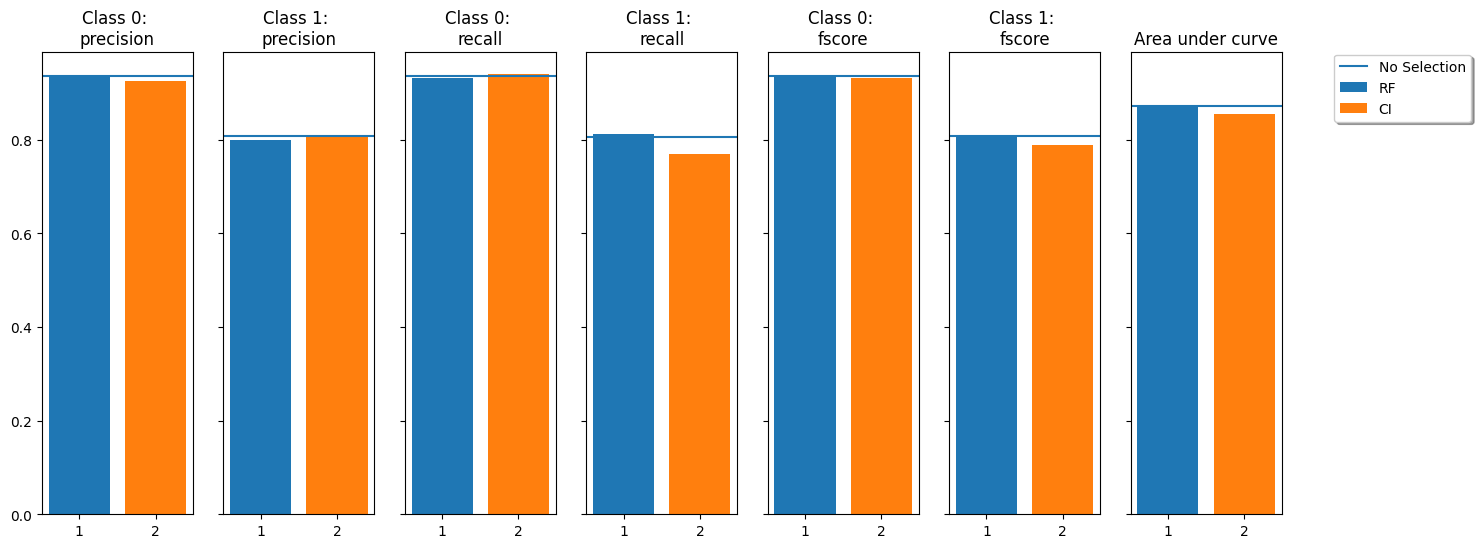

In [ ]:
evaluate_method(results, 'wrapper')

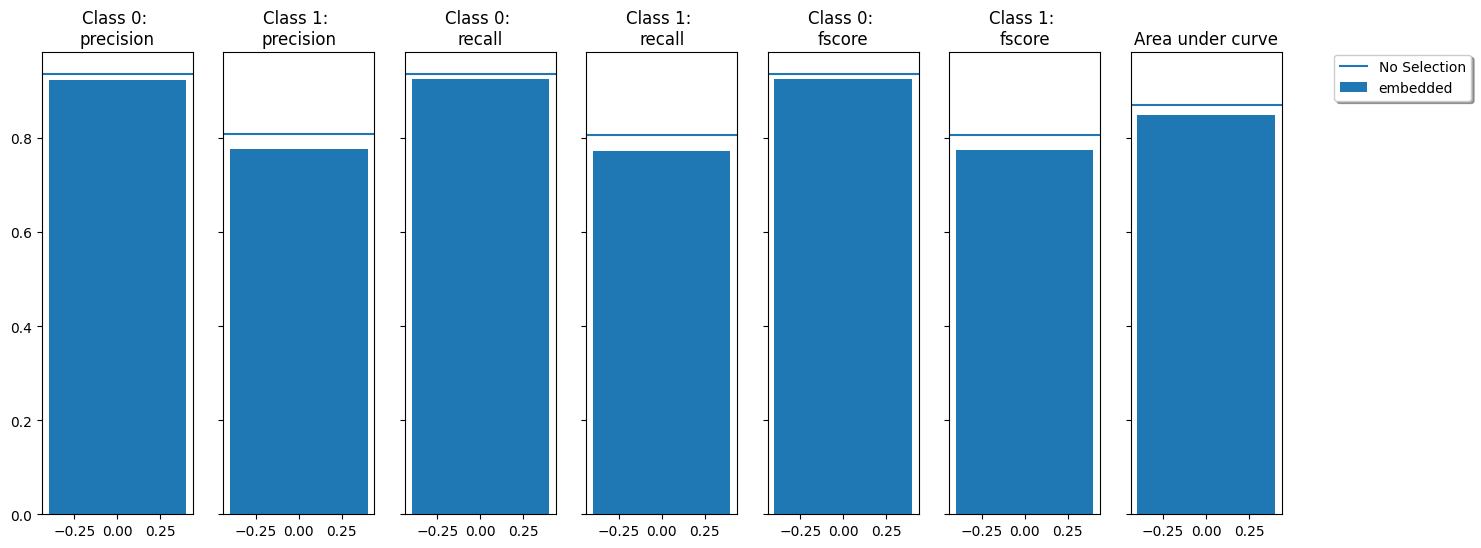

In [ ]:
evaluate_method(results, 'embedded')

# Inbalanced data


In [63]:
from sklearn.model_selection import train_test_split
data_frame = df_scaled_part_1
X = data_frame.drop(columns=['label']).copy()
y = data_frame['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

### Definición de funciones de análisis de resultados

In [64]:
from sklearn import metrics 
from collections import Counter

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours

def model_resampling_pipeline(X_train, X_test, y_train, y_test, model):
    results = {'ordinary': {},
               'class_weight': {},
               'oversample': {},
               'undersample': {},
               'mixed': {}
               }
    
    # ------ No balancing ------
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    results['ordinary'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                          'fscore': fscore, 'n_occurences': support,
                          'predictions_count': Counter(predictions),
                          'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                          'auc': auc}
    
    
    # ------ Class weight ------
    if 'class_weight' in model.get_params().keys():
        model.set_params(class_weight='balanced')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['class_weight'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                  'fscore': fscore, 'n_occurences': support,
                                  'predictions_count': Counter(predictions),
                                  'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                  'auc': auc}

    
    # ------------ OVERSAMPLING TECHNIQUES ------------
    print('------ Oversampling methods ------')
    techniques = [RandomOverSampler(),
                  SMOTE(),
                  ADASYN()]
    
    for sampler in techniques:
        technique = sampler.__class__.__name__
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['oversample'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}

    
    # ------------ UNDERSAMPLING TECHNIQUES ------------
    print('------ Undersampling methods ------')
    techniques = [RandomUnderSampler(),
                  NearMiss(version=1)]
    
    for sampler in techniques:
        technique = sampler.__class__.__name__
        if technique == 'NearMiss': technique+=str(sampler.version)
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)  
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['undersample'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}
        

    # ------------ MIXED TECHNIQUE ------------
    print('------ Mixed method ------')
    technique = 'Mixed'
    mnority_class = y_train[y_train == 1].shape[0]
    class_0 = y_train[y_train == 0].shape[0]
    desired_class_0 = mnority_class + (round((class_0 - mnority_class) / 2))

    print(f'Technique: Mixed')
    print(f'Before resampling: {sorted(Counter(y_train).items())}')

    # UNDERSAMPLING
    undersample = RandomUnderSampler(sampling_strategy={0: desired_class_0, 1: mnority_class}, random_state=42)
    X_under, y_under = undersample.fit_resample(X_train, y_train)

    # OVERSAMPLING
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

    print(f'After resampling: {sorted(Counter(y_resampled).items())}')

    # Entrenamiento
    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)

    results['mixed'][technique] = {'accuracy': accuracy, 
                                        'precision': precision, 
                                        'recall': recall,
                                        'fscore': fscore, 
                                        'n_occurences': support,
                                        'predictions_count': Counter(predictions),
                                        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                        'auc': auc}


    return results

In [65]:
def evaluate_method(results, method, metrics = ['precision', 'recall', 'fscore']):
    fig, ax = plt.subplots(1, 7, sharey=True, figsize=(16, 6))
    
    for i, metric in enumerate(metrics):
        ax[i*2].axhline(results['ordinary'][metric][0], label='No Resampling')
        ax[i*2+1].axhline(results['ordinary'][metric][1], label='No Resampling')
        
        if results['class_weight']:
            ax[i*2].bar(0, results['class_weight'][metric][0], label='Adjust Class Weight')
            ax[i*2+1].bar(0, results['class_weight'][metric][1], label='Adjust Class Weight')
            
        ax[0].legend(loc='upper center', bbox_to_anchor=(9, 1.01),
                     ncol=1, fancybox=True, shadow=True)
        
        for j, (technique, result) in enumerate(results[method].items()):
            ax[i*2].bar(j+1, result[metric][0], label=technique)
            
            ax[i*2+1].bar(j+1, result[metric][1], label=technique)
        
        
        ax[i*2].set_title(f'Class 0: \n{metric}')
        ax[i*2+1].set_title(f'Class 1: \n{metric}')
    
    # AUC vis
    ax[6].set_title(f'Area under curve')
    ax[6].axhline(results['ordinary']['auc'], label='No Resampling')
    if results['class_weight']:
        ax[6].bar(0, results['class_weight']['auc'], label='Adjust Class Weight')
    for j, (technique, result) in enumerate(results[method].items()):
        ax[6].bar(j+1, result['auc'], label=technique)

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

### Evaluación de resultados

##### Decission tree

In [95]:
# Tarda aprox 10 
model = DecisionTreeClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: SMOTE
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: ADASYN
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 287749)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
Technique: NearMiss1
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
------ Mixed method ------
Technique: Mixed
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 196588), (1, 196588)]


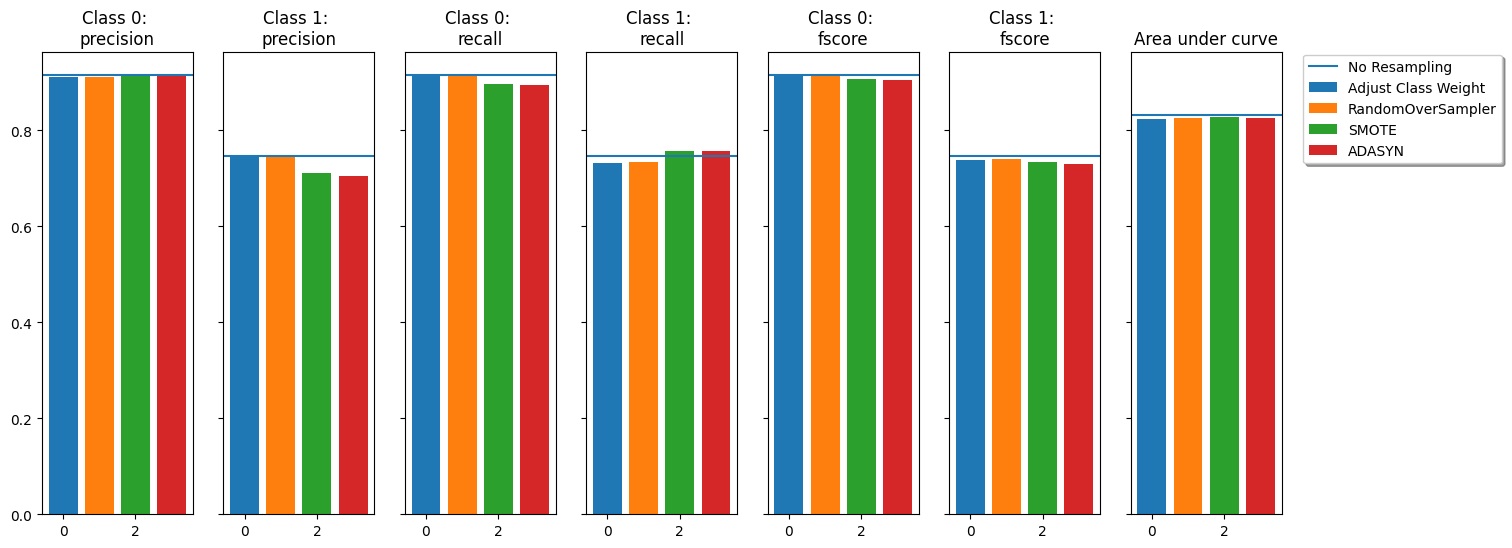

In [96]:
evaluate_method(results, 'oversample')

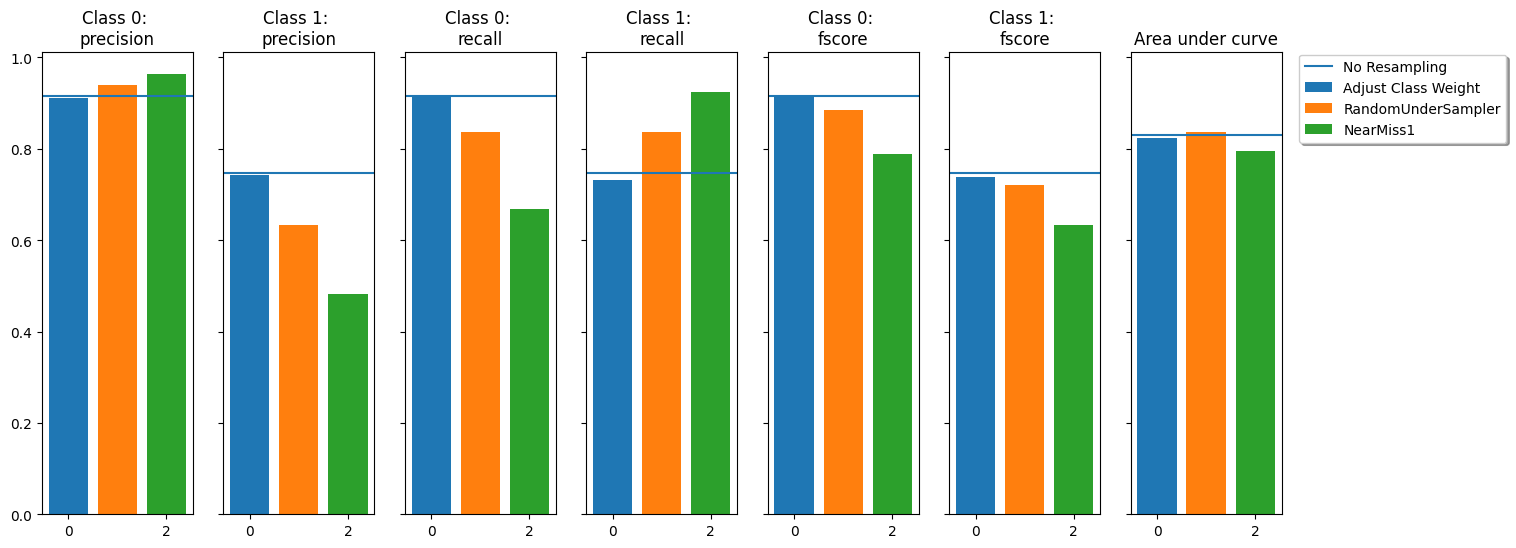

In [97]:
evaluate_method(results, 'undersample')

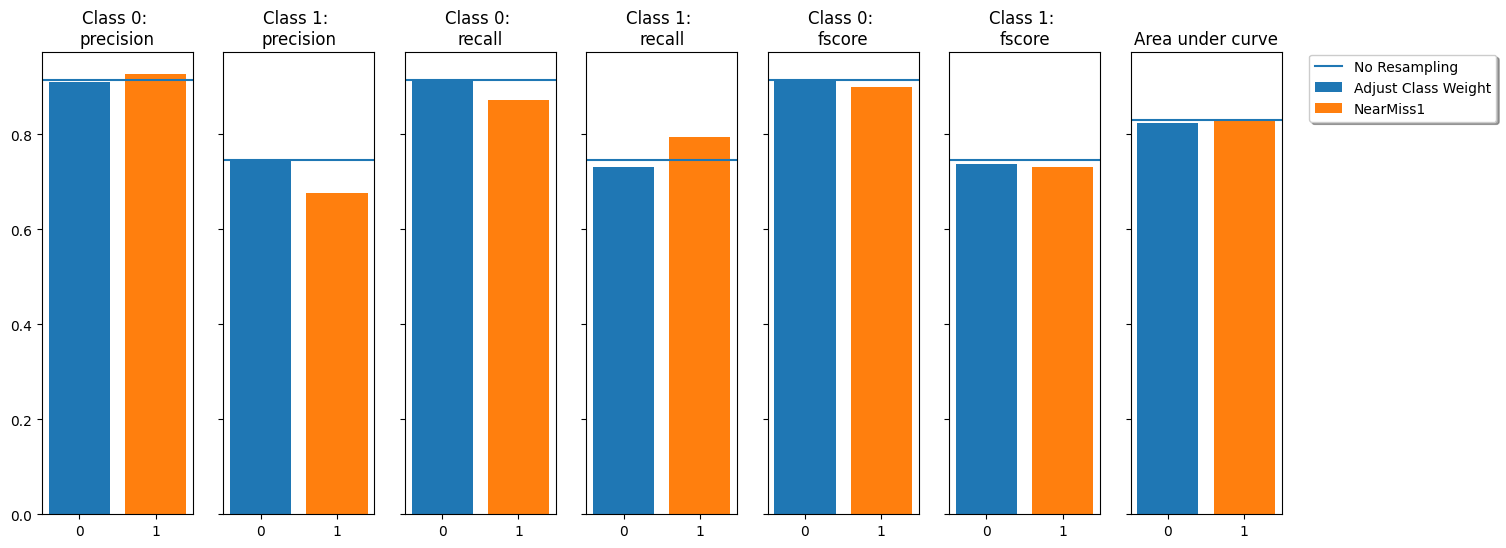

In [98]:
evaluate_method(results, 'mixed')

In [101]:
# Save results to consult later
results_DT = results

##### Random Forest

In [102]:
model = RandomForestClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: SMOTE
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: ADASYN
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 287749)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
Technique: NearMiss1
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
------ Mixed method ------
Technique: Mixed
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 196588), (1, 196588)]


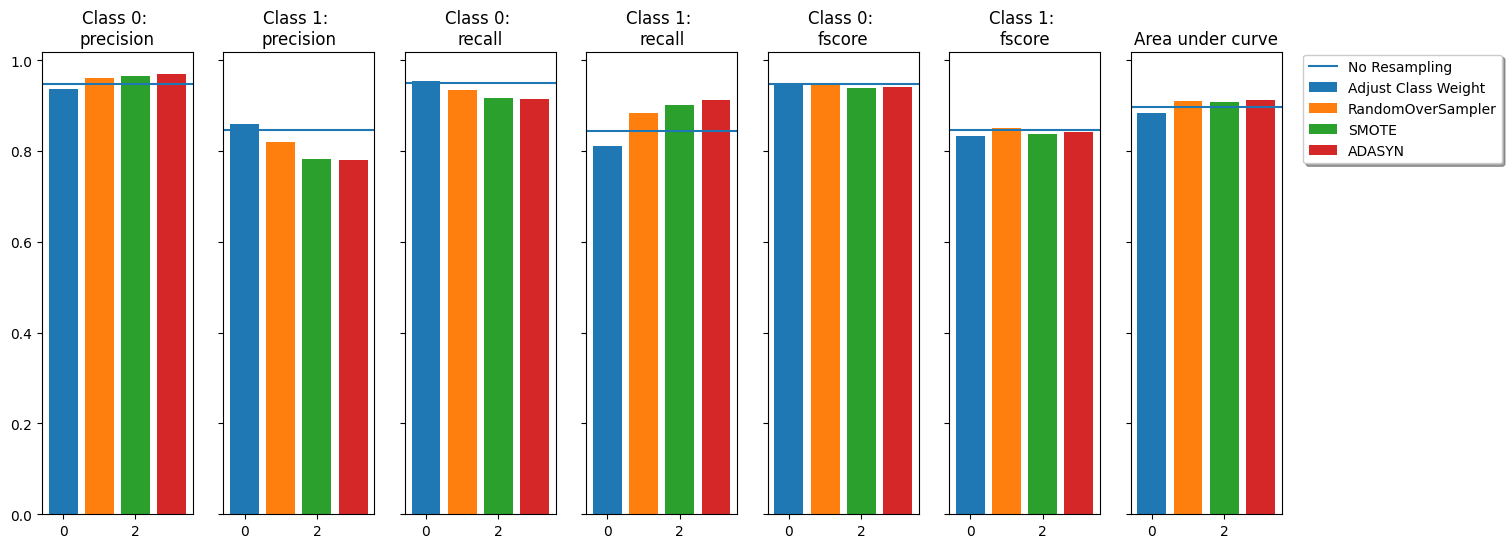

In [104]:
evaluate_method(results, 'oversample')

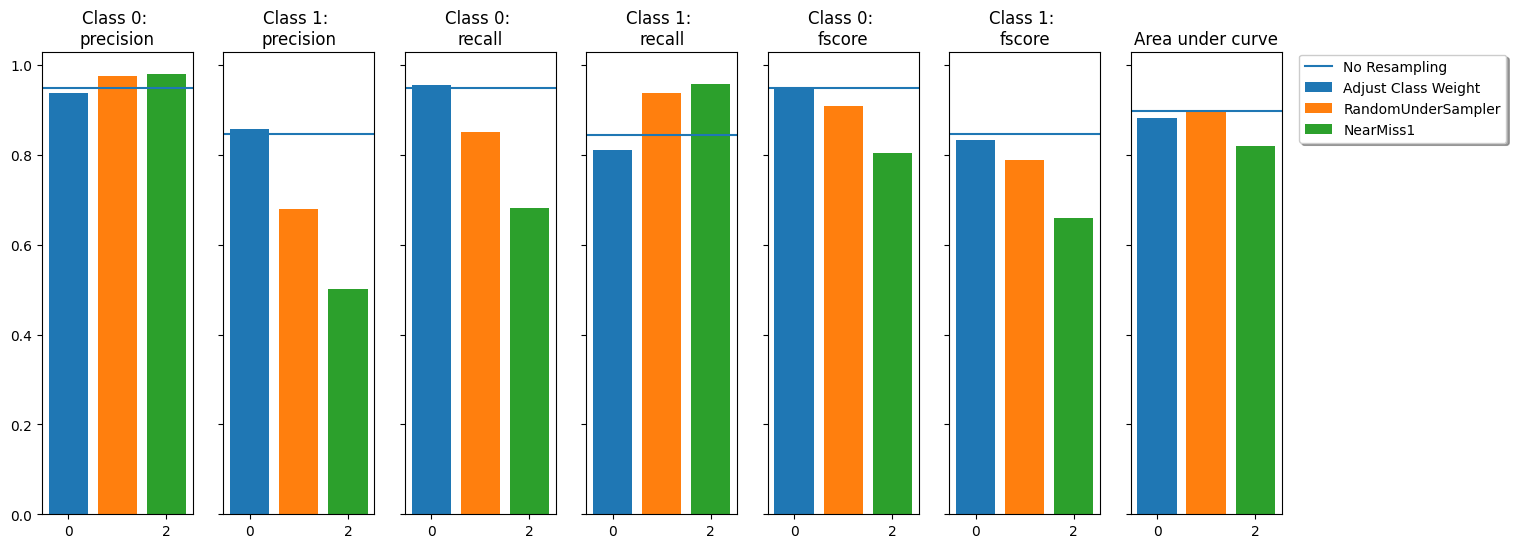

In [105]:
evaluate_method(results, 'undersample')

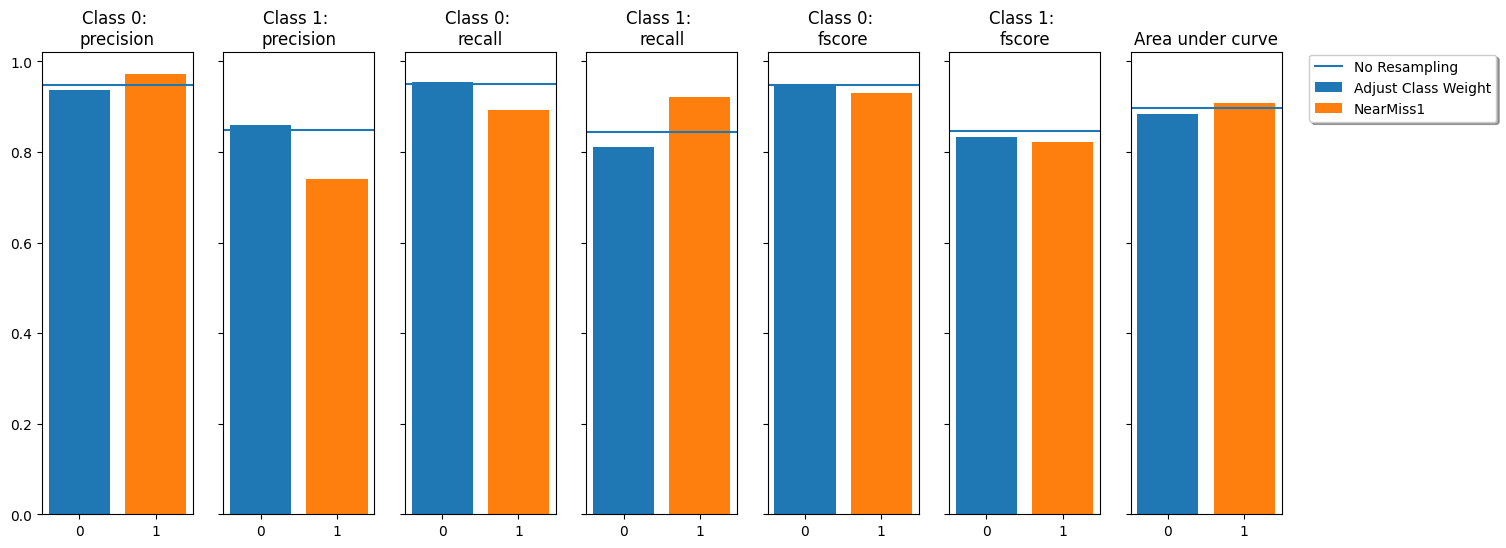

In [106]:
evaluate_method(results, 'mixed')

In [107]:
# Save results to consult later
results_RF = results

##### Logistic Regression

In [113]:
model = LogisticRegression()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: SMOTE
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: ADASYN
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 287749)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
Technique: NearMiss1
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
------ Mixed method ------
Technique: Mixed
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 196588), (1, 196588)]


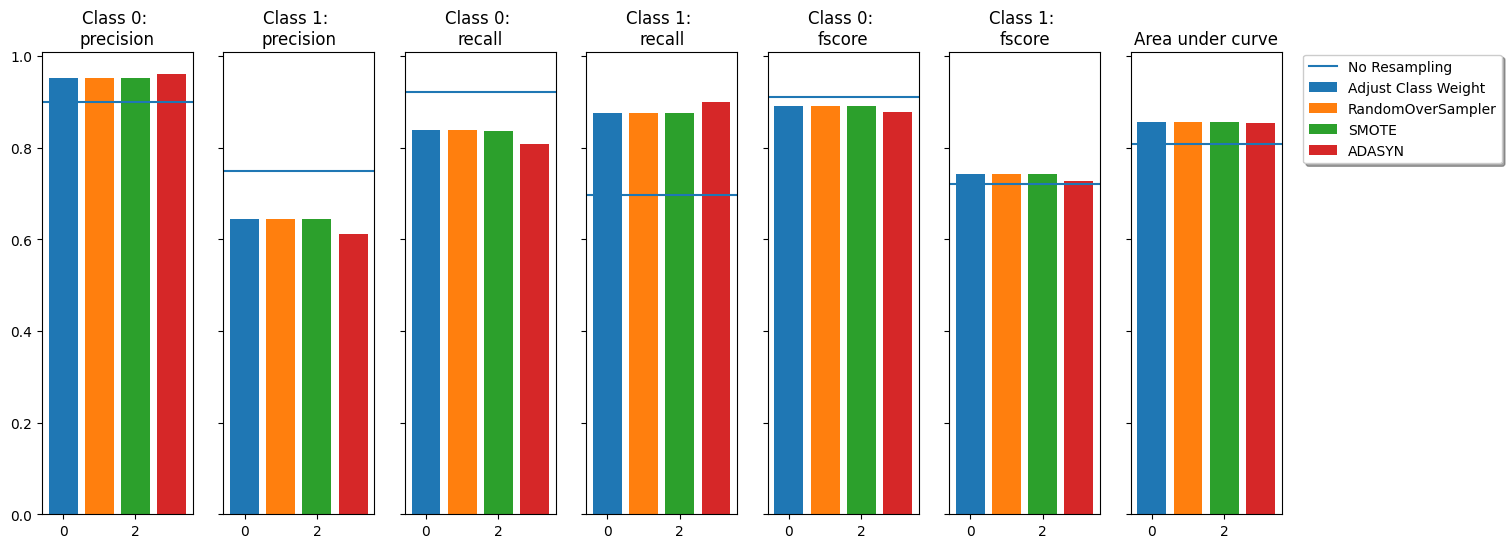

In [114]:
evaluate_method(results, 'oversample')

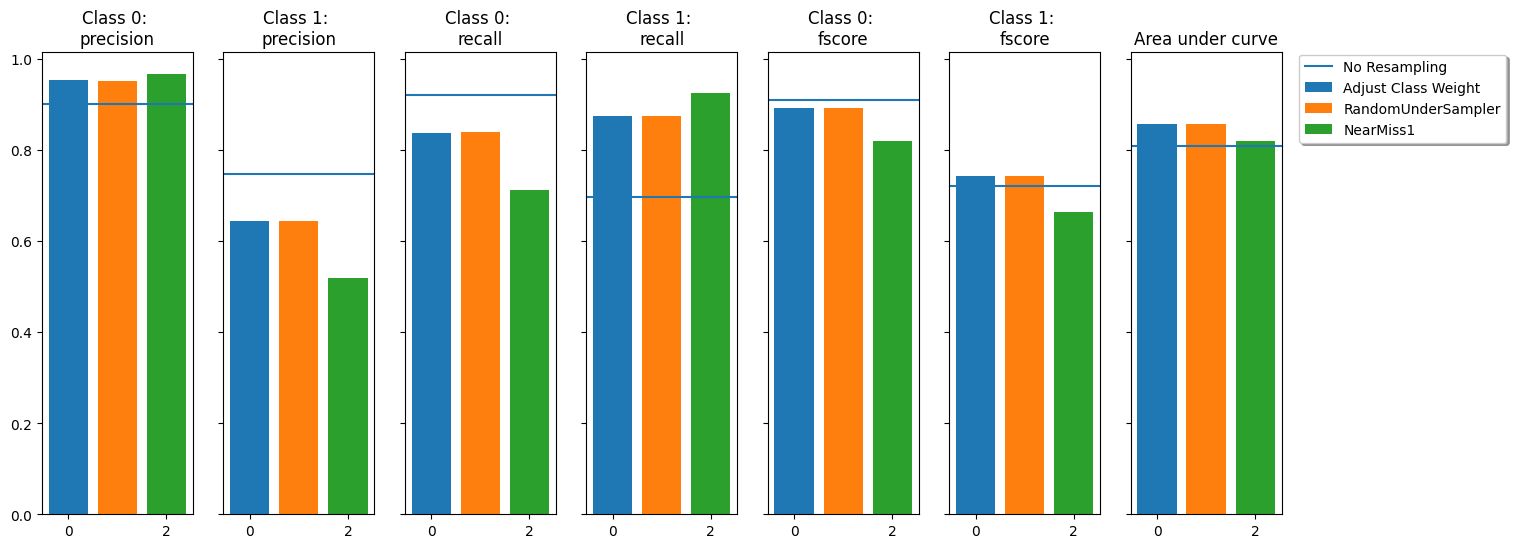

In [115]:
evaluate_method(results, 'undersample')

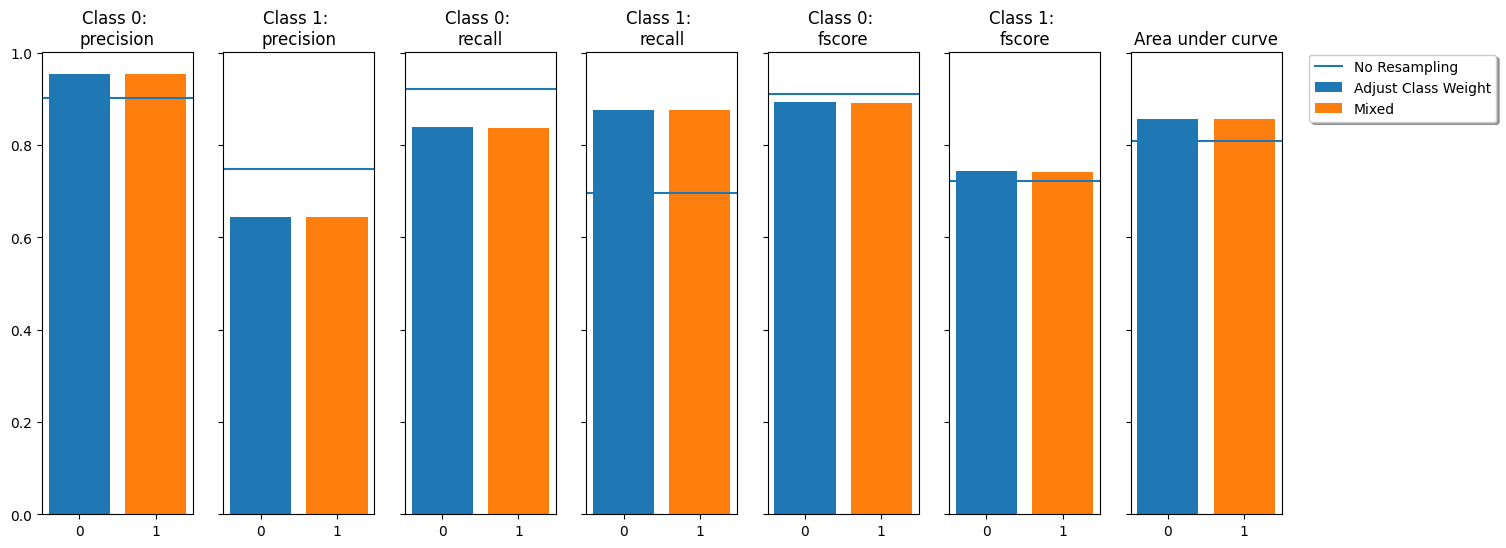

In [116]:
evaluate_method(results, 'mixed')

In [117]:
# Save results to consult later
results_LR = results

##### SGD Classifier

In [108]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss="hinge", penalty="l1", max_iter=1000)
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: SMOTE
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: ADASYN
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 287749)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
Technique: NearMiss1
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
------ Mixed method ------
Technique: Mixed
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 196588), (1, 196588)]


2 minutos ha tardado esta joya :3

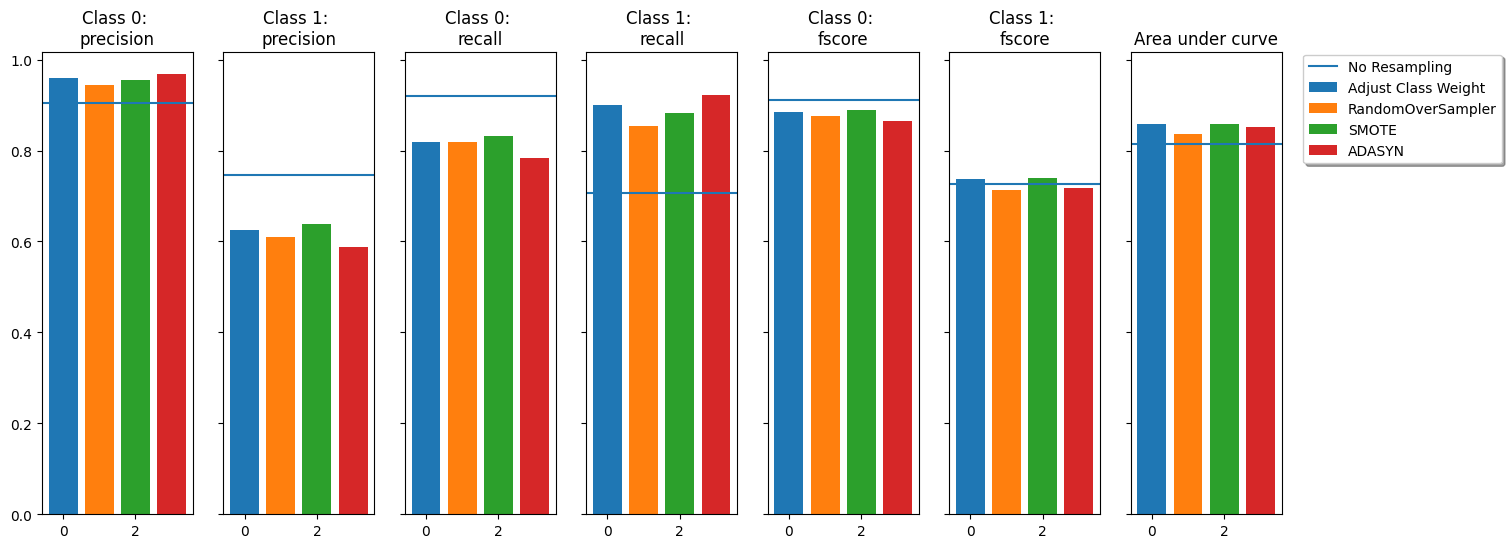

In [109]:
# evaluate_method(results, 'oversample')

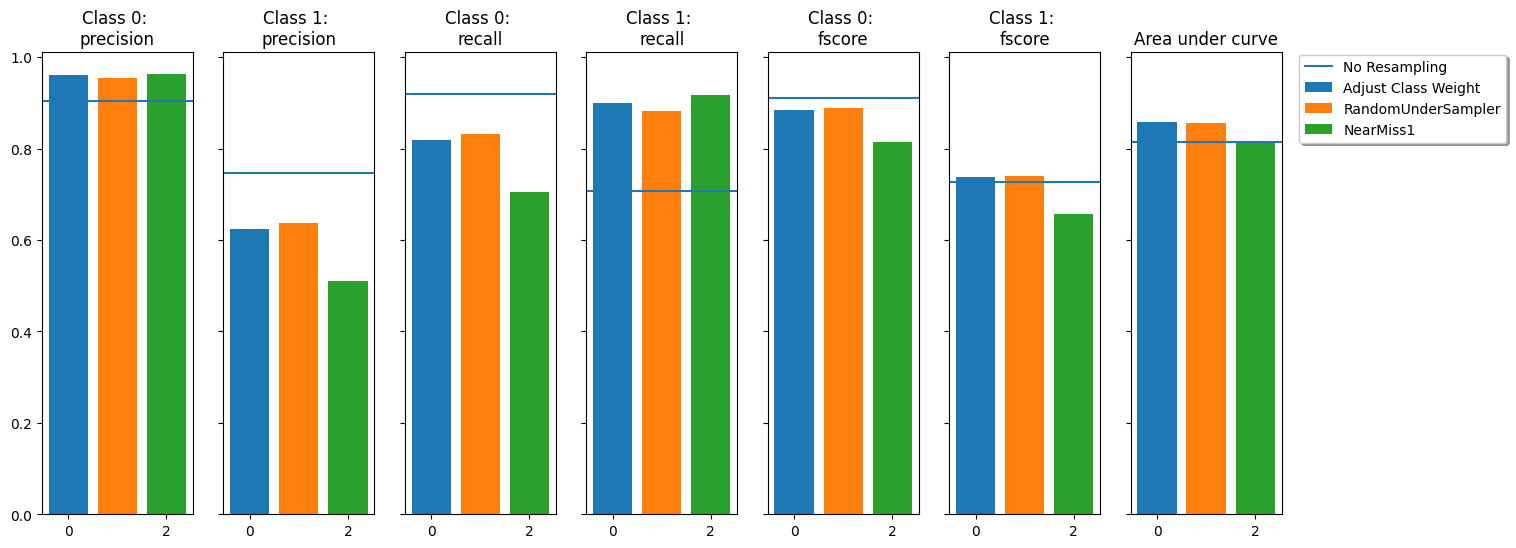

In [110]:
# evaluate_method(results, 'undersample')

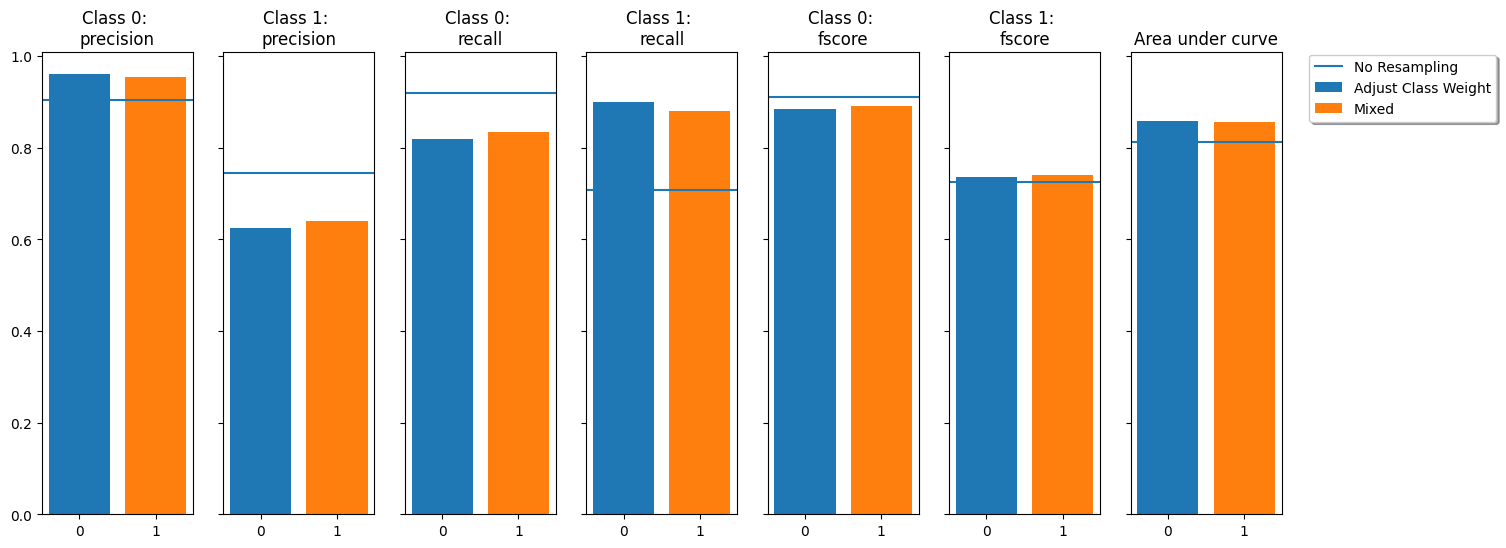

In [111]:
# evaluate_method(results, 'mixed')

In [112]:
# # Save results to consult later
# results_SGD = results

##### SVC Classifier -> imposible

In [ ]:
model = SVC()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

In [ ]:
evaluate_method(results, 'oversample')

In [ ]:
evaluate_method(results, 'undersample')

In [ ]:
evaluate_method(results, 'mixed')

In [ ]:
# Save results to consult later
results_SVC = results

##### KNN

In [68]:
model = KNeighborsClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: SMOTE
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: ADASYN
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 287708)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
Technique: NearMiss1
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
------ Mixed method ------
Technique: Mixed
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 196588), (1, 196588)]


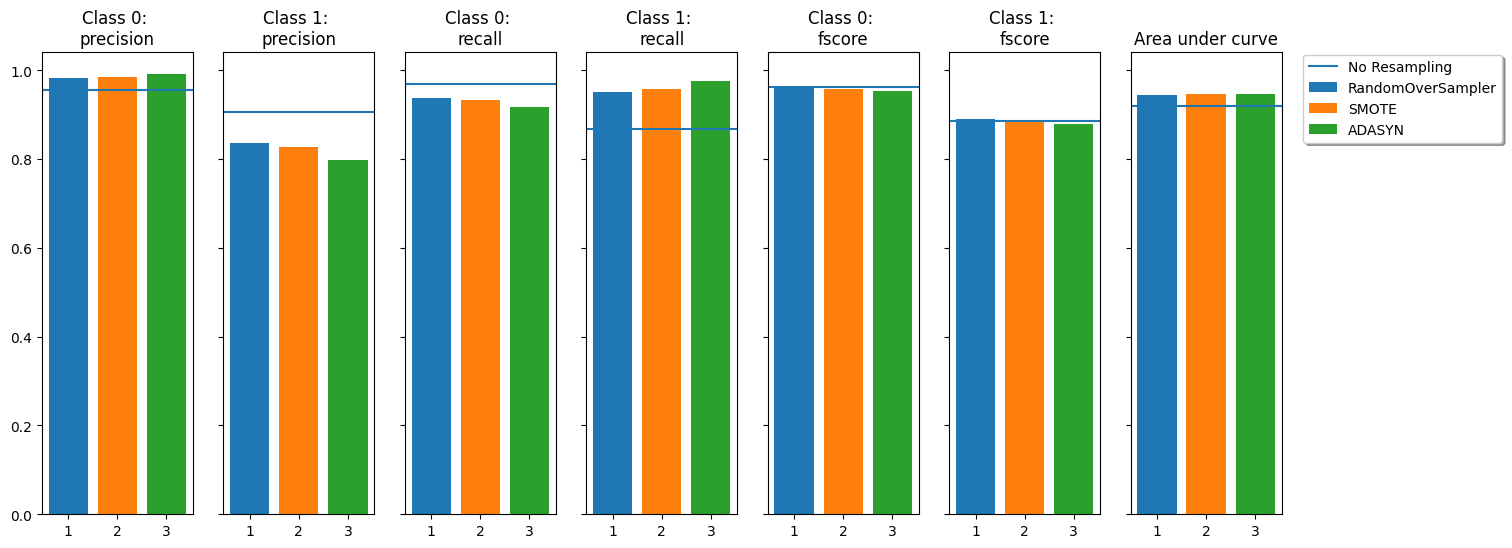

In [69]:
evaluate_method(results, 'oversample')

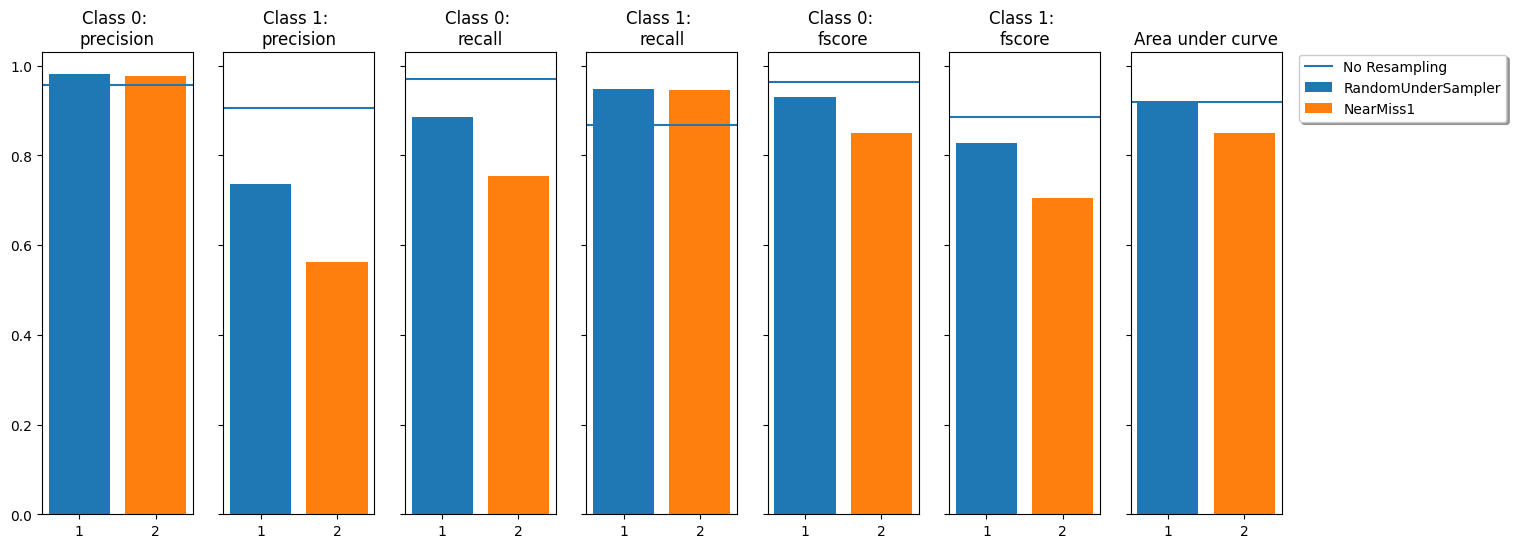

In [70]:
evaluate_method(results, 'undersample')

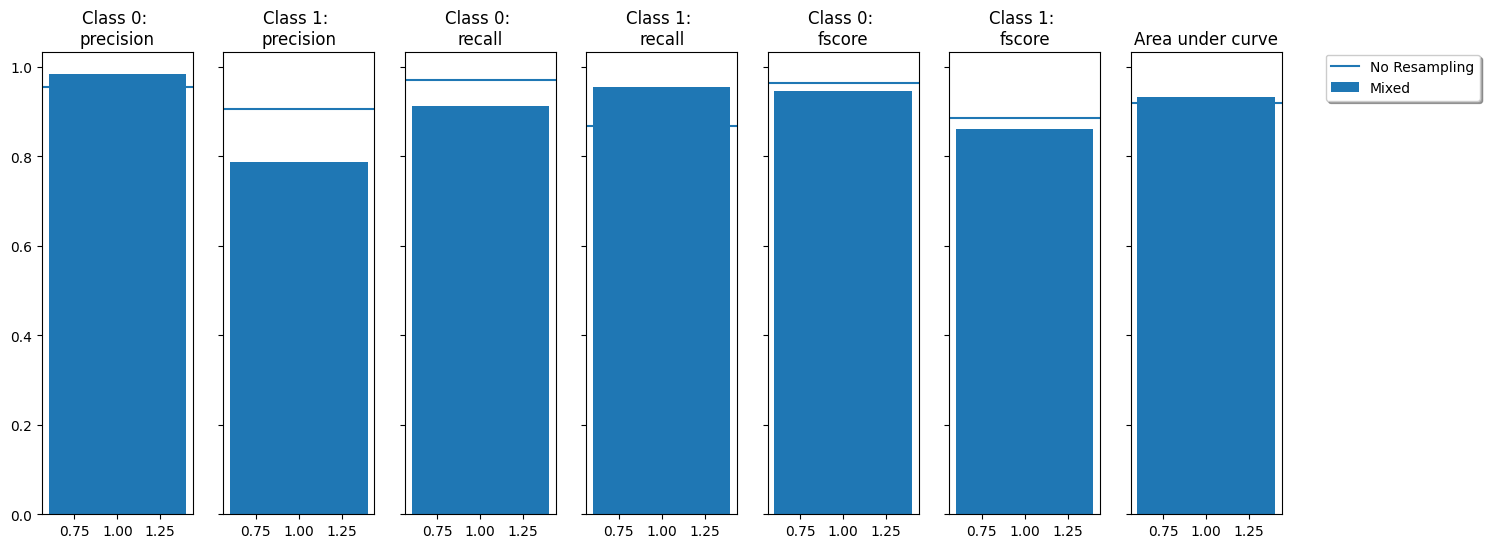

In [71]:
evaluate_method(results, 'mixed')

In [72]:
# Save results to consult later
results_KNN = results

##### AdaBoost Classifier

In [73]:
model = AdaBoostClassifier(algorithm="SAMME")
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Technique: SMOTE
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Technique: ADASYN
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 287708)]


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Technique: NearMiss1
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


------ Mixed method ------
Technique: Mixed
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 196588), (1, 196588)]


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


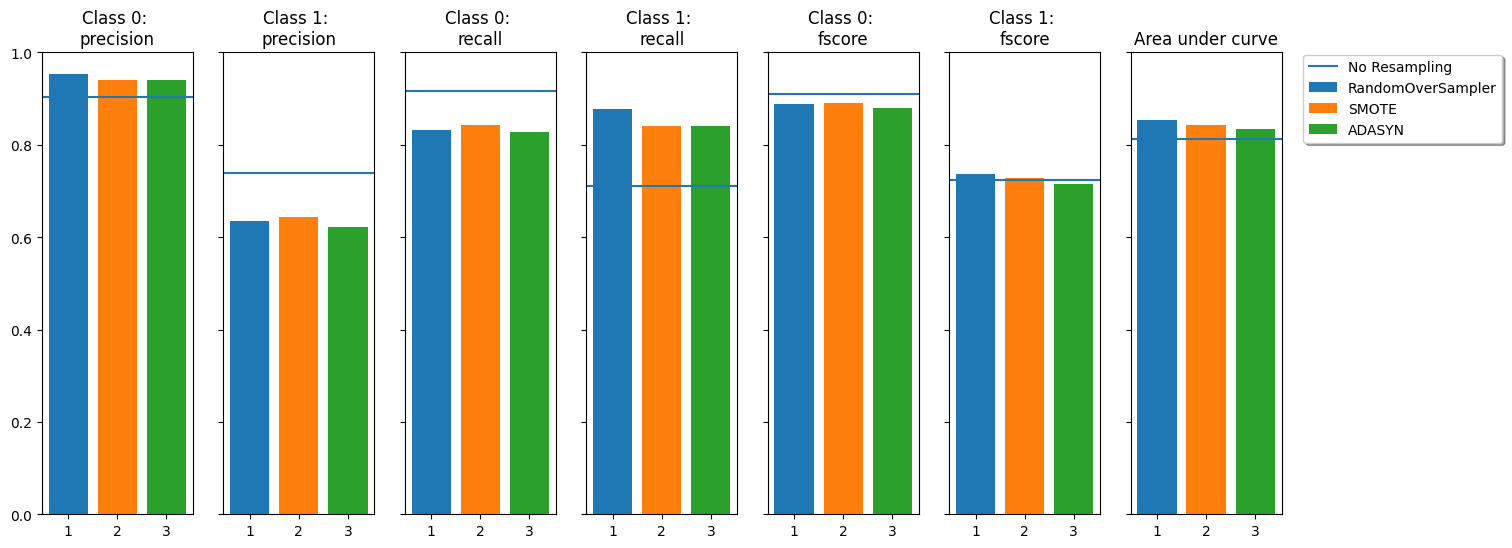

In [74]:
evaluate_method(results, 'oversample')

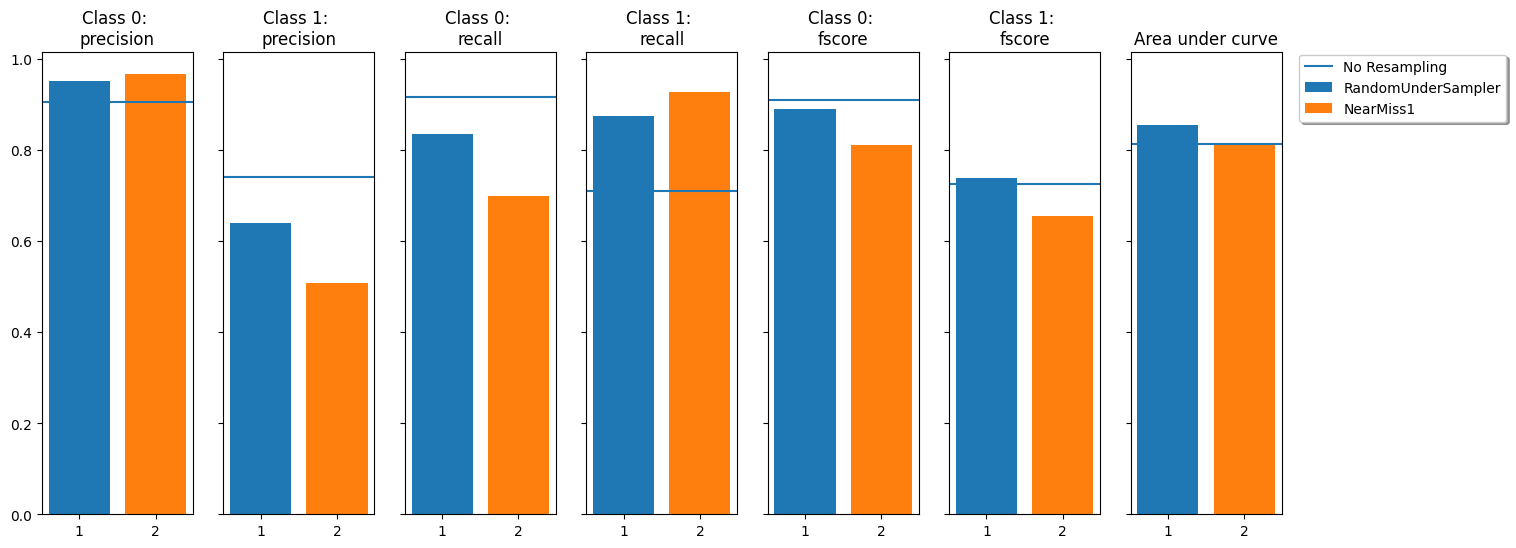

In [75]:
evaluate_method(results, 'undersample')

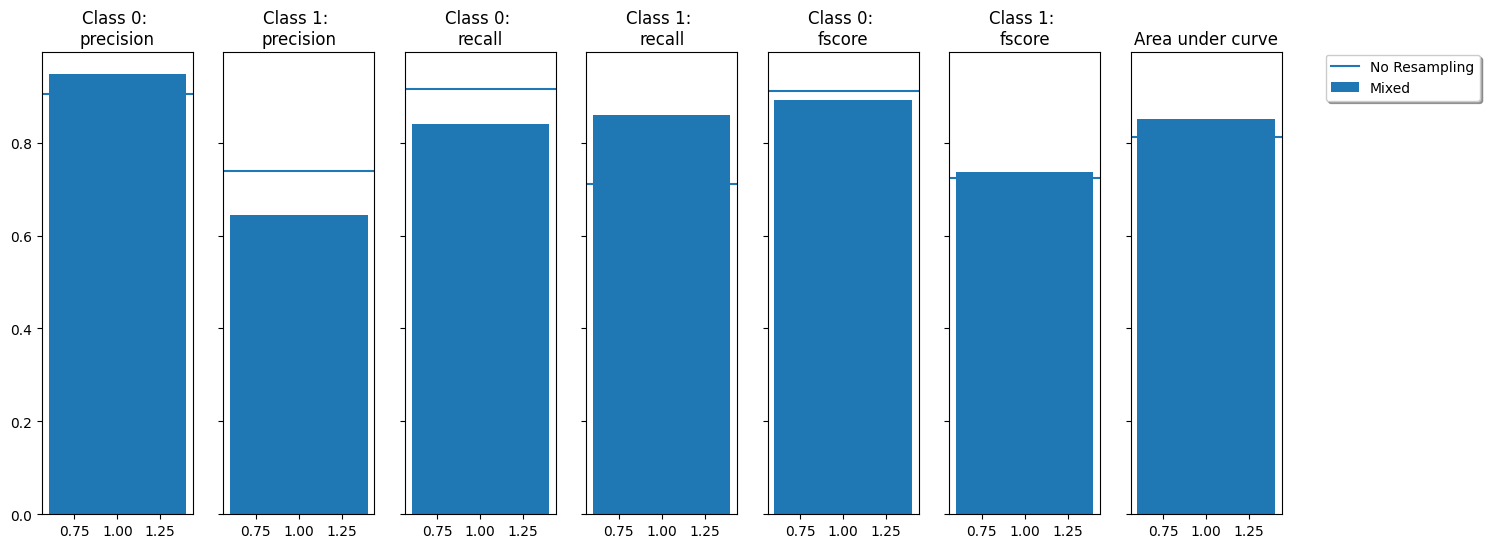

In [76]:
evaluate_method(results, 'mixed')

In [77]:
# Save results to consult later
results_AdaB = results

##### Simple neural network

In [79]:
model = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500)
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: SMOTE
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 294525)]
Technique: ADASYN
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 294525), (1, 287708)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
Technique: NearMiss1
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 98650), (1, 98650)]
------ Mixed method ------
Technique: Mixed
Before resampling: [(0, 294525), (1, 98650)]
After resampling: [(0, 196588), (1, 196588)]


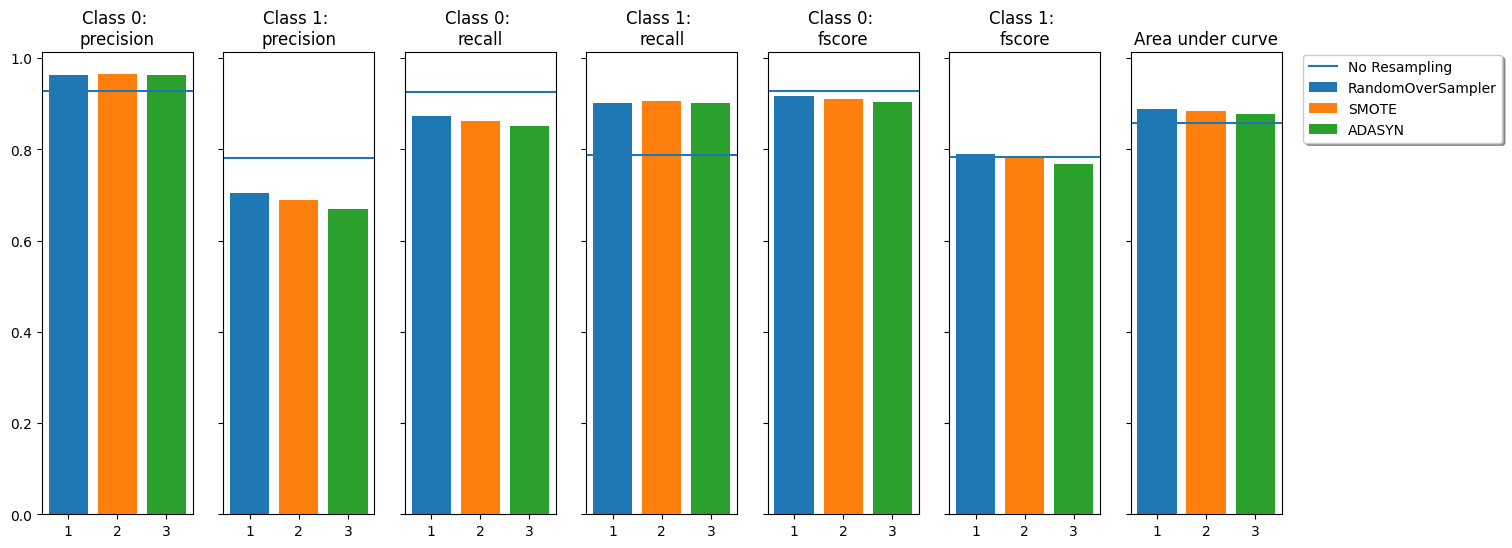

In [80]:
evaluate_method(results, 'oversample')

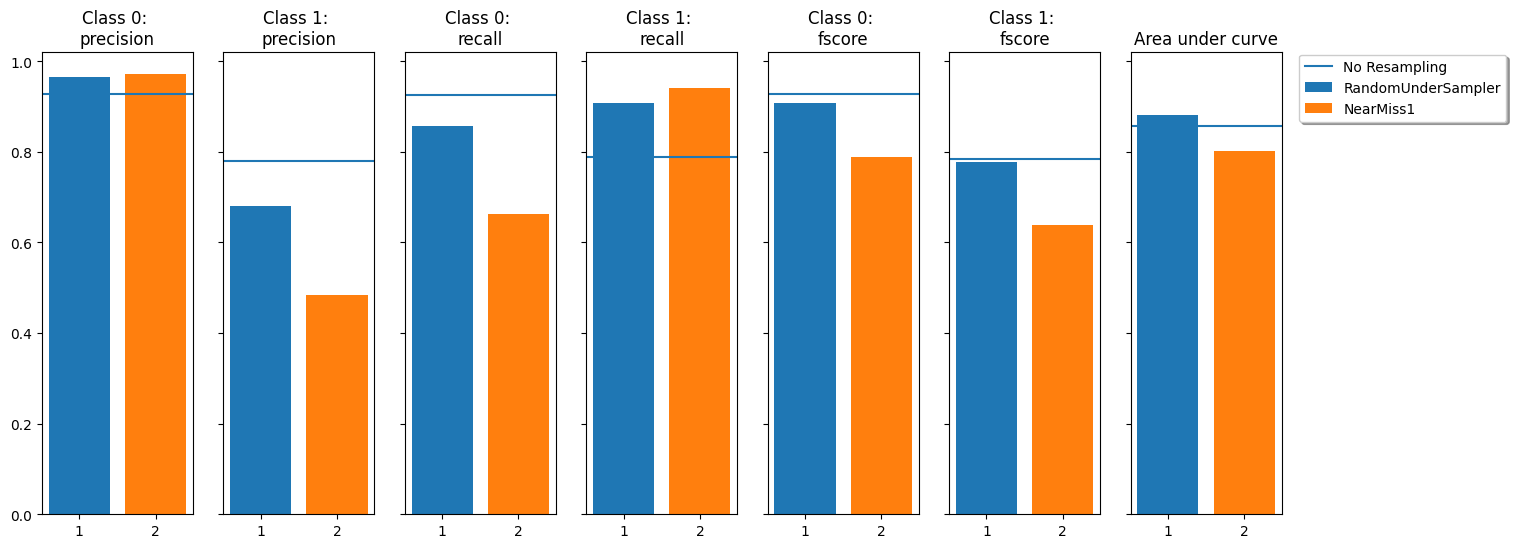

In [81]:
evaluate_method(results, 'undersample')

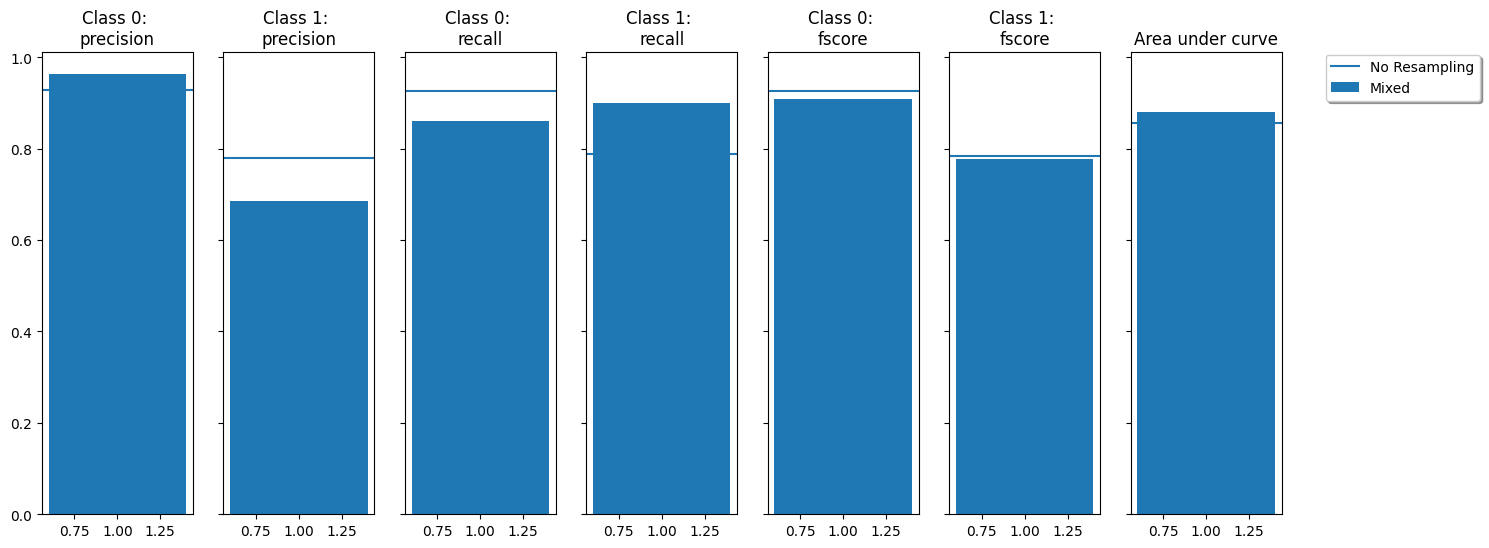

In [82]:
evaluate_method(results, 'mixed')

In [83]:
# Save results to consult later
results_NN = results

In [85]:
# from joblib import dump, load
# # Guardar modelo entrenado
# dump(model, 'modelo_NN.joblib')
# # Cargar el modelo guardado
# modelo_cargado = load('modelo_entrenado.joblib')

['modelo_NN.joblib']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class_counts_total = {}

for i in range(1, 8):

    data_frame = globals()[f'df_scaled_part_{i}']
    class_counts = data_frame['label'].value_counts()
    

    for label, count in class_counts.items():
        if label in class_counts_total:
            class_counts_total[label] += count
        else:
            class_counts_total[label] = count


class_counts_total_df = pd.DataFrame(list(class_counts_total.items()), columns=['label', 'count'])


plt.figure(figsize=(8, 6))
sns.barplot(data=class_counts_total_df, x='label',hue = 'label', y='count', palette='viridis', legend=False)
plt.title('Distribución de Clases Total')
plt.xlabel('Clase')
plt.ylabel('Frecuencia Total')
plt.show()


total_count = sum(class_counts_total.values())
class_percentages = {label: (count / total_count) * 100 for label, count in class_counts_total.items()}

# Gráfico circular para la distribución porcentual
plt.figure(figsize=(8, 6))
pd.Series(class_percentages).plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
plt.title('Distribución de Porcentajes de Cada Clase')
plt.ylabel('')
plt.show()


Claramente se ve una dominancia de la clase 0 sobre 1. 
<br><br>Como la diferencia de valores es tan significativa, en caso de aplicar directamente un Oversampling method sumaría de media 200.000 nuevas entradas por partición, 1.400.000 en total. 
<br><br>Para evitar un aumento tan masivo de datos y por consiguiente una dificultad añadida al entrenamiento, hemos decidido aplicar un Undersmpling method previo.

#### Undersampling + Oversampling (SMOTE)

No quiero hacer un aumento masivo pero tampoco una pérdida masiva de información, así que voy a probar una técnica que termine con la misma cantidad inicial de entradas en cada dataframe
<br><br> De este modo eliminamos e introducimos la misma cantidad de elementos y equilibramos los efectos negativos de ambos métodos (si solo eliminásemos habría una gran pérdida de información y si solo añadiésemos filas habría mayor riesgo de overfitting)

In [86]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

for i in range(1, 8):
    
    data_frame = globals()[f'df_scaled_part_{i}']
    # Casos en los que label = 1
    mnority_class = data_frame[data_frame['label'] == 1].shape[0]
    # Casos en los que label = 0
    class_0 = data_frame[data_frame['label'] == 0].shape[0]
    
    desired_class_0 = mnority_class + (round((class_0 - mnority_class) / 2))
    # Así conseguimos solo tratar con undersampling la mitad de casos y con oversampling la otra mitad

    
    X = data_frame.drop(columns=['label']).copy()  
    y = data_frame['label'] 

    # UNDERSAMPLING
    undersample = RandomUnderSampler(sampling_strategy={0: desired_class_0, 1: mnority_class}, random_state=42)
    X_under, y_under = undersample.fit_resample(X, y)

    # OVERSAMPLING
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

    
    print(f'Partición {i}:')
    print(f'Distribución después de Undersampling - Clase 0: {y_under.value_counts().get(0, 0)}; Clase 1: {y_under.value_counts().get(1, 0)}')
    print(f'Distribución después de SMOTE - Clase 0: {y_resampled.value_counts().get(0, 0)}; Clase 1: {y_resampled.value_counts().get(1, 0)}')
    print('')

    
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled['label'] = y_resampled
    globals()[f'df_resampled_part_{i}'] = df_resampled  

Partición 1:
Distribución después de Undersampling - Clase 0: 245735; Clase 1: 123313
Distribución después de SMOTE - Clase 0: 245735; Clase 1: 245735

Partición 2:
Distribución después de Undersampling - Clase 0: 245730; Clase 1: 121736
Distribución después de SMOTE - Clase 0: 245730; Clase 1: 245730

Partición 3:
Distribución después de Undersampling - Clase 0: 245731; Clase 1: 124226
Distribución después de SMOTE - Clase 0: 245731; Clase 1: 245731

Partición 4:
Distribución después de Undersampling - Clase 0: 245731; Clase 1: 123251
Distribución después de SMOTE - Clase 0: 245731; Clase 1: 245731

Partición 5:
Distribución después de Undersampling - Clase 0: 245729; Clase 1: 122761
Distribución después de SMOTE - Clase 0: 245729; Clase 1: 245729

Partición 6:
Distribución después de Undersampling - Clase 0: 245733; Clase 1: 122169
Distribución después de SMOTE - Clase 0: 245733; Clase 1: 245733

Partición 7:
Distribución después de Undersampling - Clase 0: 156578; Clase 1: 76412
Dis

# DataSet final

Selección de 53 características con el coeficiente de importancia CI y balanceo de datos con RandomOverSampler

In [143]:
total_filas = 0
for i in range(1,8):
    data_frame = globals()[f'df_scaled_part_{i}']
    y = data_frame['label']
    total_filas += y.shape[0]
    print(f'Valores iniciales df_part_{i}: total filas: {y.shape[0]}, {y.value_counts()}')
print(f'Total filas: {total_filas}')

Valores iniciales df_part_1: total filas: 491469, label
0    368156
1    123313
Name: count, dtype: int64
Valores iniciales df_part_2: total filas: 491461, label
0    369725
1    121736
Name: count, dtype: int64
Valores iniciales df_part_3: total filas: 491462, label
0    367236
1    124226
Name: count, dtype: int64
Valores iniciales df_part_4: total filas: 491462, label
0    368211
1    123251
Name: count, dtype: int64
Valores iniciales df_part_5: total filas: 491459, label
0    368698
1    122761
Name: count, dtype: int64
Valores iniciales df_part_6: total filas: 491466, label
0    369297
1    122169
Name: count, dtype: int64
Valores iniciales df_part_7: total filas: 313157, label
0    236745
1     76412
Name: count, dtype: int64
Total filas: 3261936


Antes tenemos que hacer el split ya que si rellenamos con datos "artificiales" los datos de test, se puede detectar patrones artificiales. Voy a intentar un split balanceado de valores de label, similar en test y train

In [151]:
total = 0
for i in range(1,8):
    data_frame = globals()[f'df_scaled_part_{i}']
    total += data_frame.shape[0]
print(f'Total filas: {total}')

Total filas: 3261936


In [154]:
import gc
from sklearn.model_selection import StratifiedShuffleSplit
selected_features = list(selected_features_WRAP_CI)

for i in range(1,8):
    data_frame = globals()[f'df_scaled_part_{i}']
    # Crear un DataFrame con una única entrada por cliente y su etiqueta
    client_labels = data_frame.groupby('ID')['label'].first().reset_index()

    # Crear el objeto de StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # Realizar el split estratificado basado en clientes
    for train_idx, test_idx in splitter.split(client_labels, client_labels['label']):
        train_clients = client_labels.iloc[train_idx]
        test_clients = client_labels.iloc[test_idx]


    df_train_part = data_frame[data_frame['ID'].isin(train_clients['ID'])][['ID'] + selected_features + ['label']]
    df_test_part = data_frame[data_frame['ID'].isin(test_clients['ID'])][['ID'] + selected_features + ['label']]

    globals()[f'df_train_part_{i}'] = df_train_part
    globals()[f'df_final_test_{i}'] = df_test_part

    # Liberar memoria de DataFrames temporales y ejecutar garbage collection
    del data_frame, client_labels, train_clients, test_clients
    gc.collect()


In [157]:
total = 0
for i in range(1,8):
    data_frame1 = globals()[f'df_train_part_{i}']
    data_frame2 = globals()[f'df_final_test_{i}']
    total += data_frame1.shape[0] + data_frame2.shape[0]
print(f'Total filas: {total}')


Total filas: 3261936


In [158]:
# Guardar los dataframes resultantes en la carpeta data/dataFrame_final
for i in range(1, 8):
    globals()[f'df_final_test_{i}'].to_csv(f'../data/dataFrame_final/final_test/df_final_test_{i}.csv', index=False)

Generar dataset de train final

In [165]:
from imblearn.over_sampling import RandomOverSampler
selected_features = ['ID'] + list(selected_features_WRAP_CI)
sampler = RandomOverSampler()
for i in range(1, 8):
    data_frame = globals()[f'df_train_part_{i}']
    X = data_frame[selected_features]
    y = data_frame['label']
    
    # Realizamos el sobremuestreo
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    # Guardamos el DataFrame resultante con las características y la etiqueta
    df_final = pd.DataFrame(X_resampled, columns=selected_features)
    df_final['label'] = y_resampled
    
    # Guardamos el DataFrame en una variable global
    globals()[f'df_final_train_{i}'] = df_final
  

In [ ]:
total_filas = 0
for i in range(1,8):
    data_frame = globals()[f'df_final_train_{i}']
    y = data_frame['label']
    total_filas += y.shape[0]
    print(f'Valores iniciales df_part_{i}: total filas: {y.shape[0]}, {y.value_counts()}')
print(f'Total filas: {total_filas}')

Valores iniciales df_part_1: total filas: 589300, label
0    294650
1    294650
Name: count, dtype: int64
Valores iniciales df_part_2: total filas: 591620, label
0    295810
1    295810
Name: count, dtype: int64
Valores iniciales df_part_3: total filas: 588132, label
0    294066
1    294066
Name: count, dtype: int64
Valores iniciales df_part_4: total filas: 589284, label
1    294642
0    294642
Name: count, dtype: int64
Valores iniciales df_part_5: total filas: 589622, label
0    294811
1    294811
Name: count, dtype: int64
Valores iniciales df_part_6: total filas: 591136, label
0    295568
1    295568
Name: count, dtype: int64
Valores iniciales df_part_7: total filas: 379178, label
0    189589
1    189589
Name: count, dtype: int64
Total filas: 3918272


In [166]:
for i in range(1, 8):
    globals()[f'df_final_train_{i}'].to_csv(f'../data/dataFrame_final/final_train/df_final_train_{i}.csv', index=False)